In [2]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
from praw.exceptions import ClientException
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors

from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import interp

import string
from pprint import pprint

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [5]:
creds = {}
with open ('/opt/cap1/.cap1', 'r') as fp:
    for line in fp:
        k, v = line.replace('\n','').split('\t')
        creds[k] = v

In [6]:
reddit = praw.Reddit(client_id=creds['REDDIT_ID'], 
    client_secret=creds['REDDIT_SECRET'],
    password=creds['REDDIT_PASSWORD'], 
    username=creds['REDDIT_USERNAME'],
    user_agent='accessAPI:v0.0.1 (by /u/{})'.format(creds['REDDIT_USERNAME']))

In [7]:
api = PushshiftAPI()

In [8]:
client = MongoClient('localhost', 27017)
db = client['cap2']

In [9]:
# get all comments into a list called 'docs', then make dataframe
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [10]:
comms = pd.DataFrame(docs)

In [10]:
# TODO add submission ids to the set of ids from trolls, probably append 't1_' to comments
# for ease of use

## assign labels, 'troll?', and 'child_of_troll?', and 'parent_of_troll?'

In [11]:
# create array of classes for target
classes = ['other', 'parent', 'child', 'troll']

In [12]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
np.sum(comms['troll?'])

6704

In [13]:
# is this comment in reply to a troll?
comms['child_of_troll?'] = [int(mybool) for mybool in [
                    pid.split('_')[1] in troll_comment_ids_set for pid in comms['parent_id']
                    ]]
np.sum(comms['child_of_troll?'])

2985

### only 57, praw never gave us children of troll comments...the only ones we have are from trolls replying to trolls

#### FIXED, used praw to get the troll comments, then used .refresh() to load the replies. worked ok

In [14]:
# did a troll reply to this?
troll_parent_ids_set = set(
                            [p.split('_')[1] for p in comms[~comms['author'].isna()]['parent_id']]
                        )
comms['parent_of_troll?'] = [int(myid in troll_parent_ids_set) for myid in comms['id']]

np.sum(comms['parent_of_troll?'])

1824

In [15]:
np.unique([p.split('_')[0] for p in np.unique(comms[~comms['author'].isna()]['parent_id'])], return_counts=True)

(array(['t1', 't3'], dtype='<U2'), array([1839, 4348]))

#### hm, 1144 comments are parents of trolls, but there are 1839 't1'-style parent_ids among troll comments. Which of the unique parent ids aren't getting labeled as parent?

#### FIXED, got all of them except 15. Seems like reddit praw is a bit stingy when it comes to providing all comments in a thread, perhaps especially around trolls. Could make a test for that

In [16]:
parent_ids = np.unique(comms[~comms['author'].isna()]['parent_id'])
len(parent_ids)

6187

In [17]:
t1_parent_ids=[]
for p in parent_ids:
    if p[:2]=='t1':
        t1_parent_ids.append(p.split('_')[1])
set_parent_ids = set(t1_parent_ids)
set_parent_of_troll = set(comms[comms['parent_of_troll?']==1]['id'])
# how does a differ from 
len(set_parent_ids), len(set_parent_of_troll)

(1839, 1824)

In [18]:
# here are the 695 comment ids that probably need to be set as parent_of_troll
missing_commentids = np.array(t1_parent_ids)[[myid not in set_parent_of_troll for myid in t1_parent_ids]]

In [19]:
# are these comments simply missing from the data? YES
# FIXED, only 15 remain after starting with 1824 ish
num_hits = []
for cid in missing_commentids:
    num_hits.append(len(comms[comms['id']==cid]))
np.unique(num_hits, return_counts=True)

(array([0]), array([15]))

In [20]:
len(missing_commentids)

15

In [21]:
def printall(pd_obj):
    '''
    print every row and column in a pandas object
    '''
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(pd_obj)

In [22]:
# print the first non-troll comment, making sure to 
r = np.where(comms['author'].isna())
printall(comms.iloc[r[0], :].iloc[0,:])

author                                                                           NaN
author_created_utc                                                               NaN
author_flair_css_class                                                    mod-rikker
author_flair_text                  http://steamcommunity.com/profiles/76561198054...
author_fullname                                                             t2_6ey3m
body                               Prepare yourself for several "FTL for Borderla...
controversiality                                                                   0
created_utc                                                              1.34787e+09
distinguished                                                                   None
gilded                                                                             0
id                                                                           c69bqat
link_id                                                          

In [23]:
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    964
comment       : 234008


In [24]:
# Reddit's api changed, dict(vars(comment)) only worked after running a ._fetch()
# get missing comments from pushshift
# gen = api.search_comments(id=','.join(missing_commentids))
# gen = api.search_comments(id='c55cs4v')
ids =','.join(missing_commentids[:2])
#print(ids)
#gen = api.search_comments(id=ids)
comment = reddit.comment(id="cqe9a6b")
pprint(vars(comment))
#for c in gen:
#    print(c.d_['body'])
    #db['comment'].insert_one(c.d_)

{'_fetched': False,
 '_reddit': <praw.reddit.Reddit object at 0x7fa4508dc9a0>,
 '_replies': [],
 '_submission': None,
 'id': 'cqe9a6b'}


In [ ]:
# okay, so c55cs4v is here -- 
# https://snew.notabug.io/r/unixporn/comments/vjbgg/archlinux_dwm/c55cs4v/
# and you can see shomyo's reply with permalink -- 
# https://snew.notabug.io/r/unixporn/comments/vjbgg/archlinux_dwm/c55hjc4/

In [ ]:
# top-up the parent comments, worked great.
log = [] 
i = 0 # had clientexception at 59, id='cqe9a6b'
for comment_id in missing_commentids[i:]: 
    i += 1 
    print(f'searching for comment id: {comment_id}') 
    comment = reddit.comment(id=comment_id) 
    try: 
        comment._fetch() 
    except (Forbidden, ClientException): 
        log.append(i) 
        continue 
    d = dict(vars(comment)) 
    for key in ['_replies', '_submission', 
            '_reddit', 'mod', 'author', 
            'subreddit']: 
        _ = d.pop(key, None) 
    try: 
        db['comment'].insert_one(d) 
    except (errors.DuplicateKeyError, errors.InvalidDocument): 
        log.append[i] 
        continue 

In [25]:
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    964
comment       : 234008


In [26]:
# these are the before and after numbers of records in mongo
# 15 records failed
num_records_added = 231533 - 230853
num_records_added

680

In [ ]:
# from the ipython session in which I ran the scrape
log = [59, 63, 84, 98, 109, 187, 500, 580, 632, 667, 670, 676, 678, 684, 689]
missing_commentids[log]

### cqhtj4q
```
[–]zenzog3 points 5 years ago 
https://mobile.twitter.com/shoxCSGO/status/588523685419601922
permalink save report give gold reply
```
https://snew.notabug.io/r/csgobetting/comments/3324gu/envyus_vs_dignitas_bo3_190415_2100_cest/cqhtj4q/

### d4ssri9
```
[–][censored]3 points 4 years ago 
[censored]
permalink save report give gold reply[removed by moderators]
```
https://snew.notabug.io/r/rage/comments/4qgm68/woman_26_wielded_hatchet_after_her_demands_for/d4ssri9/

### dp9fs27
```
–][deleted]2 points 3 years ago 
[deleted]
permalink save report give gold reply
```
https://snew.notabug.io/r/Sissies/comments/7ad3vx/any_requests/dp9fs27/

In [25]:
# get the replies to the trolls
# get missing comments from pushshift
troll_commentids = comms[~comms['author'].isna()]['id']
np.random.choice(troll_commentids)

'd2azig8'

In [ ]:
# top-up the child comments, worked great
log = [] 
i = 0 
for comment_id in troll_commentids:  
    i += 1  
    print(f'searching for comment id: {comment_id}')  
    comment = reddit.comment(id=comment_id)  
    try:  
        comment.refresh() 
    except (Forbidden, ClientException):  
        log.append(i)  
        continue 
    for reply in comment._replies: 
        d = dict(vars(reply)) 
        did = d['id'] 
        print(f'found reply id: {did}')  
        for key in ['_replies', '_submission',  
                '_reddit', 'mod', 'author',  
                'subreddit']:  
            _ = d.pop(key, None)  
        try:  
            db['comment'].insert_one(d) 
        except (errors.DuplicateKeyError, errors.InvalidDocument): 
            log.append(i)  
            continue 

In [209]:
# 234008 comments after first child run, steady after re-run so far...30 min or so
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    964
comment       : 234008


In [29]:
records_added = 234008 - 231533
records_added

2475

## NLP

In [26]:
orig_stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

# new stopwords after first run through
# sws_to_add_brf1 = 'thanks,op,tie,deleted,game,crypto,invest,\
# edit,platform,play,giveaway,ok,yeah,blockchain,enter,remove,\
# m,token,awesome,ethereum,exchange,steam,dude'.split(',')

# stopwords_ = set(list(orig_stopwords_) + sws_to_add_brf1)
stopwords_ = orig_stopwords_

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [27]:
def nlp_pre_proc_doc(input_string, stemming=False):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    if stemming:
        s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
        le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
        return ' '.join(le_s_f_lo_tokens)
    else:
        le_f_lo_tokens = lemm_tokens(wordnet, f_lo_tokens)
        return ' '.join(le_f_lo_tokens)

In [28]:
# this takes a few minutes, and uses about 100 MB of RAM
corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

#### so, let's recap the tomfoolery between praw and psaw
0) psaw returns comments from trolls, praw does not ... true? FALSE, psaw doesn't give results when parent_id is from a troll
1) psaw returns nothing when searching on threads with comments from trolls ... true? mostly. I believe it's not 100%, but e.g. https://api.pushshift.io/reddit/submission/comment_ids/4rdu5x returns []
2) re: 1, reddit does, but does not include any responses to the trolls ... true?

#### TODO
* classify on pca / increase the number of maximum features per tree
* data completeness
  - do we have all comments multiple levels below troll comments?
  - authors, subreddits, link- and comment-karma
  - permalink
* one-hot encode the subreddit to add to the tfidf
* add user activity profile to the tfidf
* start with id, (comment)
  - is the comment trollish? proba > threshold
  - if yes, then 
    - classify all other comments from the user (max=1000?)
    - for each trollish comment, recurse on other trollish comments in its thread (max=1000?)
  - given all the comments (including non-trollish from threads), view the author creation date and test for spike


#### join the [71.6 million usernames](https://old.reddit.com/r/pushshift/search?q=karma&restrict_sr=on&sort=relevance&t=all) to the user activity dataframe so we can efficiently load the link and comment karma of all these users into mongo
```bash
comm <(\
    sed '1d' user_activity_dataframe.csv | cut -d, -f2 | sort -u\
    ) \
    <(\
    cut -d, -f1 user_activity_dataframe_reddit_accounts.csv | sort -u\
    ) | 
awk -F"\t" '{print NF;}' | sort | uniq -c
```
``` 
    56 1
   277 3
```

### record ids for comments with neither depth nor nest_level

In [45]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(comms[[not value for value in comms['nest_level'].isna()]].head())
    for i, row in enumerate(comms[['nest_level', 'depth']].values):
        print(i, all([np.isnan(val) for val in row]))

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 True
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False
1

928 False
929 False
930 False
931 False
932 False
933 False
934 False
935 False
936 False
937 False
938 False
939 False
940 False
941 False
942 False
943 False
944 False
945 False
946 False
947 False
948 False
949 False
950 False
951 False
952 False
953 False
954 False
955 False
956 False
957 False
958 False
959 False
960 False
961 False
962 False
963 False
964 False
965 False
966 False
967 False
968 False
969 False
970 False
971 False
972 False
973 False
974 False
975 False
976 False
977 False
978 False
979 False
980 False
981 False
982 False
983 False
984 False
985 False
986 False
987 False
988 False
989 False
990 False
991 False
992 False
993 False
994 False
995 False
996 False
997 False
998 False
999 False
1000 False
1001 False
1002 False
1003 False
1004 False
1005 False
1006 False
1007 False
1008 False
1009 False
1010 False
1011 False
1012 False
1013 False
1014 False
1015 False
1016 False
1017 False
1018 False
1019 False
1020 False
1021 False
1022 False
1023 False
1024 False
1025 

1849 False
1850 False
1851 False
1852 False
1853 False
1854 False
1855 False
1856 False
1857 False
1858 False
1859 False
1860 False
1861 False
1862 False
1863 False
1864 False
1865 False
1866 False
1867 False
1868 False
1869 False
1870 False
1871 False
1872 False
1873 False
1874 False
1875 False
1876 False
1877 False
1878 False
1879 False
1880 False
1881 False
1882 False
1883 False
1884 False
1885 False
1886 False
1887 False
1888 False
1889 False
1890 False
1891 False
1892 False
1893 False
1894 False
1895 False
1896 False
1897 False
1898 False
1899 False
1900 False
1901 False
1902 False
1903 False
1904 False
1905 False
1906 False
1907 False
1908 False
1909 False
1910 False
1911 False
1912 False
1913 False
1914 False
1915 False
1916 False
1917 False
1918 False
1919 False
1920 False
1921 False
1922 False
1923 False
1924 False
1925 False
1926 False
1927 False
1928 False
1929 False
1930 False
1931 False
1932 False
1933 False
1934 False
1935 False
1936 False
1937 False
1938 False
1939 False

2747 False
2748 False
2749 False
2750 False
2751 False
2752 False
2753 False
2754 False
2755 False
2756 False
2757 False
2758 False
2759 False
2760 False
2761 False
2762 False
2763 False
2764 False
2765 False
2766 False
2767 False
2768 False
2769 False
2770 False
2771 False
2772 False
2773 False
2774 False
2775 False
2776 False
2777 False
2778 False
2779 False
2780 False
2781 False
2782 False
2783 False
2784 False
2785 False
2786 False
2787 False
2788 False
2789 False
2790 False
2791 False
2792 False
2793 False
2794 False
2795 False
2796 False
2797 True
2798 True
2799 True
2800 True
2801 False
2802 False
2803 False
2804 False
2805 False
2806 False
2807 False
2808 True
2809 True
2810 True
2811 True
2812 True
2813 True
2814 True
2815 True
2816 True
2817 True
2818 True
2819 True
2820 True
2821 True
2822 True
2823 True
2824 True
2825 True
2826 True
2827 True
2828 True
2829 True
2830 False
2831 False
2832 False
2833 False
2834 False
2835 False
2836 False
2837 False
2838 False
2839 False
284

3668 False
3669 False
3670 False
3671 False
3672 False
3673 False
3674 False
3675 False
3676 False
3677 False
3678 False
3679 False
3680 False
3681 False
3682 False
3683 False
3684 False
3685 False
3686 False
3687 False
3688 False
3689 False
3690 False
3691 False
3692 False
3693 False
3694 False
3695 False
3696 False
3697 False
3698 False
3699 False
3700 False
3701 False
3702 False
3703 False
3704 False
3705 False
3706 False
3707 False
3708 False
3709 False
3710 False
3711 False
3712 False
3713 False
3714 False
3715 False
3716 False
3717 False
3718 False
3719 False
3720 False
3721 True
3722 True
3723 True
3724 True
3725 True
3726 True
3727 True
3728 True
3729 True
3730 True
3731 True
3732 True
3733 True
3734 True
3735 True
3736 True
3737 True
3738 True
3739 True
3740 True
3741 True
3742 True
3743 True
3744 True
3745 True
3746 True
3747 True
3748 True
3749 True
3750 True
3751 True
3752 True
3753 True
3754 True
3755 True
3756 True
3757 True
3758 True
3759 True
3760 True
3761 True
3762 Fa

4601 False
4602 False
4603 False
4604 False
4605 False
4606 False
4607 False
4608 False
4609 False
4610 False
4611 False
4612 False
4613 False
4614 False
4615 False
4616 False
4617 False
4618 False
4619 False
4620 False
4621 False
4622 False
4623 False
4624 False
4625 False
4626 False
4627 False
4628 False
4629 False
4630 False
4631 False
4632 False
4633 False
4634 False
4635 False
4636 False
4637 False
4638 False
4639 False
4640 False
4641 False
4642 False
4643 False
4644 False
4645 False
4646 False
4647 False
4648 False
4649 False
4650 False
4651 False
4652 False
4653 False
4654 False
4655 False
4656 False
4657 False
4658 False
4659 False
4660 False
4661 False
4662 False
4663 False
4664 False
4665 False
4666 False
4667 False
4668 False
4669 False
4670 False
4671 False
4672 False
4673 False
4674 False
4675 False
4676 False
4677 False
4678 False
4679 False
4680 False
4681 False
4682 False
4683 False
4684 False
4685 False
4686 False
4687 False
4688 False
4689 False
4690 False
4691 False

5532 False
5533 False
5534 False
5535 False
5536 False
5537 False
5538 False
5539 False
5540 False
5541 False
5542 False
5543 False
5544 False
5545 False
5546 False
5547 False
5548 False
5549 False
5550 False
5551 False
5552 False
5553 False
5554 False
5555 False
5556 False
5557 False
5558 False
5559 False
5560 False
5561 False
5562 False
5563 False
5564 False
5565 False
5566 False
5567 False
5568 False
5569 False
5570 False
5571 False
5572 False
5573 False
5574 False
5575 False
5576 False
5577 False
5578 False
5579 False
5580 False
5581 False
5582 False
5583 False
5584 False
5585 False
5586 False
5587 False
5588 False
5589 False
5590 False
5591 False
5592 False
5593 False
5594 False
5595 False
5596 False
5597 False
5598 False
5599 False
5600 False
5601 False
5602 False
5603 False
5604 False
5605 False
5606 False
5607 False
5608 False
5609 False
5610 False
5611 False
5612 False
5613 False
5614 False
5615 False
5616 False
5617 False
5618 False
5619 False
5620 False
5621 False
5622 False

6495 False
6496 False
6497 False
6498 False
6499 False
6500 False
6501 False
6502 True
6503 False
6504 False
6505 False
6506 False
6507 False
6508 False
6509 False
6510 False
6511 False
6512 False
6513 False
6514 False
6515 False
6516 False
6517 False
6518 False
6519 False
6520 False
6521 False
6522 False
6523 False
6524 False
6525 False
6526 False
6527 False
6528 False
6529 False
6530 False
6531 False
6532 False
6533 False
6534 False
6535 False
6536 False
6537 False
6538 True
6539 True
6540 True
6541 True
6542 True
6543 True
6544 True
6545 True
6546 True
6547 True
6548 True
6549 True
6550 True
6551 True
6552 True
6553 True
6554 False
6555 False
6556 False
6557 False
6558 False
6559 False
6560 False
6561 False
6562 False
6563 False
6564 False
6565 False
6566 False
6567 False
6568 False
6569 False
6570 False
6571 False
6572 False
6573 False
6574 False
6575 False
6576 False
6577 False
6578 False
6579 False
6580 False
6581 False
6582 False
6583 False
6584 False
6585 False
6586 False
6587 

7442 False
7443 False
7444 False
7445 False
7446 False
7447 False
7448 False
7449 False
7450 False
7451 False
7452 False
7453 False
7454 False
7455 False
7456 False
7457 False
7458 False
7459 False
7460 False
7461 False
7462 False
7463 False
7464 False
7465 False
7466 False
7467 False
7468 False
7469 False
7470 False
7471 False
7472 False
7473 False
7474 False
7475 False
7476 False
7477 False
7478 False
7479 False
7480 False
7481 False
7482 False
7483 False
7484 False
7485 False
7486 False
7487 False
7488 False
7489 False
7490 False
7491 False
7492 False
7493 False
7494 False
7495 False
7496 False
7497 False
7498 False
7499 False
7500 False
7501 False
7502 False
7503 False
7504 False
7505 False
7506 False
7507 False
7508 False
7509 False
7510 False
7511 False
7512 False
7513 False
7514 False
7515 False
7516 False
7517 False
7518 False
7519 False
7520 False
7521 False
7522 False
7523 False
7524 False
7525 False
7526 False
7527 False
7528 False
7529 False
7530 False
7531 False
7532 False

8408 False
8409 False
8410 False
8411 False
8412 False
8413 False
8414 False
8415 False
8416 False
8417 False
8418 False
8419 False
8420 False
8421 False
8422 False
8423 False
8424 False
8425 False
8426 False
8427 False
8428 False
8429 False
8430 False
8431 False
8432 False
8433 False
8434 False
8435 False
8436 False
8437 False
8438 False
8439 False
8440 False
8441 False
8442 False
8443 False
8444 False
8445 False
8446 False
8447 False
8448 False
8449 False
8450 False
8451 False
8452 False
8453 False
8454 False
8455 False
8456 False
8457 False
8458 False
8459 False
8460 False
8461 False
8462 False
8463 False
8464 False
8465 False
8466 False
8467 False
8468 False
8469 False
8470 False
8471 False
8472 False
8473 False
8474 False
8475 False
8476 False
8477 False
8478 False
8479 False
8480 False
8481 False
8482 False
8483 False
8484 False
8485 False
8486 False
8487 False
8488 False
8489 False
8490 False
8491 False
8492 False
8493 False
8494 False
8495 False
8496 False
8497 False
8498 False

9406 False
9407 False
9408 False
9409 False
9410 False
9411 False
9412 False
9413 False
9414 False
9415 False
9416 False
9417 False
9418 False
9419 False
9420 False
9421 False
9422 False
9423 False
9424 False
9425 False
9426 False
9427 False
9428 False
9429 False
9430 False
9431 False
9432 False
9433 False
9434 False
9435 False
9436 False
9437 False
9438 False
9439 False
9440 False
9441 False
9442 False
9443 False
9444 False
9445 False
9446 False
9447 False
9448 False
9449 False
9450 False
9451 False
9452 False
9453 False
9454 False
9455 False
9456 False
9457 False
9458 False
9459 False
9460 False
9461 False
9462 False
9463 False
9464 False
9465 False
9466 False
9467 False
9468 False
9469 False
9470 False
9471 False
9472 False
9473 False
9474 False
9475 False
9476 False
9477 False
9478 False
9479 False
9480 False
9481 False
9482 False
9483 False
9484 False
9485 False
9486 False
9487 False
9488 False
9489 False
9490 False
9491 False
9492 False
9493 False
9494 False
9495 False
9496 False

10361 False
10362 False
10363 False
10364 False
10365 False
10366 False
10367 False
10368 False
10369 False
10370 False
10371 False
10372 False
10373 False
10374 False
10375 False
10376 False
10377 False
10378 False
10379 False
10380 False
10381 False
10382 False
10383 False
10384 False
10385 False
10386 False
10387 False
10388 False
10389 False
10390 False
10391 False
10392 False
10393 False
10394 False
10395 False
10396 False
10397 False
10398 False
10399 False
10400 False
10401 False
10402 False
10403 False
10404 False
10405 False
10406 False
10407 False
10408 False
10409 False
10410 False
10411 False
10412 False
10413 False
10414 False
10415 False
10416 False
10417 False
10418 False
10419 False
10420 False
10421 False
10422 False
10423 False
10424 False
10425 False
10426 False
10427 False
10428 False
10429 False
10430 False
10431 False
10432 False
10433 False
10434 False
10435 False
10436 False
10437 False
10438 False
10439 False
10440 False
10441 False
10442 False
10443 False
1044

11283 False
11284 False
11285 False
11286 False
11287 False
11288 False
11289 False
11290 False
11291 False
11292 False
11293 False
11294 False
11295 False
11296 False
11297 False
11298 False
11299 False
11300 False
11301 False
11302 False
11303 False
11304 False
11305 False
11306 False
11307 False
11308 False
11309 False
11310 False
11311 False
11312 False
11313 False
11314 False
11315 False
11316 False
11317 False
11318 False
11319 False
11320 False
11321 False
11322 False
11323 False
11324 False
11325 False
11326 False
11327 False
11328 False
11329 False
11330 False
11331 False
11332 False
11333 False
11334 False
11335 False
11336 False
11337 False
11338 False
11339 False
11340 False
11341 False
11342 False
11343 False
11344 False
11345 False
11346 False
11347 False
11348 False
11349 False
11350 False
11351 False
11352 False
11353 False
11354 False
11355 False
11356 False
11357 False
11358 False
11359 False
11360 False
11361 False
11362 False
11363 False
11364 False
11365 False
1136

12207 False
12208 False
12209 False
12210 False
12211 False
12212 False
12213 False
12214 False
12215 False
12216 False
12217 False
12218 False
12219 False
12220 False
12221 False
12222 False
12223 False
12224 False
12225 False
12226 False
12227 False
12228 False
12229 False
12230 False
12231 False
12232 False
12233 False
12234 False
12235 False
12236 False
12237 False
12238 False
12239 False
12240 False
12241 False
12242 False
12243 False
12244 False
12245 False
12246 False
12247 False
12248 False
12249 False
12250 False
12251 False
12252 False
12253 False
12254 False
12255 False
12256 False
12257 False
12258 False
12259 False
12260 False
12261 False
12262 False
12263 False
12264 False
12265 False
12266 False
12267 False
12268 False
12269 False
12270 False
12271 False
12272 False
12273 False
12274 False
12275 False
12276 False
12277 False
12278 False
12279 False
12280 False
12281 False
12282 False
12283 False
12284 False
12285 False
12286 False
12287 False
12288 False
12289 False
1229

13122 False
13123 False
13124 False
13125 False
13126 False
13127 False
13128 False
13129 False
13130 False
13131 False
13132 False
13133 False
13134 False
13135 False
13136 False
13137 False
13138 False
13139 False
13140 False
13141 False
13142 False
13143 False
13144 False
13145 False
13146 False
13147 False
13148 False
13149 False
13150 False
13151 False
13152 False
13153 False
13154 False
13155 False
13156 False
13157 False
13158 False
13159 False
13160 False
13161 False
13162 False
13163 False
13164 False
13165 False
13166 False
13167 False
13168 False
13169 False
13170 False
13171 False
13172 False
13173 False
13174 False
13175 False
13176 False
13177 False
13178 False
13179 False
13180 False
13181 False
13182 False
13183 False
13184 False
13185 False
13186 False
13187 False
13188 False
13189 False
13190 False
13191 False
13192 False
13193 False
13194 False
13195 False
13196 False
13197 False
13198 False
13199 False
13200 False
13201 False
13202 False
13203 False
13204 False
1320

14104 False
14105 False
14106 False
14107 False
14108 False
14109 False
14110 False
14111 False
14112 False
14113 False
14114 False
14115 False
14116 False
14117 False
14118 False
14119 False
14120 False
14121 False
14122 False
14123 False
14124 False
14125 False
14126 False
14127 False
14128 False
14129 False
14130 False
14131 False
14132 False
14133 False
14134 False
14135 False
14136 False
14137 False
14138 False
14139 False
14140 False
14141 False
14142 False
14143 False
14144 False
14145 False
14146 False
14147 False
14148 False
14149 False
14150 False
14151 False
14152 False
14153 False
14154 False
14155 False
14156 False
14157 False
14158 False
14159 False
14160 False
14161 False
14162 False
14163 False
14164 False
14165 False
14166 False
14167 False
14168 False
14169 False
14170 False
14171 False
14172 False
14173 False
14174 False
14175 False
14176 False
14177 False
14178 False
14179 False
14180 False
14181 False
14182 False
14183 False
14184 False
14185 False
14186 False
1418

14984 False
14985 False
14986 False
14987 False
14988 False
14989 False
14990 False
14991 False
14992 False
14993 False
14994 False
14995 False
14996 False
14997 False
14998 False
14999 False
15000 False
15001 False
15002 False
15003 False
15004 False
15005 False
15006 False
15007 False
15008 False
15009 False
15010 False
15011 False
15012 False
15013 False
15014 False
15015 False
15016 False
15017 False
15018 False
15019 False
15020 False
15021 False
15022 False
15023 False
15024 False
15025 False
15026 False
15027 False
15028 False
15029 False
15030 False
15031 False
15032 False
15033 False
15034 False
15035 False
15036 False
15037 False
15038 False
15039 False
15040 False
15041 False
15042 False
15043 False
15044 False
15045 False
15046 False
15047 False
15048 False
15049 False
15050 False
15051 False
15052 False
15053 False
15054 False
15055 False
15056 False
15057 False
15058 False
15059 False
15060 False
15061 False
15062 False
15063 False
15064 False
15065 False
15066 False
1506

15930 False
15931 False
15932 False
15933 False
15934 False
15935 False
15936 False
15937 False
15938 False
15939 False
15940 False
15941 False
15942 False
15943 False
15944 False
15945 False
15946 False
15947 False
15948 False
15949 False
15950 False
15951 False
15952 False
15953 False
15954 False
15955 False
15956 False
15957 False
15958 False
15959 False
15960 False
15961 False
15962 False
15963 False
15964 False
15965 False
15966 False
15967 False
15968 False
15969 False
15970 False
15971 False
15972 False
15973 False
15974 False
15975 False
15976 False
15977 False
15978 False
15979 False
15980 False
15981 False
15982 False
15983 False
15984 False
15985 False
15986 False
15987 False
15988 False
15989 False
15990 False
15991 False
15992 False
15993 False
15994 False
15995 False
15996 False
15997 False
15998 False
15999 False
16000 False
16001 False
16002 False
16003 False
16004 False
16005 False
16006 False
16007 False
16008 False
16009 False
16010 False
16011 False
16012 False
1601

16993 False
16994 False
16995 False
16996 False
16997 False
16998 False
16999 False
17000 False
17001 False
17002 False
17003 False
17004 False
17005 False
17006 False
17007 False
17008 False
17009 False
17010 False
17011 False
17012 False
17013 False
17014 False
17015 False
17016 False
17017 False
17018 False
17019 False
17020 False
17021 False
17022 False
17023 False
17024 False
17025 False
17026 False
17027 False
17028 False
17029 False
17030 False
17031 False
17032 False
17033 False
17034 False
17035 False
17036 False
17037 False
17038 False
17039 False
17040 False
17041 False
17042 False
17043 False
17044 False
17045 False
17046 False
17047 False
17048 False
17049 False
17050 False
17051 False
17052 False
17053 False
17054 False
17055 False
17056 False
17057 False
17058 False
17059 False
17060 False
17061 False
17062 False
17063 False
17064 False
17065 False
17066 False
17067 False
17068 False
17069 False
17070 False
17071 False
17072 False
17073 False
17074 False
17075 False
1707

17875 False
17876 False
17877 False
17878 False
17879 False
17880 False
17881 False
17882 False
17883 False
17884 False
17885 False
17886 False
17887 False
17888 False
17889 False
17890 False
17891 False
17892 False
17893 False
17894 False
17895 False
17896 False
17897 False
17898 False
17899 False
17900 False
17901 False
17902 False
17903 False
17904 False
17905 False
17906 False
17907 False
17908 False
17909 False
17910 False
17911 False
17912 False
17913 False
17914 False
17915 False
17916 False
17917 False
17918 False
17919 False
17920 False
17921 False
17922 False
17923 False
17924 False
17925 False
17926 False
17927 False
17928 False
17929 False
17930 False
17931 False
17932 False
17933 False
17934 False
17935 False
17936 False
17937 False
17938 False
17939 False
17940 False
17941 False
17942 False
17943 False
17944 False
17945 False
17946 False
17947 False
17948 False
17949 False
17950 False
17951 False
17952 False
17953 False
17954 False
17955 False
17956 False
17957 False
1795

18790 False
18791 False
18792 False
18793 False
18794 False
18795 False
18796 False
18797 False
18798 False
18799 False
18800 False
18801 False
18802 False
18803 False
18804 False
18805 False
18806 False
18807 False
18808 False
18809 False
18810 False
18811 False
18812 False
18813 False
18814 False
18815 False
18816 False
18817 False
18818 False
18819 False
18820 False
18821 False
18822 False
18823 False
18824 False
18825 False
18826 False
18827 False
18828 False
18829 False
18830 False
18831 False
18832 False
18833 False
18834 False
18835 False
18836 False
18837 False
18838 False
18839 False
18840 False
18841 False
18842 False
18843 False
18844 False
18845 False
18846 False
18847 False
18848 False
18849 False
18850 False
18851 False
18852 False
18853 False
18854 False
18855 False
18856 False
18857 False
18858 False
18859 False
18860 False
18861 False
18862 False
18863 False
18864 False
18865 False
18866 False
18867 False
18868 False
18869 False
18870 False
18871 False
18872 False
1887

19721 False
19722 False
19723 False
19724 False
19725 False
19726 False
19727 False
19728 False
19729 False
19730 False
19731 False
19732 False
19733 False
19734 False
19735 False
19736 False
19737 False
19738 False
19739 False
19740 False
19741 False
19742 False
19743 False
19744 False
19745 False
19746 False
19747 False
19748 False
19749 False
19750 False
19751 False
19752 False
19753 False
19754 False
19755 False
19756 False
19757 False
19758 False
19759 False
19760 False
19761 False
19762 False
19763 False
19764 False
19765 False
19766 False
19767 False
19768 False
19769 False
19770 False
19771 False
19772 False
19773 False
19774 False
19775 False
19776 False
19777 False
19778 False
19779 False
19780 False
19781 False
19782 False
19783 False
19784 False
19785 False
19786 False
19787 False
19788 False
19789 False
19790 False
19791 False
19792 False
19793 False
19794 False
19795 False
19796 False
19797 False
19798 False
19799 False
19800 False
19801 False
19802 False
19803 False
1980

20658 False
20659 False
20660 False
20661 False
20662 False
20663 False
20664 False
20665 False
20666 False
20667 False
20668 False
20669 False
20670 False
20671 False
20672 False
20673 False
20674 False
20675 False
20676 False
20677 False
20678 False
20679 False
20680 False
20681 False
20682 False
20683 False
20684 False
20685 False
20686 False
20687 False
20688 False
20689 False
20690 False
20691 False
20692 False
20693 False
20694 False
20695 False
20696 False
20697 False
20698 False
20699 False
20700 False
20701 False
20702 False
20703 False
20704 False
20705 False
20706 False
20707 False
20708 False
20709 False
20710 False
20711 False
20712 False
20713 False
20714 False
20715 False
20716 False
20717 False
20718 False
20719 False
20720 False
20721 False
20722 False
20723 False
20724 False
20725 False
20726 False
20727 False
20728 False
20729 False
20730 False
20731 False
20732 False
20733 False
20734 False
20735 False
20736 False
20737 False
20738 False
20739 False
20740 False
2074

21592 False
21593 False
21594 False
21595 False
21596 False
21597 False
21598 False
21599 False
21600 False
21601 False
21602 False
21603 False
21604 False
21605 False
21606 False
21607 False
21608 False
21609 False
21610 False
21611 False
21612 False
21613 False
21614 False
21615 False
21616 False
21617 False
21618 False
21619 False
21620 False
21621 False
21622 False
21623 False
21624 False
21625 False
21626 False
21627 False
21628 False
21629 False
21630 False
21631 False
21632 False
21633 False
21634 False
21635 False
21636 False
21637 False
21638 False
21639 False
21640 False
21641 False
21642 False
21643 False
21644 False
21645 False
21646 False
21647 False
21648 False
21649 False
21650 False
21651 False
21652 False
21653 False
21654 False
21655 False
21656 False
21657 False
21658 False
21659 False
21660 False
21661 False
21662 False
21663 False
21664 False
21665 False
21666 False
21667 False
21668 False
21669 False
21670 False
21671 False
21672 False
21673 False
21674 False
2167

22554 False
22555 False
22556 False
22557 False
22558 False
22559 False
22560 False
22561 False
22562 False
22563 False
22564 False
22565 False
22566 False
22567 False
22568 False
22569 False
22570 False
22571 False
22572 False
22573 False
22574 False
22575 False
22576 False
22577 False
22578 False
22579 False
22580 False
22581 False
22582 False
22583 False
22584 False
22585 False
22586 False
22587 False
22588 False
22589 False
22590 False
22591 False
22592 False
22593 False
22594 False
22595 False
22596 False
22597 False
22598 False
22599 False
22600 False
22601 False
22602 False
22603 False
22604 False
22605 False
22606 False
22607 False
22608 False
22609 False
22610 False
22611 False
22612 False
22613 False
22614 False
22615 False
22616 False
22617 False
22618 False
22619 False
22620 False
22621 False
22622 False
22623 False
22624 False
22625 False
22626 False
22627 False
22628 False
22629 False
22630 False
22631 False
22632 False
22633 False
22634 False
22635 False
22636 False
2263

23490 False
23491 False
23492 False
23493 False
23494 False
23495 False
23496 False
23497 False
23498 False
23499 False
23500 False
23501 False
23502 False
23503 False
23504 False
23505 False
23506 False
23507 False
23508 False
23509 False
23510 False
23511 False
23512 False
23513 False
23514 False
23515 False
23516 False
23517 False
23518 False
23519 False
23520 False
23521 False
23522 False
23523 False
23524 False
23525 False
23526 False
23527 False
23528 False
23529 False
23530 False
23531 False
23532 False
23533 False
23534 False
23535 False
23536 False
23537 False
23538 False
23539 False
23540 False
23541 False
23542 False
23543 False
23544 False
23545 False
23546 False
23547 False
23548 False
23549 False
23550 False
23551 False
23552 False
23553 False
23554 False
23555 False
23556 False
23557 False
23558 False
23559 False
23560 False
23561 False
23562 False
23563 False
23564 False
23565 False
23566 False
23567 False
23568 False
23569 False
23570 False
23571 False
23572 False
2357

24430 False
24431 False
24432 False
24433 False
24434 False
24435 False
24436 False
24437 False
24438 False
24439 False
24440 False
24441 False
24442 False
24443 False
24444 False
24445 False
24446 False
24447 False
24448 False
24449 False
24450 False
24451 False
24452 False
24453 False
24454 False
24455 False
24456 False
24457 False
24458 False
24459 False
24460 False
24461 False
24462 False
24463 False
24464 False
24465 False
24466 False
24467 False
24468 False
24469 False
24470 False
24471 False
24472 False
24473 False
24474 False
24475 False
24476 False
24477 False
24478 False
24479 False
24480 False
24481 False
24482 False
24483 False
24484 False
24485 False
24486 False
24487 False
24488 False
24489 False
24490 False
24491 False
24492 False
24493 False
24494 False
24495 False
24496 False
24497 False
24498 False
24499 False
24500 False
24501 False
24502 False
24503 False
24504 False
24505 False
24506 False
24507 False
24508 False
24509 False
24510 False
24511 False
24512 False
2451

25437 False
25438 False
25439 False
25440 False
25441 False
25442 False
25443 False
25444 False
25445 False
25446 False
25447 False
25448 False
25449 False
25450 False
25451 False
25452 False
25453 False
25454 False
25455 False
25456 False
25457 False
25458 False
25459 False
25460 False
25461 False
25462 False
25463 False
25464 False
25465 False
25466 False
25467 False
25468 False
25469 False
25470 False
25471 False
25472 False
25473 False
25474 False
25475 False
25476 False
25477 False
25478 False
25479 False
25480 False
25481 False
25482 False
25483 False
25484 False
25485 False
25486 False
25487 False
25488 False
25489 False
25490 False
25491 False
25492 False
25493 False
25494 False
25495 False
25496 False
25497 False
25498 False
25499 False
25500 False
25501 False
25502 False
25503 False
25504 False
25505 False
25506 False
25507 False
25508 False
25509 False
25510 False
25511 False
25512 False
25513 False
25514 False
25515 False
25516 False
25517 False
25518 False
25519 False
2552

26377 False
26378 False
26379 False
26380 False
26381 False
26382 False
26383 False
26384 False
26385 False
26386 False
26387 False
26388 False
26389 False
26390 False
26391 False
26392 False
26393 False
26394 False
26395 False
26396 False
26397 False
26398 False
26399 False
26400 False
26401 False
26402 False
26403 False
26404 False
26405 False
26406 False
26407 False
26408 False
26409 False
26410 False
26411 False
26412 False
26413 False
26414 False
26415 False
26416 False
26417 False
26418 False
26419 False
26420 False
26421 False
26422 False
26423 False
26424 False
26425 False
26426 False
26427 False
26428 False
26429 False
26430 False
26431 False
26432 False
26433 False
26434 False
26435 False
26436 False
26437 False
26438 False
26439 False
26440 False
26441 False
26442 False
26443 False
26444 False
26445 False
26446 False
26447 False
26448 False
26449 False
26450 False
26451 False
26452 False
26453 False
26454 False
26455 False
26456 False
26457 False
26458 False
26459 False
2646

27349 False
27350 False
27351 False
27352 False
27353 False
27354 False
27355 False
27356 False
27357 False
27358 False
27359 False
27360 False
27361 False
27362 False
27363 False
27364 False
27365 False
27366 False
27367 False
27368 False
27369 False
27370 False
27371 False
27372 False
27373 False
27374 False
27375 False
27376 False
27377 False
27378 False
27379 False
27380 False
27381 False
27382 False
27383 False
27384 False
27385 False
27386 False
27387 False
27388 False
27389 False
27390 False
27391 False
27392 False
27393 False
27394 False
27395 False
27396 False
27397 False
27398 False
27399 False
27400 False
27401 False
27402 False
27403 False
27404 False
27405 False
27406 False
27407 False
27408 False
27409 False
27410 False
27411 False
27412 False
27413 False
27414 False
27415 False
27416 False
27417 False
27418 False
27419 False
27420 False
27421 False
27422 False
27423 False
27424 False
27425 False
27426 False
27427 False
27428 False
27429 False
27430 False
27431 False
2743

28402 False
28403 False
28404 False
28405 False
28406 False
28407 False
28408 False
28409 False
28410 False
28411 False
28412 False
28413 False
28414 False
28415 False
28416 False
28417 False
28418 False
28419 False
28420 False
28421 False
28422 False
28423 False
28424 False
28425 False
28426 False
28427 False
28428 False
28429 False
28430 False
28431 False
28432 False
28433 False
28434 False
28435 False
28436 False
28437 False
28438 False
28439 False
28440 False
28441 False
28442 False
28443 False
28444 False
28445 False
28446 False
28447 False
28448 False
28449 False
28450 False
28451 False
28452 False
28453 False
28454 False
28455 False
28456 False
28457 False
28458 False
28459 False
28460 False
28461 False
28462 False
28463 False
28464 False
28465 False
28466 False
28467 False
28468 False
28469 False
28470 False
28471 False
28472 False
28473 False
28474 False
28475 False
28476 False
28477 False
28478 False
28479 False
28480 False
28481 False
28482 False
28483 False
28484 False
2848

29337 False
29338 False
29339 False
29340 False
29341 False
29342 False
29343 False
29344 False
29345 False
29346 False
29347 False
29348 False
29349 False
29350 False
29351 False
29352 False
29353 False
29354 False
29355 False
29356 False
29357 False
29358 False
29359 False
29360 False
29361 False
29362 False
29363 False
29364 False
29365 False
29366 False
29367 False
29368 False
29369 False
29370 False
29371 False
29372 False
29373 False
29374 False
29375 False
29376 False
29377 False
29378 False
29379 False
29380 False
29381 False
29382 False
29383 False
29384 False
29385 False
29386 False
29387 False
29388 False
29389 False
29390 False
29391 False
29392 False
29393 False
29394 False
29395 False
29396 False
29397 False
29398 False
29399 False
29400 False
29401 False
29402 False
29403 False
29404 False
29405 False
29406 False
29407 False
29408 False
29409 False
29410 False
29411 False
29412 False
29413 False
29414 False
29415 False
29416 False
29417 False
29418 False
29419 False
2942

30299 False
30300 False
30301 False
30302 False
30303 False
30304 False
30305 False
30306 False
30307 False
30308 False
30309 False
30310 False
30311 False
30312 False
30313 False
30314 False
30315 False
30316 False
30317 False
30318 False
30319 False
30320 False
30321 False
30322 False
30323 False
30324 False
30325 False
30326 False
30327 False
30328 False
30329 False
30330 False
30331 False
30332 False
30333 False
30334 False
30335 False
30336 False
30337 False
30338 False
30339 False
30340 False
30341 False
30342 False
30343 False
30344 False
30345 False
30346 False
30347 False
30348 False
30349 False
30350 False
30351 False
30352 False
30353 False
30354 False
30355 False
30356 False
30357 False
30358 False
30359 False
30360 False
30361 False
30362 False
30363 False
30364 False
30365 False
30366 False
30367 False
30368 False
30369 False
30370 False
30371 False
30372 False
30373 False
30374 False
30375 False
30376 False
30377 False
30378 False
30379 False
30380 False
30381 False
3038

31220 False
31221 False
31222 False
31223 False
31224 False
31225 False
31226 False
31227 False
31228 False
31229 False
31230 False
31231 False
31232 False
31233 False
31234 False
31235 False
31236 False
31237 False
31238 False
31239 False
31240 False
31241 False
31242 False
31243 False
31244 False
31245 False
31246 False
31247 False
31248 False
31249 False
31250 False
31251 False
31252 False
31253 False
31254 False
31255 False
31256 False
31257 False
31258 False
31259 False
31260 False
31261 False
31262 False
31263 False
31264 False
31265 False
31266 False
31267 False
31268 False
31269 False
31270 False
31271 False
31272 False
31273 False
31274 False
31275 False
31276 False
31277 False
31278 False
31279 False
31280 False
31281 False
31282 False
31283 False
31284 False
31285 False
31286 False
31287 False
31288 False
31289 False
31290 False
31291 False
31292 False
31293 False
31294 False
31295 False
31296 False
31297 False
31298 False
31299 False
31300 False
31301 False
31302 False
3130

32226 False
32227 False
32228 False
32229 False
32230 False
32231 False
32232 False
32233 False
32234 False
32235 False
32236 False
32237 False
32238 False
32239 False
32240 False
32241 False
32242 False
32243 False
32244 False
32245 False
32246 False
32247 False
32248 False
32249 False
32250 False
32251 False
32252 False
32253 False
32254 False
32255 False
32256 False
32257 False
32258 False
32259 False
32260 False
32261 False
32262 False
32263 False
32264 False
32265 False
32266 False
32267 False
32268 False
32269 False
32270 False
32271 False
32272 False
32273 False
32274 False
32275 False
32276 False
32277 False
32278 False
32279 False
32280 False
32281 False
32282 False
32283 False
32284 False
32285 False
32286 False
32287 False
32288 False
32289 False
32290 False
32291 False
32292 False
32293 False
32294 False
32295 False
32296 False
32297 False
32298 False
32299 False
32300 False
32301 False
32302 False
32303 False
32304 False
32305 False
32306 False
32307 False
32308 False
3230

33182 False
33183 False
33184 False
33185 False
33186 False
33187 False
33188 False
33189 False
33190 False
33191 False
33192 False
33193 False
33194 False
33195 False
33196 False
33197 False
33198 False
33199 False
33200 False
33201 False
33202 False
33203 False
33204 False
33205 False
33206 False
33207 False
33208 False
33209 False
33210 False
33211 False
33212 False
33213 False
33214 False
33215 False
33216 False
33217 False
33218 False
33219 False
33220 False
33221 False
33222 False
33223 False
33224 False
33225 False
33226 False
33227 False
33228 False
33229 False
33230 False
33231 False
33232 False
33233 False
33234 False
33235 False
33236 False
33237 False
33238 False
33239 False
33240 False
33241 False
33242 False
33243 False
33244 False
33245 False
33246 False
33247 False
33248 False
33249 False
33250 False
33251 False
33252 False
33253 False
33254 False
33255 False
33256 False
33257 False
33258 False
33259 False
33260 False
33261 False
33262 False
33263 False
33264 False
3326

34156 False
34157 False
34158 False
34159 False
34160 False
34161 False
34162 False
34163 False
34164 False
34165 False
34166 False
34167 False
34168 False
34169 False
34170 False
34171 False
34172 False
34173 False
34174 False
34175 False
34176 False
34177 False
34178 False
34179 False
34180 False
34181 False
34182 False
34183 False
34184 False
34185 False
34186 False
34187 False
34188 False
34189 False
34190 False
34191 False
34192 False
34193 False
34194 False
34195 False
34196 False
34197 False
34198 False
34199 False
34200 False
34201 False
34202 False
34203 False
34204 False
34205 False
34206 False
34207 False
34208 False
34209 False
34210 False
34211 False
34212 False
34213 False
34214 False
34215 False
34216 False
34217 False
34218 False
34219 False
34220 False
34221 False
34222 False
34223 False
34224 False
34225 False
34226 False
34227 False
34228 False
34229 False
34230 False
34231 False
34232 False
34233 False
34234 False
34235 False
34236 False
34237 False
34238 False
3423

35199 False
35200 False
35201 False
35202 False
35203 False
35204 False
35205 False
35206 False
35207 False
35208 False
35209 False
35210 False
35211 False
35212 False
35213 False
35214 False
35215 False
35216 False
35217 False
35218 False
35219 False
35220 False
35221 False
35222 False
35223 False
35224 False
35225 False
35226 False
35227 False
35228 False
35229 False
35230 False
35231 False
35232 False
35233 False
35234 False
35235 False
35236 False
35237 False
35238 False
35239 False
35240 False
35241 False
35242 False
35243 False
35244 False
35245 False
35246 False
35247 False
35248 False
35249 False
35250 False
35251 False
35252 False
35253 False
35254 False
35255 False
35256 False
35257 False
35258 False
35259 False
35260 False
35261 False
35262 False
35263 False
35264 False
35265 False
35266 False
35267 False
35268 False
35269 False
35270 False
35271 False
35272 False
35273 False
35274 False
35275 False
35276 False
35277 False
35278 False
35279 False
35280 False
35281 False
3528

36091 False
36092 False
36093 False
36094 False
36095 False
36096 False
36097 False
36098 False
36099 False
36100 False
36101 False
36102 False
36103 False
36104 False
36105 False
36106 False
36107 False
36108 False
36109 False
36110 False
36111 False
36112 False
36113 False
36114 False
36115 False
36116 False
36117 False
36118 False
36119 False
36120 False
36121 False
36122 False
36123 False
36124 False
36125 False
36126 False
36127 False
36128 False
36129 False
36130 False
36131 False
36132 False
36133 False
36134 False
36135 False
36136 False
36137 False
36138 False
36139 False
36140 False
36141 False
36142 False
36143 False
36144 False
36145 False
36146 False
36147 False
36148 False
36149 False
36150 False
36151 False
36152 False
36153 False
36154 False
36155 False
36156 False
36157 False
36158 False
36159 False
36160 False
36161 False
36162 False
36163 False
36164 False
36165 False
36166 False
36167 False
36168 False
36169 False
36170 False
36171 False
36172 False
36173 False
3617

37089 False
37090 False
37091 False
37092 False
37093 False
37094 False
37095 False
37096 False
37097 False
37098 False
37099 False
37100 False
37101 False
37102 False
37103 False
37104 False
37105 False
37106 False
37107 False
37108 False
37109 False
37110 False
37111 False
37112 False
37113 False
37114 False
37115 False
37116 False
37117 False
37118 False
37119 False
37120 False
37121 False
37122 False
37123 False
37124 False
37125 False
37126 False
37127 False
37128 False
37129 False
37130 False
37131 False
37132 False
37133 False
37134 False
37135 False
37136 False
37137 False
37138 False
37139 False
37140 False
37141 False
37142 False
37143 False
37144 False
37145 False
37146 False
37147 False
37148 False
37149 False
37150 False
37151 False
37152 False
37153 False
37154 False
37155 False
37156 False
37157 False
37158 False
37159 False
37160 False
37161 False
37162 False
37163 False
37164 False
37165 False
37166 False
37167 False
37168 False
37169 False
37170 False
37171 False
3717

38020 False
38021 False
38022 False
38023 False
38024 False
38025 False
38026 False
38027 False
38028 False
38029 False
38030 False
38031 False
38032 False
38033 False
38034 False
38035 False
38036 False
38037 False
38038 False
38039 False
38040 False
38041 False
38042 False
38043 False
38044 False
38045 False
38046 False
38047 False
38048 False
38049 False
38050 False
38051 False
38052 False
38053 False
38054 False
38055 False
38056 False
38057 False
38058 False
38059 False
38060 False
38061 False
38062 False
38063 False
38064 False
38065 False
38066 False
38067 False
38068 False
38069 False
38070 False
38071 False
38072 False
38073 False
38074 False
38075 False
38076 False
38077 False
38078 False
38079 False
38080 False
38081 False
38082 False
38083 False
38084 False
38085 False
38086 False
38087 False
38088 False
38089 False
38090 False
38091 False
38092 False
38093 False
38094 False
38095 False
38096 False
38097 False
38098 False
38099 False
38100 False
38101 False
38102 False
3810

39061 False
39062 False
39063 False
39064 False
39065 False
39066 False
39067 False
39068 False
39069 False
39070 False
39071 False
39072 False
39073 False
39074 False
39075 False
39076 False
39077 False
39078 False
39079 False
39080 False
39081 False
39082 False
39083 False
39084 False
39085 False
39086 False
39087 False
39088 False
39089 False
39090 False
39091 False
39092 False
39093 False
39094 False
39095 False
39096 False
39097 False
39098 False
39099 False
39100 False
39101 False
39102 False
39103 False
39104 False
39105 False
39106 False
39107 False
39108 False
39109 False
39110 False
39111 False
39112 False
39113 False
39114 False
39115 False
39116 False
39117 False
39118 False
39119 False
39120 False
39121 False
39122 False
39123 False
39124 False
39125 False
39126 False
39127 False
39128 False
39129 False
39130 False
39131 False
39132 False
39133 False
39134 False
39135 False
39136 False
39137 False
39138 False
39139 False
39140 False
39141 False
39142 False
39143 False
3914

39903 False
39904 False
39905 False
39906 False
39907 False
39908 False
39909 False
39910 False
39911 False
39912 False
39913 False
39914 False
39915 False
39916 False
39917 False
39918 False
39919 False
39920 False
39921 False
39922 False
39923 False
39924 False
39925 False
39926 False
39927 False
39928 False
39929 False
39930 False
39931 False
39932 False
39933 False
39934 False
39935 False
39936 False
39937 False
39938 False
39939 False
39940 False
39941 False
39942 False
39943 False
39944 False
39945 False
39946 False
39947 False
39948 False
39949 False
39950 False
39951 False
39952 False
39953 False
39954 False
39955 False
39956 False
39957 False
39958 False
39959 False
39960 False
39961 False
39962 False
39963 False
39964 False
39965 False
39966 False
39967 False
39968 False
39969 False
39970 False
39971 False
39972 False
39973 False
39974 False
39975 False
39976 False
39977 False
39978 False
39979 False
39980 False
39981 False
39982 False
39983 False
39984 False
39985 False
3998

40813 False
40814 False
40815 False
40816 False
40817 False
40818 False
40819 False
40820 False
40821 False
40822 False
40823 False
40824 False
40825 False
40826 False
40827 False
40828 False
40829 False
40830 False
40831 False
40832 False
40833 False
40834 False
40835 False
40836 False
40837 False
40838 False
40839 False
40840 False
40841 False
40842 False
40843 False
40844 False
40845 False
40846 False
40847 False
40848 False
40849 False
40850 False
40851 False
40852 False
40853 False
40854 False
40855 False
40856 False
40857 False
40858 False
40859 False
40860 False
40861 False
40862 False
40863 False
40864 False
40865 False
40866 False
40867 False
40868 False
40869 False
40870 False
40871 False
40872 False
40873 False
40874 False
40875 False
40876 False
40877 False
40878 False
40879 False
40880 False
40881 False
40882 False
40883 False
40884 False
40885 False
40886 False
40887 False
40888 False
40889 False
40890 False
40891 False
40892 False
40893 False
40894 False
40895 False
4089

41790 False
41791 False
41792 False
41793 False
41794 False
41795 False
41796 False
41797 False
41798 False
41799 False
41800 False
41801 False
41802 False
41803 False
41804 False
41805 False
41806 False
41807 False
41808 False
41809 False
41810 False
41811 False
41812 False
41813 False
41814 False
41815 False
41816 False
41817 False
41818 False
41819 False
41820 False
41821 False
41822 False
41823 False
41824 False
41825 False
41826 False
41827 False
41828 False
41829 False
41830 False
41831 False
41832 False
41833 False
41834 False
41835 False
41836 False
41837 False
41838 False
41839 False
41840 False
41841 False
41842 False
41843 False
41844 False
41845 False
41846 False
41847 False
41848 False
41849 False
41850 False
41851 False
41852 False
41853 False
41854 False
41855 False
41856 False
41857 False
41858 False
41859 False
41860 False
41861 False
41862 False
41863 False
41864 False
41865 False
41866 False
41867 False
41868 False
41869 False
41870 False
41871 False
41872 False
4187

42655 False
42656 False
42657 False
42658 False
42659 False
42660 False
42661 False
42662 False
42663 False
42664 False
42665 False
42666 False
42667 False
42668 False
42669 False
42670 False
42671 False
42672 False
42673 False
42674 False
42675 False
42676 False
42677 False
42678 False
42679 False
42680 False
42681 False
42682 False
42683 False
42684 False
42685 False
42686 False
42687 False
42688 False
42689 False
42690 False
42691 False
42692 False
42693 False
42694 False
42695 False
42696 False
42697 False
42698 False
42699 False
42700 False
42701 False
42702 False
42703 False
42704 False
42705 False
42706 False
42707 False
42708 False
42709 False
42710 False
42711 False
42712 False
42713 False
42714 False
42715 False
42716 False
42717 False
42718 False
42719 False
42720 False
42721 False
42722 False
42723 False
42724 False
42725 False
42726 False
42727 False
42728 False
42729 False
42730 False
42731 False
42732 False
42733 False
42734 False
42735 False
42736 False
42737 False
4273

43574 False
43575 False
43576 False
43577 False
43578 False
43579 False
43580 False
43581 False
43582 False
43583 False
43584 False
43585 False
43586 False
43587 False
43588 False
43589 False
43590 False
43591 False
43592 False
43593 False
43594 False
43595 False
43596 False
43597 False
43598 False
43599 False
43600 False
43601 False
43602 False
43603 False
43604 False
43605 False
43606 False
43607 False
43608 False
43609 False
43610 False
43611 False
43612 False
43613 False
43614 False
43615 False
43616 False
43617 False
43618 False
43619 False
43620 False
43621 False
43622 False
43623 False
43624 False
43625 False
43626 False
43627 False
43628 False
43629 False
43630 False
43631 False
43632 False
43633 False
43634 False
43635 False
43636 False
43637 False
43638 False
43639 False
43640 False
43641 False
43642 False
43643 False
43644 False
43645 False
43646 False
43647 False
43648 False
43649 False
43650 False
43651 False
43652 False
43653 False
43654 False
43655 False
43656 False
4365

44499 False
44500 False
44501 False
44502 False
44503 False
44504 False
44505 False
44506 False
44507 False
44508 False
44509 False
44510 False
44511 False
44512 False
44513 False
44514 False
44515 False
44516 False
44517 False
44518 False
44519 False
44520 False
44521 False
44522 False
44523 False
44524 False
44525 False
44526 False
44527 False
44528 False
44529 False
44530 False
44531 False
44532 False
44533 False
44534 False
44535 False
44536 False
44537 False
44538 False
44539 False
44540 False
44541 False
44542 False
44543 False
44544 False
44545 False
44546 False
44547 False
44548 False
44549 False
44550 False
44551 False
44552 False
44553 False
44554 False
44555 False
44556 False
44557 False
44558 False
44559 False
44560 False
44561 False
44562 False
44563 False
44564 False
44565 False
44566 False
44567 False
44568 False
44569 False
44570 False
44571 False
44572 False
44573 False
44574 False
44575 False
44576 False
44577 False
44578 False
44579 False
44580 False
44581 False
4458

45416 False
45417 False
45418 False
45419 False
45420 False
45421 False
45422 False
45423 False
45424 False
45425 False
45426 False
45427 False
45428 False
45429 False
45430 False
45431 False
45432 False
45433 False
45434 False
45435 False
45436 False
45437 False
45438 False
45439 False
45440 False
45441 False
45442 False
45443 False
45444 False
45445 False
45446 False
45447 False
45448 False
45449 False
45450 False
45451 False
45452 False
45453 False
45454 False
45455 False
45456 False
45457 False
45458 False
45459 False
45460 False
45461 False
45462 False
45463 False
45464 False
45465 False
45466 False
45467 False
45468 False
45469 False
45470 False
45471 False
45472 False
45473 False
45474 False
45475 False
45476 False
45477 False
45478 False
45479 False
45480 False
45481 False
45482 False
45483 False
45484 False
45485 False
45486 False
45487 False
45488 False
45489 False
45490 False
45491 False
45492 False
45493 False
45494 False
45495 False
45496 False
45497 False
45498 False
4549

46480 False
46481 False
46482 False
46483 False
46484 False
46485 False
46486 False
46487 False
46488 False
46489 False
46490 False
46491 False
46492 False
46493 False
46494 False
46495 False
46496 False
46497 False
46498 False
46499 False
46500 False
46501 False
46502 False
46503 False
46504 False
46505 False
46506 False
46507 False
46508 False
46509 False
46510 False
46511 False
46512 False
46513 False
46514 False
46515 False
46516 False
46517 False
46518 False
46519 False
46520 False
46521 False
46522 False
46523 False
46524 False
46525 False
46526 False
46527 False
46528 False
46529 False
46530 False
46531 False
46532 False
46533 False
46534 False
46535 False
46536 False
46537 False
46538 False
46539 False
46540 False
46541 False
46542 False
46543 False
46544 False
46545 False
46546 False
46547 False
46548 False
46549 False
46550 False
46551 False
46552 False
46553 False
46554 False
46555 False
46556 False
46557 False
46558 False
46559 False
46560 False
46561 False
46562 False
4656

47359 False
47360 False
47361 False
47362 False
47363 False
47364 False
47365 False
47366 False
47367 False
47368 False
47369 False
47370 False
47371 False
47372 False
47373 False
47374 False
47375 False
47376 False
47377 False
47378 False
47379 False
47380 False
47381 False
47382 False
47383 False
47384 False
47385 False
47386 False
47387 False
47388 False
47389 False
47390 False
47391 False
47392 False
47393 False
47394 False
47395 False
47396 False
47397 False
47398 False
47399 False
47400 False
47401 False
47402 False
47403 False
47404 False
47405 False
47406 False
47407 False
47408 False
47409 False
47410 False
47411 False
47412 False
47413 False
47414 False
47415 False
47416 False
47417 False
47418 False
47419 False
47420 False
47421 False
47422 False
47423 False
47424 False
47425 False
47426 False
47427 False
47428 False
47429 False
47430 False
47431 False
47432 False
47433 False
47434 False
47435 False
47436 False
47437 False
47438 False
47439 False
47440 False
47441 False
4744

48245 False
48246 False
48247 False
48248 False
48249 False
48250 False
48251 False
48252 False
48253 False
48254 False
48255 False
48256 False
48257 False
48258 False
48259 False
48260 False
48261 False
48262 False
48263 False
48264 False
48265 False
48266 False
48267 False
48268 False
48269 False
48270 False
48271 False
48272 False
48273 False
48274 False
48275 False
48276 False
48277 False
48278 False
48279 False
48280 False
48281 False
48282 False
48283 False
48284 False
48285 False
48286 False
48287 False
48288 False
48289 False
48290 False
48291 False
48292 False
48293 False
48294 False
48295 False
48296 False
48297 False
48298 False
48299 False
48300 False
48301 False
48302 False
48303 False
48304 False
48305 False
48306 False
48307 False
48308 False
48309 False
48310 False
48311 False
48312 False
48313 False
48314 False
48315 False
48316 False
48317 False
48318 False
48319 False
48320 False
48321 False
48322 False
48323 False
48324 False
48325 False
48326 False
48327 False
4832

49171 False
49172 False
49173 False
49174 False
49175 False
49176 False
49177 False
49178 False
49179 False
49180 False
49181 False
49182 False
49183 False
49184 False
49185 False
49186 False
49187 False
49188 False
49189 False
49190 False
49191 False
49192 False
49193 False
49194 False
49195 False
49196 False
49197 False
49198 False
49199 False
49200 False
49201 False
49202 False
49203 False
49204 False
49205 False
49206 False
49207 False
49208 False
49209 False
49210 False
49211 False
49212 False
49213 False
49214 False
49215 False
49216 False
49217 False
49218 False
49219 False
49220 False
49221 False
49222 False
49223 False
49224 False
49225 False
49226 False
49227 False
49228 False
49229 False
49230 False
49231 False
49232 False
49233 False
49234 False
49235 False
49236 False
49237 False
49238 False
49239 False
49240 False
49241 False
49242 False
49243 False
49244 False
49245 False
49246 False
49247 False
49248 False
49249 False
49250 False
49251 False
49252 False
49253 False
4925

50082 False
50083 False
50084 False
50085 False
50086 False
50087 False
50088 False
50089 False
50090 False
50091 False
50092 False
50093 False
50094 False
50095 False
50096 False
50097 False
50098 False
50099 False
50100 False
50101 False
50102 False
50103 False
50104 False
50105 False
50106 False
50107 False
50108 False
50109 False
50110 False
50111 False
50112 False
50113 False
50114 False
50115 False
50116 False
50117 False
50118 False
50119 False
50120 False
50121 False
50122 False
50123 False
50124 False
50125 False
50126 False
50127 False
50128 False
50129 False
50130 False
50131 False
50132 False
50133 False
50134 False
50135 False
50136 False
50137 False
50138 False
50139 False
50140 False
50141 False
50142 False
50143 False
50144 False
50145 False
50146 False
50147 False
50148 False
50149 False
50150 False
50151 False
50152 False
50153 False
50154 False
50155 False
50156 False
50157 False
50158 False
50159 False
50160 False
50161 False
50162 False
50163 False
50164 False
5016

50995 False
50996 False
50997 False
50998 False
50999 False
51000 False
51001 False
51002 False
51003 False
51004 False
51005 False
51006 False
51007 False
51008 False
51009 False
51010 False
51011 False
51012 False
51013 False
51014 False
51015 False
51016 False
51017 False
51018 False
51019 False
51020 False
51021 False
51022 False
51023 False
51024 False
51025 False
51026 False
51027 False
51028 False
51029 False
51030 False
51031 False
51032 False
51033 False
51034 False
51035 False
51036 False
51037 False
51038 False
51039 False
51040 False
51041 False
51042 False
51043 False
51044 False
51045 False
51046 False
51047 False
51048 False
51049 False
51050 False
51051 False
51052 False
51053 False
51054 False
51055 False
51056 False
51057 False
51058 False
51059 False
51060 False
51061 False
51062 False
51063 False
51064 False
51065 False
51066 False
51067 False
51068 False
51069 False
51070 False
51071 False
51072 False
51073 False
51074 False
51075 False
51076 False
51077 False
5107

51909 False
51910 False
51911 False
51912 False
51913 False
51914 False
51915 False
51916 False
51917 False
51918 False
51919 False
51920 False
51921 False
51922 False
51923 False
51924 False
51925 False
51926 False
51927 False
51928 False
51929 False
51930 False
51931 False
51932 False
51933 False
51934 False
51935 False
51936 False
51937 False
51938 False
51939 False
51940 False
51941 False
51942 False
51943 False
51944 False
51945 False
51946 False
51947 False
51948 False
51949 False
51950 False
51951 False
51952 False
51953 False
51954 False
51955 False
51956 False
51957 False
51958 False
51959 False
51960 False
51961 False
51962 False
51963 False
51964 False
51965 False
51966 False
51967 False
51968 False
51969 False
51970 False
51971 False
51972 False
51973 False
51974 False
51975 False
51976 False
51977 False
51978 False
51979 False
51980 False
51981 False
51982 False
51983 False
51984 False
51985 False
51986 False
51987 False
51988 False
51989 False
51990 False
51991 False
5199

52895 False
52896 False
52897 False
52898 False
52899 False
52900 False
52901 False
52902 False
52903 False
52904 False
52905 False
52906 False
52907 False
52908 False
52909 False
52910 False
52911 False
52912 False
52913 False
52914 False
52915 False
52916 False
52917 False
52918 False
52919 False
52920 False
52921 False
52922 False
52923 False
52924 False
52925 False
52926 False
52927 False
52928 False
52929 False
52930 False
52931 False
52932 False
52933 False
52934 False
52935 False
52936 False
52937 False
52938 False
52939 False
52940 False
52941 False
52942 False
52943 False
52944 False
52945 False
52946 False
52947 False
52948 False
52949 False
52950 False
52951 False
52952 False
52953 False
52954 False
52955 False
52956 False
52957 False
52958 False
52959 False
52960 False
52961 False
52962 False
52963 False
52964 False
52965 False
52966 False
52967 False
52968 False
52969 False
52970 False
52971 False
52972 False
52973 False
52974 False
52975 False
52976 False
52977 False
5297

53767 False
53768 False
53769 False
53770 False
53771 False
53772 False
53773 False
53774 False
53775 False
53776 False
53777 False
53778 False
53779 False
53780 False
53781 False
53782 False
53783 False
53784 False
53785 False
53786 False
53787 False
53788 False
53789 False
53790 False
53791 False
53792 False
53793 False
53794 False
53795 False
53796 False
53797 False
53798 False
53799 False
53800 False
53801 False
53802 False
53803 False
53804 False
53805 False
53806 False
53807 False
53808 False
53809 False
53810 False
53811 False
53812 False
53813 False
53814 False
53815 False
53816 False
53817 False
53818 False
53819 False
53820 False
53821 False
53822 False
53823 False
53824 False
53825 False
53826 False
53827 False
53828 False
53829 False
53830 False
53831 False
53832 False
53833 False
53834 False
53835 False
53836 False
53837 False
53838 False
53839 False
53840 False
53841 False
53842 False
53843 False
53844 False
53845 False
53846 False
53847 False
53848 False
53849 False
5385

54673 False
54674 False
54675 False
54676 False
54677 False
54678 False
54679 False
54680 False
54681 False
54682 False
54683 False
54684 False
54685 False
54686 False
54687 False
54688 False
54689 False
54690 False
54691 False
54692 False
54693 False
54694 False
54695 False
54696 False
54697 False
54698 False
54699 False
54700 False
54701 False
54702 False
54703 False
54704 False
54705 False
54706 False
54707 False
54708 False
54709 False
54710 False
54711 False
54712 False
54713 False
54714 False
54715 False
54716 False
54717 False
54718 False
54719 False
54720 False
54721 False
54722 False
54723 False
54724 False
54725 False
54726 False
54727 False
54728 False
54729 False
54730 False
54731 False
54732 False
54733 False
54734 False
54735 False
54736 False
54737 False
54738 False
54739 False
54740 False
54741 False
54742 False
54743 False
54744 False
54745 False
54746 False
54747 False
54748 False
54749 False
54750 False
54751 False
54752 False
54753 False
54754 False
54755 False
5475

55591 False
55592 False
55593 False
55594 False
55595 False
55596 False
55597 False
55598 False
55599 False
55600 False
55601 False
55602 False
55603 False
55604 False
55605 False
55606 False
55607 False
55608 False
55609 False
55610 False
55611 False
55612 False
55613 False
55614 False
55615 False
55616 False
55617 False
55618 False
55619 False
55620 False
55621 False
55622 False
55623 False
55624 False
55625 False
55626 False
55627 False
55628 False
55629 False
55630 False
55631 False
55632 False
55633 False
55634 False
55635 False
55636 False
55637 False
55638 False
55639 False
55640 False
55641 False
55642 False
55643 False
55644 False
55645 False
55646 False
55647 False
55648 False
55649 False
55650 False
55651 False
55652 False
55653 False
55654 False
55655 False
55656 False
55657 False
55658 False
55659 False
55660 False
55661 False
55662 False
55663 False
55664 False
55665 False
55666 False
55667 False
55668 False
55669 False
55670 False
55671 False
55672 False
55673 False
5567

56515 False
56516 False
56517 False
56518 False
56519 False
56520 False
56521 False
56522 False
56523 False
56524 False
56525 False
56526 False
56527 False
56528 False
56529 False
56530 False
56531 False
56532 False
56533 False
56534 False
56535 False
56536 False
56537 False
56538 False
56539 False
56540 False
56541 False
56542 False
56543 False
56544 False
56545 False
56546 False
56547 False
56548 False
56549 False
56550 False
56551 False
56552 False
56553 False
56554 False
56555 False
56556 False
56557 False
56558 False
56559 False
56560 False
56561 False
56562 False
56563 False
56564 False
56565 False
56566 False
56567 False
56568 False
56569 False
56570 False
56571 False
56572 False
56573 False
56574 False
56575 False
56576 False
56577 False
56578 False
56579 False
56580 False
56581 False
56582 False
56583 False
56584 False
56585 False
56586 False
56587 False
56588 False
56589 False
56590 False
56591 False
56592 False
56593 False
56594 False
56595 False
56596 False
56597 False
5659

57426 False
57427 False
57428 False
57429 False
57430 False
57431 False
57432 False
57433 False
57434 False
57435 False
57436 False
57437 False
57438 False
57439 False
57440 False
57441 False
57442 False
57443 False
57444 False
57445 False
57446 False
57447 False
57448 False
57449 False
57450 False
57451 False
57452 False
57453 False
57454 False
57455 False
57456 False
57457 False
57458 False
57459 False
57460 False
57461 False
57462 False
57463 False
57464 False
57465 False
57466 False
57467 False
57468 False
57469 False
57470 False
57471 False
57472 False
57473 False
57474 False
57475 False
57476 False
57477 False
57478 False
57479 False
57480 False
57481 False
57482 False
57483 False
57484 False
57485 False
57486 False
57487 False
57488 False
57489 False
57490 False
57491 False
57492 False
57493 False
57494 False
57495 False
57496 False
57497 False
57498 False
57499 False
57500 False
57501 False
57502 False
57503 False
57504 False
57505 False
57506 False
57507 False
57508 False
5750

58427 False
58428 False
58429 False
58430 False
58431 False
58432 False
58433 False
58434 False
58435 False
58436 False
58437 False
58438 False
58439 False
58440 False
58441 False
58442 False
58443 False
58444 False
58445 False
58446 False
58447 False
58448 False
58449 False
58450 False
58451 False
58452 False
58453 False
58454 False
58455 False
58456 False
58457 False
58458 False
58459 False
58460 False
58461 False
58462 False
58463 False
58464 False
58465 False
58466 False
58467 False
58468 False
58469 False
58470 False
58471 False
58472 False
58473 False
58474 False
58475 False
58476 False
58477 False
58478 False
58479 False
58480 False
58481 False
58482 False
58483 False
58484 False
58485 False
58486 False
58487 False
58488 False
58489 False
58490 False
58491 False
58492 False
58493 False
58494 False
58495 False
58496 False
58497 False
58498 False
58499 False
58500 False
58501 False
58502 False
58503 False
58504 False
58505 False
58506 False
58507 False
58508 False
58509 False
5851

59292 False
59293 False
59294 False
59295 False
59296 False
59297 False
59298 False
59299 False
59300 False
59301 False
59302 False
59303 False
59304 False
59305 False
59306 False
59307 False
59308 False
59309 False
59310 False
59311 False
59312 False
59313 False
59314 False
59315 False
59316 False
59317 False
59318 False
59319 False
59320 False
59321 False
59322 False
59323 False
59324 False
59325 False
59326 False
59327 False
59328 False
59329 False
59330 False
59331 False
59332 False
59333 False
59334 False
59335 False
59336 False
59337 False
59338 False
59339 False
59340 False
59341 False
59342 False
59343 False
59344 False
59345 False
59346 False
59347 False
59348 False
59349 False
59350 False
59351 False
59352 False
59353 False
59354 False
59355 False
59356 False
59357 False
59358 False
59359 False
59360 False
59361 False
59362 False
59363 False
59364 False
59365 False
59366 False
59367 False
59368 False
59369 False
59370 False
59371 False
59372 False
59373 False
59374 False
5937

60204 False
60205 False
60206 False
60207 False
60208 False
60209 False
60210 False
60211 False
60212 False
60213 False
60214 False
60215 False
60216 False
60217 False
60218 False
60219 False
60220 False
60221 False
60222 False
60223 False
60224 False
60225 False
60226 False
60227 False
60228 False
60229 False
60230 False
60231 False
60232 False
60233 False
60234 False
60235 False
60236 False
60237 False
60238 False
60239 False
60240 False
60241 False
60242 False
60243 False
60244 False
60245 False
60246 False
60247 False
60248 False
60249 False
60250 False
60251 False
60252 False
60253 False
60254 False
60255 False
60256 False
60257 False
60258 False
60259 False
60260 False
60261 False
60262 False
60263 False
60264 False
60265 False
60266 False
60267 False
60268 False
60269 False
60270 False
60271 False
60272 False
60273 False
60274 False
60275 False
60276 False
60277 False
60278 False
60279 False
60280 False
60281 False
60282 False
60283 False
60284 False
60285 False
60286 False
6028

61207 False
61208 False
61209 False
61210 False
61211 False
61212 False
61213 False
61214 False
61215 False
61216 False
61217 False
61218 False
61219 False
61220 False
61221 False
61222 False
61223 False
61224 False
61225 False
61226 False
61227 False
61228 False
61229 False
61230 False
61231 False
61232 False
61233 False
61234 False
61235 False
61236 False
61237 False
61238 False
61239 False
61240 False
61241 False
61242 False
61243 False
61244 False
61245 False
61246 False
61247 False
61248 False
61249 False
61250 False
61251 False
61252 False
61253 False
61254 False
61255 False
61256 False
61257 False
61258 False
61259 False
61260 False
61261 False
61262 False
61263 False
61264 False
61265 False
61266 False
61267 False
61268 False
61269 False
61270 False
61271 False
61272 False
61273 False
61274 False
61275 False
61276 False
61277 False
61278 False
61279 False
61280 False
61281 False
61282 False
61283 False
61284 False
61285 False
61286 False
61287 False
61288 False
61289 False
6129

62066 False
62067 False
62068 False
62069 False
62070 False
62071 False
62072 False
62073 False
62074 False
62075 False
62076 False
62077 False
62078 False
62079 False
62080 False
62081 False
62082 False
62083 False
62084 False
62085 False
62086 False
62087 False
62088 False
62089 False
62090 False
62091 False
62092 False
62093 False
62094 False
62095 False
62096 False
62097 False
62098 False
62099 False
62100 False
62101 False
62102 False
62103 False
62104 False
62105 False
62106 False
62107 False
62108 False
62109 False
62110 False
62111 False
62112 False
62113 False
62114 False
62115 False
62116 False
62117 False
62118 False
62119 False
62120 False
62121 False
62122 False
62123 False
62124 False
62125 False
62126 False
62127 False
62128 False
62129 False
62130 False
62131 False
62132 False
62133 False
62134 False
62135 False
62136 False
62137 False
62138 False
62139 False
62140 False
62141 False
62142 False
62143 False
62144 False
62145 False
62146 False
62147 False
62148 False
6214

63046 False
63047 False
63048 False
63049 False
63050 False
63051 False
63052 False
63053 False
63054 False
63055 False
63056 False
63057 False
63058 False
63059 False
63060 False
63061 False
63062 False
63063 False
63064 False
63065 False
63066 False
63067 False
63068 False
63069 False
63070 False
63071 False
63072 False
63073 False
63074 False
63075 False
63076 False
63077 False
63078 False
63079 False
63080 False
63081 False
63082 False
63083 False
63084 False
63085 False
63086 False
63087 False
63088 False
63089 False
63090 False
63091 False
63092 False
63093 False
63094 False
63095 False
63096 False
63097 False
63098 False
63099 False
63100 False
63101 False
63102 False
63103 False
63104 False
63105 False
63106 False
63107 False
63108 False
63109 False
63110 False
63111 False
63112 False
63113 False
63114 False
63115 False
63116 False
63117 False
63118 False
63119 False
63120 False
63121 False
63122 False
63123 False
63124 False
63125 False
63126 False
63127 False
63128 False
6312

64013 False
64014 False
64015 False
64016 False
64017 False
64018 False
64019 False
64020 False
64021 False
64022 False
64023 False
64024 False
64025 False
64026 False
64027 False
64028 False
64029 False
64030 False
64031 False
64032 False
64033 False
64034 False
64035 False
64036 False
64037 False
64038 False
64039 False
64040 False
64041 False
64042 False
64043 False
64044 False
64045 False
64046 False
64047 False
64048 False
64049 False
64050 False
64051 False
64052 False
64053 False
64054 False
64055 False
64056 False
64057 False
64058 False
64059 False
64060 False
64061 False
64062 False
64063 False
64064 False
64065 False
64066 False
64067 False
64068 False
64069 False
64070 False
64071 False
64072 False
64073 False
64074 False
64075 False
64076 False
64077 False
64078 False
64079 False
64080 False
64081 False
64082 False
64083 False
64084 False
64085 False
64086 False
64087 False
64088 False
64089 False
64090 False
64091 False
64092 False
64093 False
64094 False
64095 False
6409

65031 False
65032 False
65033 False
65034 False
65035 False
65036 False
65037 False
65038 False
65039 False
65040 False
65041 False
65042 False
65043 False
65044 False
65045 False
65046 False
65047 False
65048 False
65049 False
65050 False
65051 False
65052 False
65053 False
65054 False
65055 False
65056 False
65057 False
65058 False
65059 False
65060 False
65061 False
65062 False
65063 False
65064 False
65065 False
65066 False
65067 False
65068 False
65069 False
65070 False
65071 False
65072 False
65073 False
65074 False
65075 False
65076 False
65077 False
65078 False
65079 False
65080 False
65081 False
65082 False
65083 False
65084 False
65085 False
65086 False
65087 False
65088 False
65089 False
65090 False
65091 False
65092 False
65093 False
65094 False
65095 False
65096 False
65097 False
65098 False
65099 False
65100 False
65101 False
65102 False
65103 False
65104 False
65105 False
65106 False
65107 False
65108 False
65109 False
65110 False
65111 False
65112 False
65113 False
6511

66086 False
66087 False
66088 False
66089 False
66090 False
66091 False
66092 False
66093 False
66094 False
66095 False
66096 False
66097 False
66098 False
66099 False
66100 False
66101 False
66102 False
66103 False
66104 False
66105 False
66106 False
66107 False
66108 False
66109 False
66110 False
66111 False
66112 False
66113 False
66114 False
66115 False
66116 False
66117 False
66118 False
66119 False
66120 False
66121 False
66122 False
66123 False
66124 False
66125 False
66126 False
66127 False
66128 False
66129 False
66130 False
66131 False
66132 False
66133 False
66134 False
66135 False
66136 False
66137 False
66138 False
66139 False
66140 False
66141 False
66142 False
66143 False
66144 False
66145 False
66146 False
66147 False
66148 False
66149 False
66150 False
66151 False
66152 False
66153 False
66154 False
66155 False
66156 False
66157 False
66158 False
66159 False
66160 False
66161 False
66162 False
66163 False
66164 False
66165 False
66166 False
66167 False
66168 False
6616

67093 False
67094 False
67095 False
67096 False
67097 False
67098 False
67099 False
67100 False
67101 False
67102 False
67103 False
67104 False
67105 False
67106 False
67107 False
67108 False
67109 False
67110 False
67111 False
67112 False
67113 False
67114 False
67115 False
67116 False
67117 False
67118 False
67119 False
67120 False
67121 False
67122 False
67123 False
67124 False
67125 False
67126 False
67127 False
67128 False
67129 False
67130 False
67131 False
67132 False
67133 False
67134 False
67135 False
67136 False
67137 False
67138 False
67139 False
67140 False
67141 False
67142 False
67143 False
67144 False
67145 False
67146 False
67147 False
67148 False
67149 False
67150 False
67151 False
67152 False
67153 False
67154 False
67155 False
67156 False
67157 False
67158 False
67159 False
67160 False
67161 False
67162 False
67163 False
67164 False
67165 False
67166 False
67167 False
67168 False
67169 False
67170 False
67171 False
67172 False
67173 False
67174 False
67175 False
6717

68159 False
68160 False
68161 False
68162 False
68163 False
68164 False
68165 False
68166 False
68167 False
68168 False
68169 False
68170 False
68171 False
68172 False
68173 False
68174 False
68175 False
68176 False
68177 False
68178 False
68179 False
68180 False
68181 False
68182 False
68183 False
68184 False
68185 False
68186 False
68187 False
68188 False
68189 False
68190 False
68191 False
68192 False
68193 False
68194 False
68195 False
68196 False
68197 False
68198 False
68199 False
68200 False
68201 False
68202 False
68203 False
68204 False
68205 False
68206 False
68207 False
68208 False
68209 False
68210 False
68211 False
68212 False
68213 False
68214 False
68215 False
68216 False
68217 False
68218 False
68219 False
68220 False
68221 False
68222 False
68223 False
68224 False
68225 False
68226 False
68227 False
68228 False
68229 False
68230 False
68231 False
68232 False
68233 False
68234 False
68235 False
68236 False
68237 False
68238 False
68239 False
68240 False
68241 False
6824

69046 False
69047 False
69048 False
69049 False
69050 False
69051 False
69052 False
69053 False
69054 False
69055 False
69056 False
69057 False
69058 False
69059 False
69060 False
69061 False
69062 False
69063 False
69064 False
69065 False
69066 False
69067 False
69068 False
69069 False
69070 False
69071 False
69072 False
69073 False
69074 False
69075 False
69076 False
69077 False
69078 False
69079 False
69080 False
69081 False
69082 False
69083 False
69084 False
69085 False
69086 False
69087 False
69088 False
69089 False
69090 False
69091 False
69092 False
69093 False
69094 False
69095 False
69096 False
69097 False
69098 False
69099 False
69100 False
69101 False
69102 False
69103 False
69104 False
69105 False
69106 False
69107 False
69108 False
69109 False
69110 False
69111 False
69112 False
69113 False
69114 False
69115 False
69116 False
69117 False
69118 False
69119 False
69120 False
69121 False
69122 False
69123 False
69124 False
69125 False
69126 False
69127 False
69128 False
6912

70040 False
70041 False
70042 False
70043 False
70044 False
70045 False
70046 False
70047 False
70048 False
70049 False
70050 False
70051 False
70052 False
70053 False
70054 False
70055 False
70056 False
70057 False
70058 False
70059 False
70060 False
70061 False
70062 False
70063 False
70064 False
70065 False
70066 False
70067 False
70068 False
70069 False
70070 False
70071 False
70072 False
70073 False
70074 False
70075 False
70076 False
70077 False
70078 False
70079 False
70080 False
70081 False
70082 False
70083 False
70084 False
70085 False
70086 False
70087 False
70088 False
70089 False
70090 False
70091 False
70092 False
70093 False
70094 False
70095 False
70096 False
70097 False
70098 False
70099 False
70100 False
70101 False
70102 False
70103 False
70104 False
70105 False
70106 False
70107 False
70108 False
70109 False
70110 False
70111 False
70112 False
70113 False
70114 False
70115 False
70116 False
70117 False
70118 False
70119 False
70120 False
70121 False
70122 False
7012

71053 False
71054 False
71055 False
71056 False
71057 False
71058 False
71059 False
71060 False
71061 False
71062 False
71063 False
71064 False
71065 False
71066 False
71067 False
71068 False
71069 False
71070 False
71071 False
71072 False
71073 False
71074 False
71075 False
71076 False
71077 False
71078 False
71079 False
71080 False
71081 False
71082 False
71083 False
71084 False
71085 False
71086 False
71087 False
71088 False
71089 False
71090 False
71091 False
71092 False
71093 False
71094 False
71095 False
71096 False
71097 False
71098 False
71099 False
71100 False
71101 False
71102 False
71103 False
71104 False
71105 False
71106 False
71107 False
71108 False
71109 False
71110 False
71111 False
71112 False
71113 False
71114 False
71115 False
71116 False
71117 False
71118 False
71119 False
71120 False
71121 False
71122 False
71123 False
71124 False
71125 False
71126 False
71127 False
71128 False
71129 False
71130 False
71131 False
71132 False
71133 False
71134 False
71135 False
7113

72106 False
72107 False
72108 False
72109 False
72110 False
72111 False
72112 False
72113 False
72114 False
72115 False
72116 False
72117 False
72118 False
72119 False
72120 False
72121 False
72122 False
72123 False
72124 False
72125 False
72126 False
72127 False
72128 False
72129 False
72130 False
72131 False
72132 False
72133 False
72134 False
72135 False
72136 False
72137 False
72138 False
72139 False
72140 False
72141 False
72142 False
72143 False
72144 False
72145 False
72146 False
72147 False
72148 False
72149 False
72150 False
72151 False
72152 False
72153 False
72154 False
72155 False
72156 False
72157 False
72158 False
72159 False
72160 False
72161 False
72162 False
72163 False
72164 False
72165 False
72166 False
72167 False
72168 False
72169 False
72170 False
72171 False
72172 False
72173 False
72174 False
72175 False
72176 False
72177 False
72178 False
72179 False
72180 False
72181 False
72182 False
72183 False
72184 False
72185 False
72186 False
72187 False
72188 False
7218

73132 False
73133 False
73134 False
73135 False
73136 False
73137 False
73138 False
73139 False
73140 False
73141 False
73142 False
73143 False
73144 False
73145 False
73146 False
73147 False
73148 False
73149 False
73150 False
73151 False
73152 False
73153 False
73154 False
73155 False
73156 False
73157 False
73158 False
73159 False
73160 False
73161 False
73162 False
73163 False
73164 False
73165 False
73166 False
73167 False
73168 False
73169 False
73170 False
73171 False
73172 False
73173 False
73174 False
73175 False
73176 False
73177 False
73178 False
73179 False
73180 False
73181 False
73182 False
73183 False
73184 False
73185 False
73186 False
73187 False
73188 False
73189 False
73190 False
73191 False
73192 False
73193 False
73194 False
73195 False
73196 False
73197 False
73198 False
73199 False
73200 False
73201 False
73202 False
73203 False
73204 False
73205 False
73206 False
73207 False
73208 False
73209 False
73210 False
73211 False
73212 False
73213 False
73214 False
7321

74162 False
74163 False
74164 False
74165 False
74166 False
74167 False
74168 False
74169 False
74170 False
74171 False
74172 False
74173 False
74174 False
74175 False
74176 False
74177 False
74178 False
74179 False
74180 False
74181 False
74182 False
74183 False
74184 False
74185 False
74186 False
74187 False
74188 False
74189 False
74190 False
74191 False
74192 False
74193 False
74194 False
74195 False
74196 False
74197 False
74198 False
74199 False
74200 False
74201 False
74202 False
74203 False
74204 False
74205 False
74206 False
74207 False
74208 False
74209 False
74210 False
74211 False
74212 False
74213 False
74214 False
74215 False
74216 False
74217 False
74218 False
74219 False
74220 False
74221 False
74222 False
74223 False
74224 False
74225 False
74226 False
74227 False
74228 False
74229 False
74230 False
74231 False
74232 False
74233 False
74234 False
74235 False
74236 False
74237 False
74238 False
74239 False
74240 False
74241 False
74242 False
74243 False
74244 False
7424

75116 False
75117 False
75118 False
75119 False
75120 False
75121 False
75122 False
75123 False
75124 False
75125 False
75126 False
75127 False
75128 False
75129 False
75130 False
75131 False
75132 False
75133 False
75134 False
75135 False
75136 False
75137 False
75138 False
75139 False
75140 False
75141 False
75142 False
75143 False
75144 False
75145 False
75146 False
75147 False
75148 False
75149 False
75150 False
75151 False
75152 False
75153 False
75154 False
75155 False
75156 False
75157 False
75158 False
75159 False
75160 False
75161 False
75162 False
75163 False
75164 False
75165 False
75166 False
75167 False
75168 False
75169 False
75170 False
75171 False
75172 False
75173 False
75174 False
75175 False
75176 False
75177 False
75178 False
75179 False
75180 False
75181 False
75182 False
75183 False
75184 False
75185 False
75186 False
75187 False
75188 False
75189 False
75190 False
75191 False
75192 False
75193 False
75194 False
75195 False
75196 False
75197 False
75198 False
7519

76100 False
76101 False
76102 False
76103 False
76104 False
76105 False
76106 False
76107 False
76108 False
76109 False
76110 False
76111 False
76112 False
76113 False
76114 False
76115 False
76116 False
76117 False
76118 False
76119 False
76120 False
76121 False
76122 False
76123 False
76124 False
76125 False
76126 False
76127 False
76128 False
76129 False
76130 False
76131 False
76132 False
76133 False
76134 False
76135 False
76136 False
76137 False
76138 False
76139 False
76140 False
76141 False
76142 False
76143 False
76144 False
76145 False
76146 False
76147 False
76148 False
76149 False
76150 False
76151 False
76152 False
76153 False
76154 False
76155 False
76156 False
76157 False
76158 False
76159 False
76160 False
76161 False
76162 False
76163 False
76164 False
76165 False
76166 False
76167 False
76168 False
76169 False
76170 False
76171 False
76172 False
76173 False
76174 False
76175 False
76176 False
76177 False
76178 False
76179 False
76180 False
76181 False
76182 False
7618

77112 False
77113 False
77114 False
77115 False
77116 False
77117 False
77118 False
77119 False
77120 False
77121 False
77122 False
77123 False
77124 False
77125 False
77126 False
77127 False
77128 False
77129 False
77130 False
77131 False
77132 False
77133 False
77134 False
77135 False
77136 False
77137 False
77138 False
77139 False
77140 False
77141 False
77142 False
77143 False
77144 False
77145 False
77146 False
77147 False
77148 False
77149 False
77150 False
77151 False
77152 False
77153 False
77154 False
77155 False
77156 False
77157 False
77158 False
77159 False
77160 False
77161 False
77162 False
77163 False
77164 False
77165 False
77166 False
77167 False
77168 False
77169 False
77170 False
77171 False
77172 False
77173 False
77174 False
77175 False
77176 False
77177 False
77178 False
77179 False
77180 False
77181 False
77182 False
77183 False
77184 False
77185 False
77186 False
77187 False
77188 False
77189 False
77190 False
77191 False
77192 False
77193 False
77194 False
7719

78164 False
78165 False
78166 False
78167 False
78168 False
78169 False
78170 False
78171 False
78172 False
78173 False
78174 False
78175 False
78176 False
78177 False
78178 False
78179 False
78180 False
78181 False
78182 False
78183 False
78184 False
78185 False
78186 False
78187 False
78188 False
78189 False
78190 False
78191 False
78192 False
78193 False
78194 False
78195 False
78196 False
78197 False
78198 False
78199 False
78200 False
78201 False
78202 False
78203 False
78204 False
78205 False
78206 False
78207 False
78208 False
78209 False
78210 False
78211 False
78212 False
78213 False
78214 False
78215 False
78216 False
78217 False
78218 False
78219 False
78220 False
78221 False
78222 False
78223 False
78224 False
78225 False
78226 False
78227 False
78228 False
78229 False
78230 False
78231 False
78232 False
78233 False
78234 False
78235 False
78236 False
78237 False
78238 False
78239 False
78240 False
78241 False
78242 False
78243 False
78244 False
78245 False
78246 False
7824

79229 False
79230 False
79231 False
79232 False
79233 False
79234 False
79235 False
79236 False
79237 False
79238 False
79239 False
79240 False
79241 False
79242 False
79243 False
79244 False
79245 False
79246 False
79247 False
79248 False
79249 False
79250 False
79251 False
79252 False
79253 False
79254 False
79255 False
79256 False
79257 False
79258 False
79259 False
79260 False
79261 False
79262 False
79263 False
79264 False
79265 False
79266 False
79267 False
79268 False
79269 False
79270 False
79271 False
79272 False
79273 False
79274 False
79275 False
79276 False
79277 False
79278 False
79279 False
79280 False
79281 False
79282 False
79283 False
79284 False
79285 False
79286 False
79287 False
79288 False
79289 False
79290 False
79291 False
79292 False
79293 False
79294 False
79295 False
79296 False
79297 False
79298 False
79299 False
79300 False
79301 False
79302 False
79303 False
79304 False
79305 False
79306 False
79307 False
79308 False
79309 False
79310 False
79311 False
7931

80122 False
80123 False
80124 False
80125 False
80126 False
80127 False
80128 False
80129 False
80130 False
80131 False
80132 False
80133 False
80134 False
80135 False
80136 False
80137 False
80138 False
80139 False
80140 False
80141 False
80142 False
80143 False
80144 False
80145 False
80146 False
80147 False
80148 False
80149 False
80150 False
80151 False
80152 False
80153 False
80154 False
80155 False
80156 False
80157 False
80158 False
80159 False
80160 False
80161 False
80162 False
80163 False
80164 False
80165 False
80166 False
80167 False
80168 False
80169 False
80170 False
80171 False
80172 False
80173 False
80174 False
80175 False
80176 False
80177 False
80178 False
80179 False
80180 False
80181 False
80182 False
80183 False
80184 False
80185 False
80186 False
80187 False
80188 False
80189 False
80190 False
80191 False
80192 False
80193 False
80194 False
80195 False
80196 False
80197 False
80198 False
80199 False
80200 False
80201 False
80202 False
80203 False
80204 False
8020

81084 False
81085 False
81086 False
81087 False
81088 False
81089 False
81090 False
81091 False
81092 False
81093 False
81094 False
81095 False
81096 False
81097 False
81098 False
81099 False
81100 False
81101 False
81102 False
81103 False
81104 False
81105 False
81106 False
81107 False
81108 False
81109 False
81110 False
81111 False
81112 False
81113 False
81114 False
81115 False
81116 False
81117 False
81118 False
81119 False
81120 False
81121 False
81122 False
81123 False
81124 False
81125 False
81126 False
81127 False
81128 False
81129 False
81130 False
81131 False
81132 False
81133 False
81134 False
81135 False
81136 False
81137 False
81138 False
81139 False
81140 False
81141 False
81142 False
81143 False
81144 False
81145 False
81146 False
81147 False
81148 False
81149 False
81150 False
81151 False
81152 False
81153 False
81154 False
81155 False
81156 False
81157 False
81158 False
81159 False
81160 False
81161 False
81162 False
81163 False
81164 False
81165 False
81166 False
8116

82031 False
82032 False
82033 False
82034 False
82035 False
82036 False
82037 False
82038 False
82039 False
82040 False
82041 False
82042 False
82043 False
82044 False
82045 False
82046 False
82047 False
82048 False
82049 False
82050 False
82051 False
82052 False
82053 False
82054 False
82055 False
82056 False
82057 False
82058 False
82059 False
82060 False
82061 False
82062 False
82063 False
82064 False
82065 False
82066 False
82067 False
82068 False
82069 False
82070 False
82071 False
82072 False
82073 False
82074 False
82075 False
82076 False
82077 False
82078 False
82079 False
82080 False
82081 False
82082 False
82083 False
82084 False
82085 False
82086 False
82087 False
82088 False
82089 False
82090 False
82091 False
82092 False
82093 False
82094 False
82095 False
82096 False
82097 False
82098 False
82099 False
82100 False
82101 False
82102 False
82103 False
82104 False
82105 False
82106 False
82107 False
82108 False
82109 False
82110 False
82111 False
82112 False
82113 False
8211

82982 False
82983 False
82984 False
82985 False
82986 False
82987 False
82988 False
82989 False
82990 False
82991 False
82992 False
82993 False
82994 False
82995 False
82996 False
82997 False
82998 False
82999 False
83000 False
83001 False
83002 False
83003 False
83004 False
83005 False
83006 False
83007 False
83008 False
83009 False
83010 False
83011 False
83012 False
83013 False
83014 False
83015 False
83016 False
83017 False
83018 False
83019 False
83020 False
83021 False
83022 False
83023 False
83024 False
83025 False
83026 False
83027 False
83028 False
83029 False
83030 False
83031 False
83032 False
83033 False
83034 False
83035 False
83036 False
83037 False
83038 False
83039 False
83040 False
83041 False
83042 False
83043 False
83044 False
83045 False
83046 False
83047 False
83048 False
83049 False
83050 False
83051 False
83052 False
83053 False
83054 False
83055 False
83056 False
83057 False
83058 False
83059 False
83060 False
83061 False
83062 False
83063 False
83064 False
8306

83926 False
83927 False
83928 False
83929 False
83930 False
83931 False
83932 False
83933 False
83934 False
83935 False
83936 False
83937 False
83938 False
83939 False
83940 False
83941 False
83942 False
83943 False
83944 False
83945 False
83946 False
83947 False
83948 False
83949 False
83950 False
83951 False
83952 False
83953 False
83954 False
83955 False
83956 False
83957 False
83958 False
83959 False
83960 False
83961 False
83962 False
83963 False
83964 False
83965 False
83966 False
83967 False
83968 False
83969 False
83970 False
83971 False
83972 False
83973 False
83974 False
83975 False
83976 False
83977 False
83978 False
83979 False
83980 False
83981 False
83982 False
83983 False
83984 False
83985 False
83986 False
83987 False
83988 False
83989 False
83990 False
83991 False
83992 False
83993 False
83994 False
83995 False
83996 False
83997 False
83998 False
83999 False
84000 False
84001 False
84002 False
84003 False
84004 False
84005 False
84006 False
84007 False
84008 False
8400

84880 False
84881 False
84882 False
84883 False
84884 False
84885 False
84886 False
84887 False
84888 False
84889 False
84890 False
84891 False
84892 False
84893 False
84894 False
84895 False
84896 False
84897 False
84898 False
84899 False
84900 False
84901 False
84902 False
84903 False
84904 False
84905 False
84906 False
84907 False
84908 False
84909 False
84910 False
84911 False
84912 False
84913 False
84914 False
84915 False
84916 False
84917 False
84918 False
84919 False
84920 False
84921 False
84922 False
84923 False
84924 False
84925 False
84926 False
84927 False
84928 False
84929 False
84930 False
84931 False
84932 False
84933 False
84934 False
84935 False
84936 False
84937 False
84938 False
84939 False
84940 False
84941 False
84942 False
84943 False
84944 False
84945 False
84946 False
84947 False
84948 False
84949 False
84950 False
84951 False
84952 False
84953 False
84954 False
84955 False
84956 False
84957 False
84958 False
84959 False
84960 False
84961 False
84962 False
8496

85977 False
85978 False
85979 False
85980 False
85981 False
85982 False
85983 False
85984 False
85985 False
85986 False
85987 False
85988 False
85989 False
85990 False
85991 False
85992 False
85993 False
85994 False
85995 False
85996 False
85997 False
85998 False
85999 False
86000 False
86001 False
86002 False
86003 False
86004 False
86005 False
86006 False
86007 False
86008 False
86009 False
86010 False
86011 False
86012 False
86013 False
86014 False
86015 False
86016 False
86017 False
86018 False
86019 False
86020 False
86021 False
86022 False
86023 False
86024 False
86025 False
86026 False
86027 False
86028 False
86029 False
86030 False
86031 False
86032 False
86033 False
86034 False
86035 False
86036 False
86037 False
86038 False
86039 False
86040 False
86041 False
86042 False
86043 False
86044 False
86045 False
86046 False
86047 False
86048 False
86049 False
86050 False
86051 False
86052 False
86053 False
86054 False
86055 False
86056 False
86057 False
86058 False
86059 False
8606

86841 False
86842 False
86843 False
86844 False
86845 False
86846 False
86847 False
86848 False
86849 False
86850 False
86851 False
86852 False
86853 False
86854 False
86855 False
86856 False
86857 False
86858 False
86859 False
86860 False
86861 False
86862 False
86863 False
86864 False
86865 False
86866 False
86867 False
86868 False
86869 False
86870 False
86871 False
86872 False
86873 False
86874 False
86875 False
86876 False
86877 False
86878 False
86879 False
86880 False
86881 False
86882 False
86883 False
86884 False
86885 False
86886 False
86887 False
86888 False
86889 False
86890 False
86891 False
86892 False
86893 False
86894 False
86895 False
86896 False
86897 False
86898 False
86899 False
86900 False
86901 False
86902 False
86903 False
86904 False
86905 False
86906 False
86907 False
86908 False
86909 False
86910 False
86911 False
86912 False
86913 False
86914 False
86915 False
86916 False
86917 False
86918 False
86919 False
86920 False
86921 False
86922 False
86923 False
8692

87791 False
87792 False
87793 False
87794 False
87795 False
87796 False
87797 False
87798 False
87799 False
87800 False
87801 False
87802 False
87803 False
87804 False
87805 False
87806 False
87807 False
87808 False
87809 False
87810 False
87811 False
87812 False
87813 False
87814 False
87815 False
87816 False
87817 False
87818 False
87819 False
87820 False
87821 False
87822 False
87823 False
87824 False
87825 False
87826 False
87827 False
87828 False
87829 False
87830 False
87831 False
87832 False
87833 False
87834 False
87835 False
87836 False
87837 False
87838 False
87839 False
87840 False
87841 False
87842 False
87843 False
87844 False
87845 False
87846 False
87847 False
87848 False
87849 False
87850 False
87851 False
87852 False
87853 False
87854 False
87855 False
87856 False
87857 False
87858 False
87859 False
87860 False
87861 False
87862 False
87863 False
87864 False
87865 False
87866 False
87867 False
87868 False
87869 False
87870 False
87871 False
87872 False
87873 False
8787

88745 False
88746 False
88747 False
88748 False
88749 False
88750 False
88751 False
88752 False
88753 False
88754 False
88755 False
88756 False
88757 False
88758 False
88759 False
88760 False
88761 False
88762 False
88763 False
88764 False
88765 False
88766 False
88767 False
88768 False
88769 False
88770 False
88771 False
88772 False
88773 False
88774 False
88775 False
88776 False
88777 False
88778 False
88779 False
88780 False
88781 False
88782 False
88783 False
88784 False
88785 False
88786 False
88787 False
88788 False
88789 False
88790 False
88791 False
88792 False
88793 False
88794 False
88795 False
88796 False
88797 False
88798 False
88799 False
88800 False
88801 False
88802 False
88803 False
88804 False
88805 False
88806 False
88807 False
88808 False
88809 False
88810 False
88811 False
88812 False
88813 False
88814 False
88815 False
88816 False
88817 False
88818 False
88819 False
88820 False
88821 False
88822 False
88823 False
88824 False
88825 False
88826 False
88827 False
8882

89700 False
89701 False
89702 False
89703 False
89704 False
89705 False
89706 False
89707 False
89708 False
89709 False
89710 False
89711 False
89712 False
89713 False
89714 False
89715 False
89716 False
89717 False
89718 False
89719 False
89720 False
89721 False
89722 False
89723 False
89724 False
89725 False
89726 False
89727 False
89728 False
89729 False
89730 False
89731 False
89732 False
89733 False
89734 False
89735 False
89736 False
89737 False
89738 False
89739 False
89740 False
89741 False
89742 False
89743 False
89744 False
89745 False
89746 False
89747 False
89748 False
89749 False
89750 False
89751 False
89752 False
89753 False
89754 False
89755 False
89756 False
89757 False
89758 False
89759 False
89760 False
89761 False
89762 False
89763 False
89764 False
89765 False
89766 False
89767 False
89768 False
89769 False
89770 False
89771 False
89772 False
89773 False
89774 False
89775 False
89776 False
89777 False
89778 False
89779 False
89780 False
89781 False
89782 False
8978

90618 False
90619 False
90620 False
90621 False
90622 False
90623 False
90624 False
90625 False
90626 False
90627 False
90628 False
90629 False
90630 False
90631 False
90632 False
90633 False
90634 False
90635 False
90636 False
90637 False
90638 False
90639 False
90640 False
90641 False
90642 False
90643 False
90644 False
90645 False
90646 False
90647 False
90648 False
90649 False
90650 False
90651 False
90652 False
90653 False
90654 False
90655 False
90656 False
90657 False
90658 False
90659 False
90660 False
90661 False
90662 False
90663 False
90664 False
90665 False
90666 False
90667 False
90668 False
90669 False
90670 False
90671 False
90672 False
90673 False
90674 False
90675 False
90676 False
90677 False
90678 False
90679 False
90680 False
90681 False
90682 False
90683 False
90684 False
90685 False
90686 False
90687 False
90688 False
90689 False
90690 False
90691 False
90692 False
90693 False
90694 False
90695 False
90696 False
90697 False
90698 False
90699 False
90700 False
9070

91571 False
91572 False
91573 False
91574 False
91575 False
91576 False
91577 False
91578 False
91579 False
91580 False
91581 False
91582 False
91583 False
91584 False
91585 False
91586 False
91587 False
91588 False
91589 False
91590 False
91591 False
91592 False
91593 False
91594 False
91595 False
91596 False
91597 False
91598 False
91599 False
91600 False
91601 False
91602 False
91603 False
91604 False
91605 False
91606 False
91607 False
91608 False
91609 False
91610 False
91611 False
91612 False
91613 False
91614 False
91615 False
91616 False
91617 False
91618 False
91619 False
91620 False
91621 False
91622 False
91623 False
91624 False
91625 False
91626 False
91627 False
91628 False
91629 False
91630 False
91631 False
91632 False
91633 False
91634 False
91635 False
91636 False
91637 False
91638 False
91639 False
91640 False
91641 False
91642 False
91643 False
91644 False
91645 False
91646 False
91647 False
91648 False
91649 False
91650 False
91651 False
91652 False
91653 False
9165

92526 False
92527 False
92528 False
92529 False
92530 False
92531 False
92532 False
92533 False
92534 False
92535 False
92536 False
92537 False
92538 False
92539 False
92540 False
92541 False
92542 False
92543 False
92544 False
92545 False
92546 False
92547 False
92548 False
92549 False
92550 False
92551 False
92552 False
92553 False
92554 False
92555 False
92556 False
92557 False
92558 False
92559 False
92560 False
92561 False
92562 False
92563 False
92564 False
92565 False
92566 False
92567 False
92568 False
92569 False
92570 False
92571 False
92572 False
92573 False
92574 False
92575 False
92576 False
92577 False
92578 False
92579 False
92580 False
92581 False
92582 False
92583 False
92584 False
92585 False
92586 False
92587 False
92588 False
92589 False
92590 False
92591 False
92592 False
92593 False
92594 False
92595 False
92596 False
92597 False
92598 False
92599 False
92600 False
92601 False
92602 False
92603 False
92604 False
92605 False
92606 False
92607 False
92608 False
9260

93540 False
93541 False
93542 False
93543 False
93544 False
93545 False
93546 False
93547 False
93548 False
93549 False
93550 False
93551 False
93552 False
93553 False
93554 False
93555 False
93556 False
93557 False
93558 False
93559 False
93560 False
93561 False
93562 False
93563 False
93564 False
93565 False
93566 False
93567 False
93568 False
93569 False
93570 False
93571 False
93572 False
93573 False
93574 False
93575 False
93576 False
93577 False
93578 False
93579 False
93580 False
93581 False
93582 False
93583 False
93584 False
93585 False
93586 False
93587 False
93588 False
93589 False
93590 False
93591 False
93592 False
93593 False
93594 False
93595 False
93596 False
93597 False
93598 False
93599 False
93600 False
93601 False
93602 False
93603 False
93604 False
93605 False
93606 False
93607 False
93608 False
93609 False
93610 False
93611 False
93612 False
93613 False
93614 False
93615 False
93616 False
93617 False
93618 False
93619 False
93620 False
93621 False
93622 False
9362

94526 False
94527 False
94528 False
94529 False
94530 False
94531 False
94532 False
94533 False
94534 False
94535 False
94536 False
94537 False
94538 False
94539 False
94540 False
94541 False
94542 False
94543 False
94544 False
94545 False
94546 False
94547 False
94548 False
94549 False
94550 False
94551 False
94552 False
94553 False
94554 False
94555 False
94556 False
94557 False
94558 False
94559 False
94560 False
94561 False
94562 False
94563 False
94564 False
94565 False
94566 False
94567 False
94568 False
94569 False
94570 False
94571 False
94572 False
94573 False
94574 False
94575 False
94576 False
94577 False
94578 False
94579 False
94580 False
94581 False
94582 False
94583 False
94584 False
94585 False
94586 False
94587 False
94588 False
94589 False
94590 False
94591 False
94592 False
94593 False
94594 False
94595 False
94596 False
94597 False
94598 False
94599 False
94600 False
94601 False
94602 False
94603 False
94604 False
94605 False
94606 False
94607 False
94608 False
9460

95438 False
95439 False
95440 False
95441 False
95442 False
95443 False
95444 False
95445 False
95446 False
95447 False
95448 False
95449 False
95450 False
95451 False
95452 False
95453 False
95454 False
95455 False
95456 False
95457 False
95458 False
95459 False
95460 False
95461 False
95462 False
95463 False
95464 False
95465 False
95466 False
95467 False
95468 False
95469 False
95470 False
95471 False
95472 False
95473 False
95474 False
95475 False
95476 False
95477 False
95478 False
95479 False
95480 False
95481 False
95482 False
95483 False
95484 False
95485 False
95486 False
95487 False
95488 False
95489 False
95490 False
95491 False
95492 False
95493 False
95494 False
95495 False
95496 False
95497 False
95498 False
95499 False
95500 False
95501 False
95502 False
95503 False
95504 False
95505 False
95506 False
95507 False
95508 False
95509 False
95510 False
95511 False
95512 False
95513 False
95514 False
95515 False
95516 False
95517 False
95518 False
95519 False
95520 False
9552

96397 False
96398 False
96399 False
96400 False
96401 False
96402 False
96403 False
96404 False
96405 False
96406 False
96407 False
96408 False
96409 False
96410 False
96411 False
96412 False
96413 False
96414 False
96415 False
96416 False
96417 False
96418 False
96419 False
96420 False
96421 False
96422 False
96423 False
96424 False
96425 False
96426 False
96427 False
96428 False
96429 False
96430 False
96431 False
96432 False
96433 False
96434 False
96435 False
96436 False
96437 False
96438 False
96439 False
96440 False
96441 False
96442 False
96443 False
96444 False
96445 False
96446 False
96447 False
96448 False
96449 False
96450 False
96451 False
96452 False
96453 False
96454 False
96455 False
96456 False
96457 False
96458 False
96459 False
96460 False
96461 False
96462 False
96463 False
96464 False
96465 False
96466 False
96467 False
96468 False
96469 False
96470 False
96471 False
96472 False
96473 False
96474 False
96475 False
96476 False
96477 False
96478 False
96479 False
9648

97452 False
97453 False
97454 False
97455 False
97456 False
97457 False
97458 False
97459 False
97460 False
97461 False
97462 False
97463 False
97464 False
97465 False
97466 False
97467 False
97468 False
97469 False
97470 False
97471 False
97472 False
97473 False
97474 False
97475 False
97476 False
97477 False
97478 False
97479 False
97480 False
97481 False
97482 False
97483 False
97484 False
97485 False
97486 False
97487 False
97488 False
97489 False
97490 False
97491 False
97492 False
97493 False
97494 False
97495 False
97496 False
97497 False
97498 False
97499 False
97500 False
97501 False
97502 False
97503 False
97504 False
97505 False
97506 False
97507 False
97508 False
97509 False
97510 False
97511 False
97512 False
97513 False
97514 False
97515 False
97516 False
97517 False
97518 False
97519 False
97520 False
97521 False
97522 False
97523 False
97524 False
97525 False
97526 False
97527 False
97528 False
97529 False
97530 False
97531 False
97532 False
97533 False
97534 False
9753

98347 False
98348 False
98349 False
98350 False
98351 False
98352 False
98353 False
98354 False
98355 False
98356 False
98357 False
98358 False
98359 False
98360 False
98361 False
98362 False
98363 False
98364 False
98365 False
98366 False
98367 False
98368 False
98369 False
98370 False
98371 False
98372 False
98373 False
98374 False
98375 False
98376 False
98377 False
98378 False
98379 False
98380 False
98381 False
98382 False
98383 False
98384 False
98385 False
98386 False
98387 False
98388 False
98389 False
98390 False
98391 False
98392 False
98393 False
98394 False
98395 False
98396 False
98397 False
98398 False
98399 False
98400 False
98401 False
98402 False
98403 False
98404 False
98405 False
98406 False
98407 False
98408 False
98409 False
98410 False
98411 False
98412 False
98413 False
98414 False
98415 False
98416 False
98417 False
98418 False
98419 False
98420 False
98421 False
98422 False
98423 False
98424 False
98425 False
98426 False
98427 False
98428 False
98429 False
9843

99367 False
99368 False
99369 False
99370 False
99371 False
99372 False
99373 False
99374 False
99375 False
99376 False
99377 False
99378 False
99379 False
99380 False
99381 False
99382 False
99383 False
99384 False
99385 False
99386 False
99387 False
99388 False
99389 False
99390 False
99391 False
99392 False
99393 False
99394 False
99395 False
99396 False
99397 False
99398 False
99399 False
99400 False
99401 False
99402 False
99403 False
99404 False
99405 False
99406 False
99407 False
99408 False
99409 False
99410 False
99411 False
99412 False
99413 False
99414 False
99415 False
99416 False
99417 False
99418 False
99419 False
99420 False
99421 False
99422 False
99423 False
99424 False
99425 False
99426 False
99427 False
99428 False
99429 False
99430 False
99431 False
99432 False
99433 False
99434 False
99435 False
99436 False
99437 False
99438 False
99439 False
99440 False
99441 False
99442 False
99443 False
99444 False
99445 False
99446 False
99447 False
99448 False
99449 False
9945

100326 False
100327 False
100328 False
100329 False
100330 False
100331 False
100332 False
100333 False
100334 False
100335 False
100336 False
100337 False
100338 False
100339 False
100340 False
100341 False
100342 False
100343 False
100344 False
100345 False
100346 False
100347 False
100348 False
100349 False
100350 False
100351 False
100352 False
100353 False
100354 False
100355 False
100356 False
100357 False
100358 False
100359 False
100360 False
100361 False
100362 False
100363 False
100364 False
100365 False
100366 False
100367 False
100368 False
100369 False
100370 False
100371 False
100372 False
100373 False
100374 False
100375 False
100376 False
100377 False
100378 False
100379 False
100380 False
100381 False
100382 False
100383 False
100384 False
100385 False
100386 False
100387 False
100388 False
100389 False
100390 False
100391 False
100392 False
100393 False
100394 False
100395 False
100396 False
100397 False
100398 False
100399 False
100400 False
100401 False
100402 False

101322 False
101323 False
101324 False
101325 False
101326 False
101327 False
101328 False
101329 False
101330 False
101331 False
101332 False
101333 False
101334 False
101335 False
101336 False
101337 False
101338 False
101339 False
101340 False
101341 False
101342 False
101343 False
101344 False
101345 False
101346 False
101347 False
101348 False
101349 False
101350 False
101351 False
101352 False
101353 False
101354 False
101355 False
101356 False
101357 False
101358 False
101359 False
101360 False
101361 False
101362 False
101363 False
101364 False
101365 False
101366 False
101367 False
101368 False
101369 False
101370 False
101371 False
101372 False
101373 False
101374 False
101375 False
101376 False
101377 False
101378 False
101379 False
101380 False
101381 False
101382 False
101383 False
101384 False
101385 False
101386 False
101387 False
101388 False
101389 False
101390 False
101391 False
101392 False
101393 False
101394 False
101395 False
101396 False
101397 False
101398 False

102297 False
102298 False
102299 False
102300 False
102301 False
102302 False
102303 False
102304 False
102305 False
102306 False
102307 False
102308 False
102309 False
102310 False
102311 False
102312 False
102313 False
102314 False
102315 False
102316 False
102317 False
102318 False
102319 False
102320 False
102321 False
102322 False
102323 False
102324 False
102325 False
102326 False
102327 False
102328 False
102329 False
102330 False
102331 False
102332 False
102333 False
102334 False
102335 False
102336 False
102337 False
102338 False
102339 False
102340 False
102341 False
102342 False
102343 False
102344 False
102345 False
102346 False
102347 False
102348 False
102349 False
102350 False
102351 False
102352 False
102353 False
102354 False
102355 False
102356 False
102357 False
102358 False
102359 False
102360 False
102361 False
102362 False
102363 False
102364 False
102365 False
102366 False
102367 False
102368 False
102369 False
102370 False
102371 False
102372 False
102373 False

103274 False
103275 False
103276 False
103277 False
103278 False
103279 False
103280 False
103281 False
103282 False
103283 False
103284 False
103285 False
103286 False
103287 False
103288 False
103289 False
103290 False
103291 False
103292 False
103293 False
103294 False
103295 False
103296 False
103297 False
103298 False
103299 False
103300 False
103301 False
103302 False
103303 False
103304 False
103305 False
103306 False
103307 False
103308 False
103309 False
103310 False
103311 False
103312 False
103313 False
103314 False
103315 False
103316 False
103317 False
103318 False
103319 False
103320 False
103321 False
103322 False
103323 False
103324 False
103325 False
103326 False
103327 False
103328 False
103329 False
103330 False
103331 False
103332 False
103333 False
103334 False
103335 False
103336 False
103337 False
103338 False
103339 False
103340 False
103341 False
103342 False
103343 False
103344 False
103345 False
103346 False
103347 False
103348 False
103349 False
103350 False

104259 False
104260 False
104261 False
104262 False
104263 False
104264 False
104265 False
104266 False
104267 False
104268 False
104269 False
104270 False
104271 False
104272 False
104273 False
104274 False
104275 False
104276 False
104277 False
104278 False
104279 False
104280 False
104281 False
104282 False
104283 False
104284 False
104285 False
104286 False
104287 False
104288 False
104289 False
104290 False
104291 False
104292 False
104293 False
104294 False
104295 False
104296 False
104297 False
104298 False
104299 False
104300 False
104301 False
104302 False
104303 False
104304 False
104305 False
104306 False
104307 False
104308 False
104309 False
104310 False
104311 False
104312 False
104313 False
104314 False
104315 False
104316 False
104317 False
104318 False
104319 False
104320 False
104321 False
104322 False
104323 False
104324 False
104325 False
104326 False
104327 False
104328 False
104329 False
104330 False
104331 False
104332 False
104333 False
104334 False
104335 False

105154 False
105155 False
105156 False
105157 False
105158 False
105159 False
105160 False
105161 False
105162 False
105163 False
105164 False
105165 False
105166 False
105167 False
105168 False
105169 False
105170 False
105171 False
105172 False
105173 False
105174 False
105175 False
105176 False
105177 False
105178 False
105179 False
105180 False
105181 False
105182 False
105183 False
105184 False
105185 False
105186 False
105187 False
105188 False
105189 False
105190 False
105191 False
105192 False
105193 False
105194 False
105195 False
105196 False
105197 False
105198 False
105199 False
105200 False
105201 False
105202 False
105203 False
105204 False
105205 False
105206 False
105207 False
105208 False
105209 False
105210 False
105211 False
105212 False
105213 False
105214 False
105215 False
105216 False
105217 False
105218 False
105219 False
105220 False
105221 False
105222 False
105223 False
105224 False
105225 False
105226 False
105227 False
105228 False
105229 False
105230 False

106109 False
106110 False
106111 False
106112 False
106113 False
106114 False
106115 False
106116 False
106117 False
106118 False
106119 False
106120 False
106121 False
106122 False
106123 False
106124 False
106125 False
106126 False
106127 False
106128 False
106129 False
106130 False
106131 False
106132 False
106133 False
106134 False
106135 False
106136 False
106137 False
106138 False
106139 False
106140 False
106141 False
106142 False
106143 False
106144 False
106145 False
106146 False
106147 False
106148 False
106149 False
106150 False
106151 False
106152 False
106153 False
106154 False
106155 False
106156 False
106157 False
106158 False
106159 False
106160 False
106161 False
106162 False
106163 False
106164 False
106165 False
106166 False
106167 False
106168 False
106169 False
106170 False
106171 False
106172 False
106173 False
106174 False
106175 False
106176 False
106177 False
106178 False
106179 False
106180 False
106181 False
106182 False
106183 False
106184 False
106185 False

107071 False
107072 False
107073 False
107074 False
107075 False
107076 False
107077 False
107078 False
107079 False
107080 False
107081 False
107082 False
107083 False
107084 False
107085 False
107086 False
107087 False
107088 False
107089 False
107090 False
107091 False
107092 False
107093 False
107094 False
107095 False
107096 False
107097 False
107098 False
107099 False
107100 False
107101 False
107102 False
107103 False
107104 False
107105 False
107106 False
107107 False
107108 False
107109 False
107110 False
107111 False
107112 False
107113 False
107114 False
107115 False
107116 False
107117 False
107118 False
107119 False
107120 False
107121 False
107122 False
107123 False
107124 False
107125 False
107126 False
107127 False
107128 False
107129 False
107130 False
107131 False
107132 False
107133 False
107134 False
107135 False
107136 False
107137 False
107138 False
107139 False
107140 False
107141 False
107142 False
107143 False
107144 False
107145 False
107146 False
107147 False

108039 False
108040 False
108041 False
108042 False
108043 False
108044 False
108045 False
108046 False
108047 False
108048 False
108049 False
108050 False
108051 False
108052 False
108053 False
108054 False
108055 False
108056 False
108057 False
108058 False
108059 False
108060 False
108061 False
108062 False
108063 False
108064 False
108065 False
108066 False
108067 False
108068 False
108069 False
108070 False
108071 False
108072 False
108073 False
108074 False
108075 False
108076 False
108077 False
108078 False
108079 False
108080 False
108081 False
108082 False
108083 False
108084 False
108085 False
108086 False
108087 False
108088 False
108089 False
108090 False
108091 False
108092 False
108093 False
108094 False
108095 False
108096 False
108097 False
108098 False
108099 False
108100 False
108101 False
108102 False
108103 False
108104 False
108105 False
108106 False
108107 False
108108 False
108109 False
108110 False
108111 False
108112 False
108113 False
108114 False
108115 False

108990 False
108991 False
108992 False
108993 False
108994 False
108995 False
108996 False
108997 False
108998 False
108999 False
109000 False
109001 False
109002 False
109003 False
109004 False
109005 False
109006 False
109007 False
109008 False
109009 False
109010 False
109011 False
109012 False
109013 False
109014 False
109015 False
109016 False
109017 False
109018 False
109019 False
109020 False
109021 False
109022 False
109023 False
109024 False
109025 False
109026 False
109027 False
109028 False
109029 False
109030 False
109031 False
109032 False
109033 False
109034 False
109035 False
109036 False
109037 False
109038 False
109039 False
109040 False
109041 False
109042 False
109043 False
109044 False
109045 False
109046 False
109047 False
109048 False
109049 False
109050 False
109051 False
109052 False
109053 False
109054 False
109055 False
109056 False
109057 False
109058 False
109059 False
109060 False
109061 False
109062 False
109063 False
109064 False
109065 False
109066 False

109934 False
109935 False
109936 False
109937 False
109938 False
109939 False
109940 False
109941 False
109942 False
109943 False
109944 False
109945 False
109946 False
109947 False
109948 False
109949 False
109950 False
109951 False
109952 False
109953 False
109954 False
109955 False
109956 False
109957 False
109958 False
109959 False
109960 False
109961 False
109962 False
109963 False
109964 False
109965 False
109966 False
109967 False
109968 False
109969 False
109970 False
109971 False
109972 False
109973 False
109974 False
109975 False
109976 False
109977 False
109978 False
109979 False
109980 False
109981 False
109982 False
109983 False
109984 False
109985 False
109986 False
109987 False
109988 False
109989 False
109990 False
109991 False
109992 False
109993 False
109994 False
109995 False
109996 False
109997 False
109998 False
109999 False
110000 False
110001 False
110002 False
110003 False
110004 False
110005 False
110006 False
110007 False
110008 False
110009 False
110010 False

110907 False
110908 False
110909 False
110910 False
110911 False
110912 False
110913 False
110914 False
110915 False
110916 False
110917 False
110918 False
110919 False
110920 False
110921 False
110922 False
110923 False
110924 False
110925 False
110926 False
110927 False
110928 False
110929 False
110930 False
110931 False
110932 False
110933 False
110934 False
110935 False
110936 False
110937 False
110938 False
110939 False
110940 False
110941 False
110942 False
110943 False
110944 False
110945 False
110946 False
110947 False
110948 False
110949 False
110950 False
110951 False
110952 False
110953 False
110954 False
110955 False
110956 False
110957 False
110958 False
110959 False
110960 False
110961 False
110962 False
110963 False
110964 False
110965 False
110966 False
110967 False
110968 False
110969 False
110970 False
110971 False
110972 False
110973 False
110974 False
110975 False
110976 False
110977 False
110978 False
110979 False
110980 False
110981 False
110982 False
110983 False

111865 False
111866 False
111867 False
111868 False
111869 False
111870 False
111871 False
111872 False
111873 False
111874 False
111875 False
111876 False
111877 False
111878 False
111879 False
111880 False
111881 False
111882 False
111883 False
111884 False
111885 False
111886 False
111887 False
111888 False
111889 False
111890 False
111891 False
111892 False
111893 False
111894 False
111895 False
111896 False
111897 False
111898 False
111899 False
111900 False
111901 False
111902 False
111903 False
111904 False
111905 False
111906 False
111907 False
111908 False
111909 False
111910 False
111911 False
111912 False
111913 False
111914 False
111915 False
111916 False
111917 False
111918 False
111919 False
111920 False
111921 False
111922 False
111923 False
111924 False
111925 False
111926 False
111927 False
111928 False
111929 False
111930 False
111931 False
111932 False
111933 False
111934 False
111935 False
111936 False
111937 False
111938 False
111939 False
111940 False
111941 False

112811 False
112812 False
112813 False
112814 False
112815 False
112816 False
112817 False
112818 False
112819 False
112820 False
112821 False
112822 False
112823 False
112824 False
112825 False
112826 False
112827 False
112828 False
112829 False
112830 False
112831 False
112832 False
112833 False
112834 False
112835 False
112836 False
112837 False
112838 False
112839 False
112840 False
112841 False
112842 False
112843 False
112844 False
112845 False
112846 False
112847 False
112848 False
112849 False
112850 False
112851 False
112852 False
112853 False
112854 False
112855 False
112856 False
112857 False
112858 False
112859 False
112860 False
112861 False
112862 False
112863 False
112864 False
112865 False
112866 False
112867 False
112868 False
112869 False
112870 False
112871 False
112872 False
112873 False
112874 False
112875 False
112876 False
112877 False
112878 False
112879 False
112880 False
112881 False
112882 False
112883 False
112884 False
112885 False
112886 False
112887 False

113771 False
113772 False
113773 False
113774 False
113775 False
113776 False
113777 False
113778 False
113779 False
113780 False
113781 False
113782 False
113783 False
113784 False
113785 False
113786 False
113787 False
113788 False
113789 False
113790 False
113791 False
113792 False
113793 False
113794 False
113795 False
113796 False
113797 False
113798 False
113799 False
113800 False
113801 False
113802 False
113803 False
113804 False
113805 False
113806 False
113807 False
113808 False
113809 False
113810 False
113811 False
113812 False
113813 False
113814 False
113815 False
113816 False
113817 False
113818 False
113819 False
113820 False
113821 False
113822 False
113823 False
113824 False
113825 False
113826 False
113827 False
113828 False
113829 False
113830 False
113831 False
113832 False
113833 False
113834 False
113835 False
113836 False
113837 False
113838 False
113839 False
113840 False
113841 False
113842 False
113843 False
113844 False
113845 False
113846 False
113847 False

114708 False
114709 False
114710 False
114711 False
114712 False
114713 False
114714 False
114715 False
114716 False
114717 False
114718 False
114719 False
114720 False
114721 False
114722 False
114723 False
114724 False
114725 False
114726 False
114727 False
114728 False
114729 False
114730 False
114731 False
114732 False
114733 False
114734 False
114735 False
114736 False
114737 False
114738 False
114739 False
114740 False
114741 False
114742 False
114743 False
114744 False
114745 False
114746 False
114747 False
114748 False
114749 False
114750 False
114751 False
114752 False
114753 False
114754 False
114755 False
114756 False
114757 False
114758 False
114759 False
114760 False
114761 False
114762 False
114763 False
114764 False
114765 False
114766 False
114767 False
114768 False
114769 False
114770 False
114771 False
114772 False
114773 False
114774 False
114775 False
114776 False
114777 False
114778 False
114779 False
114780 False
114781 False
114782 False
114783 False
114784 False

115657 False
115658 False
115659 False
115660 False
115661 False
115662 False
115663 False
115664 False
115665 False
115666 False
115667 False
115668 False
115669 False
115670 False
115671 False
115672 False
115673 False
115674 False
115675 False
115676 False
115677 False
115678 False
115679 False
115680 False
115681 False
115682 False
115683 False
115684 False
115685 False
115686 False
115687 False
115688 False
115689 False
115690 False
115691 False
115692 False
115693 False
115694 False
115695 False
115696 False
115697 False
115698 False
115699 False
115700 False
115701 False
115702 False
115703 False
115704 False
115705 False
115706 False
115707 False
115708 False
115709 False
115710 False
115711 False
115712 False
115713 False
115714 False
115715 False
115716 False
115717 False
115718 False
115719 False
115720 False
115721 False
115722 False
115723 False
115724 False
115725 False
115726 False
115727 False
115728 False
115729 False
115730 False
115731 False
115732 False
115733 False

116545 False
116546 False
116547 False
116548 False
116549 False
116550 False
116551 False
116552 False
116553 False
116554 False
116555 False
116556 False
116557 False
116558 False
116559 False
116560 False
116561 False
116562 False
116563 False
116564 False
116565 False
116566 False
116567 False
116568 False
116569 False
116570 False
116571 False
116572 False
116573 False
116574 False
116575 False
116576 False
116577 False
116578 False
116579 False
116580 False
116581 False
116582 False
116583 False
116584 False
116585 False
116586 False
116587 False
116588 False
116589 False
116590 False
116591 False
116592 False
116593 False
116594 False
116595 False
116596 False
116597 False
116598 False
116599 False
116600 False
116601 False
116602 False
116603 False
116604 False
116605 False
116606 False
116607 False
116608 False
116609 False
116610 False
116611 False
116612 False
116613 False
116614 False
116615 False
116616 False
116617 False
116618 False
116619 False
116620 False
116621 False

117502 False
117503 False
117504 False
117505 False
117506 False
117507 False
117508 False
117509 False
117510 False
117511 False
117512 False
117513 False
117514 False
117515 False
117516 False
117517 False
117518 False
117519 False
117520 False
117521 False
117522 False
117523 False
117524 False
117525 False
117526 False
117527 False
117528 False
117529 False
117530 False
117531 False
117532 False
117533 False
117534 False
117535 False
117536 False
117537 False
117538 False
117539 False
117540 False
117541 False
117542 False
117543 False
117544 False
117545 False
117546 False
117547 False
117548 False
117549 False
117550 False
117551 False
117552 False
117553 False
117554 False
117555 False
117556 False
117557 False
117558 False
117559 False
117560 False
117561 False
117562 False
117563 False
117564 False
117565 False
117566 False
117567 False
117568 False
117569 False
117570 False
117571 False
117572 False
117573 False
117574 False
117575 False
117576 False
117577 False
117578 False

118492 False
118493 False
118494 False
118495 False
118496 False
118497 False
118498 False
118499 False
118500 False
118501 False
118502 False
118503 False
118504 False
118505 False
118506 False
118507 False
118508 False
118509 False
118510 False
118511 False
118512 False
118513 False
118514 False
118515 False
118516 False
118517 False
118518 False
118519 False
118520 False
118521 False
118522 False
118523 False
118524 False
118525 False
118526 False
118527 False
118528 False
118529 False
118530 False
118531 False
118532 False
118533 False
118534 False
118535 False
118536 False
118537 False
118538 False
118539 False
118540 False
118541 False
118542 False
118543 False
118544 False
118545 False
118546 False
118547 False
118548 False
118549 False
118550 False
118551 False
118552 False
118553 False
118554 False
118555 False
118556 False
118557 False
118558 False
118559 False
118560 False
118561 False
118562 False
118563 False
118564 False
118565 False
118566 False
118567 False
118568 False

119385 False
119386 False
119387 False
119388 False
119389 False
119390 False
119391 False
119392 False
119393 False
119394 False
119395 False
119396 False
119397 False
119398 False
119399 False
119400 False
119401 False
119402 False
119403 False
119404 False
119405 False
119406 False
119407 False
119408 False
119409 False
119410 False
119411 False
119412 False
119413 False
119414 False
119415 False
119416 False
119417 False
119418 False
119419 False
119420 False
119421 False
119422 False
119423 False
119424 False
119425 False
119426 False
119427 False
119428 False
119429 False
119430 False
119431 False
119432 False
119433 False
119434 False
119435 False
119436 False
119437 False
119438 False
119439 False
119440 False
119441 False
119442 False
119443 False
119444 False
119445 False
119446 False
119447 False
119448 False
119449 False
119450 False
119451 False
119452 False
119453 False
119454 False
119455 False
119456 False
119457 False
119458 False
119459 False
119460 False
119461 False

120389 False
120390 False
120391 False
120392 False
120393 False
120394 False
120395 False
120396 False
120397 False
120398 False
120399 False
120400 False
120401 False
120402 False
120403 False
120404 False
120405 False
120406 False
120407 False
120408 False
120409 False
120410 False
120411 False
120412 False
120413 False
120414 False
120415 False
120416 False
120417 False
120418 False
120419 False
120420 False
120421 False
120422 False
120423 False
120424 False
120425 False
120426 False
120427 False
120428 False
120429 False
120430 False
120431 False
120432 False
120433 False
120434 False
120435 False
120436 False
120437 False
120438 False
120439 False
120440 False
120441 False
120442 False
120443 False
120444 False
120445 False
120446 False
120447 False
120448 False
120449 False
120450 False
120451 False
120452 False
120453 False
120454 False
120455 False
120456 False
120457 False
120458 False
120459 False
120460 False
120461 False
120462 False
120463 False
120464 False
120465 False

121282 False
121283 False
121284 False
121285 False
121286 False
121287 False
121288 False
121289 False
121290 False
121291 False
121292 False
121293 False
121294 False
121295 False
121296 False
121297 False
121298 False
121299 False
121300 False
121301 False
121302 False
121303 False
121304 False
121305 False
121306 False
121307 False
121308 False
121309 False
121310 False
121311 False
121312 False
121313 False
121314 False
121315 False
121316 False
121317 False
121318 False
121319 False
121320 False
121321 False
121322 False
121323 False
121324 False
121325 False
121326 False
121327 False
121328 False
121329 False
121330 False
121331 False
121332 False
121333 False
121334 False
121335 False
121336 False
121337 False
121338 False
121339 False
121340 False
121341 False
121342 False
121343 False
121344 False
121345 False
121346 False
121347 False
121348 False
121349 False
121350 False
121351 False
121352 False
121353 False
121354 False
121355 False
121356 False
121357 False
121358 False

122225 False
122226 False
122227 False
122228 False
122229 False
122230 False
122231 False
122232 False
122233 False
122234 False
122235 False
122236 False
122237 False
122238 False
122239 False
122240 False
122241 False
122242 False
122243 False
122244 False
122245 False
122246 False
122247 False
122248 False
122249 False
122250 False
122251 False
122252 False
122253 False
122254 False
122255 False
122256 False
122257 False
122258 False
122259 False
122260 False
122261 False
122262 False
122263 False
122264 False
122265 False
122266 False
122267 False
122268 False
122269 False
122270 False
122271 False
122272 False
122273 False
122274 False
122275 False
122276 False
122277 False
122278 False
122279 False
122280 False
122281 False
122282 False
122283 False
122284 False
122285 False
122286 False
122287 False
122288 False
122289 False
122290 False
122291 False
122292 False
122293 False
122294 False
122295 False
122296 False
122297 False
122298 False
122299 False
122300 False
122301 False

123168 False
123169 False
123170 False
123171 False
123172 False
123173 False
123174 False
123175 False
123176 False
123177 False
123178 False
123179 False
123180 False
123181 False
123182 False
123183 False
123184 False
123185 False
123186 False
123187 False
123188 False
123189 False
123190 False
123191 False
123192 False
123193 False
123194 False
123195 False
123196 False
123197 False
123198 False
123199 False
123200 False
123201 False
123202 False
123203 False
123204 False
123205 False
123206 False
123207 False
123208 False
123209 False
123210 False
123211 False
123212 False
123213 False
123214 False
123215 False
123216 False
123217 False
123218 False
123219 False
123220 False
123221 False
123222 False
123223 False
123224 False
123225 False
123226 False
123227 False
123228 False
123229 False
123230 False
123231 False
123232 False
123233 False
123234 False
123235 False
123236 False
123237 False
123238 False
123239 False
123240 False
123241 False
123242 False
123243 False
123244 False

124108 False
124109 False
124110 False
124111 False
124112 False
124113 False
124114 False
124115 False
124116 False
124117 False
124118 False
124119 False
124120 False
124121 False
124122 False
124123 False
124124 False
124125 False
124126 False
124127 False
124128 False
124129 False
124130 False
124131 False
124132 False
124133 False
124134 False
124135 False
124136 False
124137 False
124138 False
124139 False
124140 False
124141 False
124142 False
124143 False
124144 False
124145 False
124146 False
124147 False
124148 False
124149 False
124150 False
124151 False
124152 False
124153 False
124154 False
124155 False
124156 False
124157 False
124158 False
124159 False
124160 False
124161 False
124162 False
124163 False
124164 False
124165 False
124166 False
124167 False
124168 False
124169 False
124170 False
124171 False
124172 False
124173 False
124174 False
124175 False
124176 False
124177 False
124178 False
124179 False
124180 False
124181 False
124182 False
124183 False
124184 False

125131 False
125132 False
125133 False
125134 False
125135 False
125136 False
125137 False
125138 False
125139 False
125140 False
125141 False
125142 False
125143 False
125144 False
125145 False
125146 False
125147 False
125148 False
125149 False
125150 False
125151 False
125152 False
125153 False
125154 False
125155 False
125156 False
125157 False
125158 False
125159 False
125160 False
125161 False
125162 False
125163 False
125164 False
125165 False
125166 False
125167 False
125168 False
125169 False
125170 False
125171 False
125172 False
125173 False
125174 False
125175 False
125176 False
125177 False
125178 False
125179 False
125180 False
125181 False
125182 False
125183 False
125184 False
125185 False
125186 False
125187 False
125188 False
125189 False
125190 False
125191 False
125192 False
125193 False
125194 False
125195 False
125196 False
125197 False
125198 False
125199 False
125200 False
125201 False
125202 False
125203 False
125204 False
125205 False
125206 False
125207 False

126105 False
126106 False
126107 False
126108 False
126109 False
126110 False
126111 False
126112 False
126113 False
126114 False
126115 False
126116 False
126117 False
126118 False
126119 False
126120 False
126121 False
126122 False
126123 False
126124 False
126125 False
126126 False
126127 False
126128 False
126129 False
126130 False
126131 False
126132 False
126133 False
126134 False
126135 False
126136 False
126137 False
126138 False
126139 False
126140 False
126141 False
126142 False
126143 False
126144 False
126145 False
126146 False
126147 False
126148 False
126149 False
126150 False
126151 False
126152 False
126153 False
126154 False
126155 False
126156 False
126157 False
126158 False
126159 False
126160 False
126161 False
126162 False
126163 False
126164 False
126165 False
126166 False
126167 False
126168 False
126169 False
126170 False
126171 False
126172 False
126173 False
126174 False
126175 False
126176 False
126177 False
126178 False
126179 False
126180 False
126181 False

126996 False
126997 False
126998 False
126999 False
127000 False
127001 False
127002 False
127003 False
127004 False
127005 False
127006 False
127007 False
127008 False
127009 False
127010 False
127011 False
127012 False
127013 False
127014 False
127015 False
127016 False
127017 False
127018 False
127019 False
127020 False
127021 False
127022 False
127023 False
127024 False
127025 False
127026 False
127027 False
127028 False
127029 False
127030 False
127031 False
127032 False
127033 False
127034 False
127035 False
127036 False
127037 False
127038 False
127039 False
127040 False
127041 False
127042 False
127043 False
127044 False
127045 False
127046 False
127047 False
127048 False
127049 False
127050 False
127051 False
127052 False
127053 False
127054 False
127055 False
127056 False
127057 False
127058 False
127059 False
127060 False
127061 False
127062 False
127063 False
127064 False
127065 False
127066 False
127067 False
127068 False
127069 False
127070 False
127071 False
127072 False

127951 False
127952 False
127953 False
127954 False
127955 False
127956 False
127957 False
127958 False
127959 False
127960 False
127961 False
127962 False
127963 False
127964 False
127965 False
127966 False
127967 False
127968 False
127969 False
127970 False
127971 False
127972 False
127973 False
127974 False
127975 False
127976 False
127977 False
127978 False
127979 False
127980 False
127981 False
127982 False
127983 False
127984 False
127985 False
127986 False
127987 False
127988 False
127989 False
127990 False
127991 False
127992 False
127993 False
127994 False
127995 False
127996 False
127997 False
127998 False
127999 False
128000 False
128001 False
128002 False
128003 False
128004 False
128005 False
128006 False
128007 False
128008 False
128009 False
128010 False
128011 False
128012 False
128013 False
128014 False
128015 False
128016 False
128017 False
128018 False
128019 False
128020 False
128021 False
128022 False
128023 False
128024 False
128025 False
128026 False
128027 False

128890 False
128891 False
128892 False
128893 False
128894 False
128895 False
128896 False
128897 False
128898 False
128899 False
128900 False
128901 False
128902 False
128903 False
128904 False
128905 False
128906 False
128907 False
128908 False
128909 False
128910 False
128911 False
128912 False
128913 False
128914 False
128915 False
128916 False
128917 False
128918 False
128919 False
128920 False
128921 False
128922 False
128923 False
128924 False
128925 False
128926 False
128927 False
128928 False
128929 False
128930 False
128931 False
128932 False
128933 False
128934 False
128935 False
128936 False
128937 False
128938 False
128939 False
128940 False
128941 False
128942 False
128943 False
128944 False
128945 False
128946 False
128947 False
128948 False
128949 False
128950 False
128951 False
128952 False
128953 False
128954 False
128955 False
128956 False
128957 False
128958 False
128959 False
128960 False
128961 False
128962 False
128963 False
128964 False
128965 False
128966 False

129841 False
129842 False
129843 False
129844 False
129845 False
129846 False
129847 False
129848 False
129849 False
129850 False
129851 False
129852 False
129853 False
129854 False
129855 False
129856 False
129857 False
129858 False
129859 False
129860 False
129861 False
129862 False
129863 False
129864 False
129865 False
129866 False
129867 False
129868 False
129869 False
129870 False
129871 False
129872 False
129873 False
129874 False
129875 False
129876 False
129877 False
129878 False
129879 False
129880 False
129881 False
129882 False
129883 False
129884 False
129885 False
129886 False
129887 False
129888 False
129889 False
129890 False
129891 False
129892 False
129893 False
129894 False
129895 False
129896 False
129897 False
129898 False
129899 False
129900 False
129901 False
129902 False
129903 False
129904 False
129905 False
129906 False
129907 False
129908 False
129909 False
129910 False
129911 False
129912 False
129913 False
129914 False
129915 False
129916 False
129917 False

130789 False
130790 False
130791 False
130792 False
130793 False
130794 False
130795 False
130796 False
130797 False
130798 False
130799 False
130800 False
130801 False
130802 False
130803 False
130804 False
130805 False
130806 False
130807 False
130808 False
130809 False
130810 False
130811 False
130812 False
130813 False
130814 False
130815 False
130816 False
130817 False
130818 False
130819 False
130820 False
130821 False
130822 False
130823 False
130824 False
130825 False
130826 False
130827 False
130828 False
130829 False
130830 False
130831 False
130832 False
130833 False
130834 False
130835 False
130836 False
130837 False
130838 False
130839 False
130840 False
130841 False
130842 False
130843 False
130844 False
130845 False
130846 False
130847 False
130848 False
130849 False
130850 False
130851 False
130852 False
130853 False
130854 False
130855 False
130856 False
130857 False
130858 False
130859 False
130860 False
130861 False
130862 False
130863 False
130864 False
130865 False

131737 False
131738 False
131739 False
131740 False
131741 False
131742 False
131743 False
131744 False
131745 False
131746 False
131747 False
131748 False
131749 False
131750 False
131751 False
131752 False
131753 False
131754 False
131755 False
131756 False
131757 False
131758 False
131759 False
131760 False
131761 False
131762 False
131763 False
131764 False
131765 False
131766 False
131767 False
131768 False
131769 False
131770 False
131771 False
131772 False
131773 False
131774 False
131775 False
131776 False
131777 False
131778 False
131779 False
131780 False
131781 False
131782 False
131783 False
131784 False
131785 False
131786 False
131787 False
131788 False
131789 False
131790 False
131791 False
131792 False
131793 False
131794 False
131795 False
131796 False
131797 False
131798 False
131799 False
131800 False
131801 False
131802 False
131803 False
131804 False
131805 False
131806 False
131807 False
131808 False
131809 False
131810 False
131811 False
131812 False
131813 False

132679 False
132680 False
132681 False
132682 False
132683 False
132684 False
132685 False
132686 False
132687 False
132688 False
132689 False
132690 False
132691 False
132692 False
132693 False
132694 False
132695 False
132696 False
132697 False
132698 False
132699 False
132700 False
132701 False
132702 False
132703 False
132704 False
132705 False
132706 False
132707 False
132708 False
132709 False
132710 False
132711 False
132712 False
132713 False
132714 False
132715 False
132716 False
132717 False
132718 False
132719 False
132720 False
132721 False
132722 False
132723 False
132724 False
132725 False
132726 False
132727 False
132728 False
132729 False
132730 False
132731 False
132732 False
132733 False
132734 False
132735 False
132736 False
132737 False
132738 False
132739 False
132740 False
132741 False
132742 False
132743 False
132744 False
132745 False
132746 False
132747 False
132748 False
132749 False
132750 False
132751 False
132752 False
132753 False
132754 False
132755 False

133619 False
133620 False
133621 False
133622 False
133623 False
133624 False
133625 False
133626 False
133627 False
133628 False
133629 False
133630 False
133631 False
133632 False
133633 False
133634 False
133635 False
133636 False
133637 False
133638 False
133639 False
133640 False
133641 False
133642 False
133643 False
133644 False
133645 False
133646 False
133647 False
133648 False
133649 False
133650 False
133651 False
133652 False
133653 False
133654 False
133655 False
133656 False
133657 False
133658 False
133659 False
133660 False
133661 False
133662 False
133663 False
133664 False
133665 False
133666 False
133667 False
133668 False
133669 False
133670 False
133671 False
133672 False
133673 False
133674 False
133675 False
133676 False
133677 False
133678 False
133679 False
133680 False
133681 False
133682 False
133683 False
133684 False
133685 False
133686 False
133687 False
133688 False
133689 False
133690 False
133691 False
133692 False
133693 False
133694 False
133695 False

134555 False
134556 False
134557 False
134558 False
134559 False
134560 False
134561 False
134562 False
134563 False
134564 False
134565 False
134566 False
134567 False
134568 False
134569 False
134570 False
134571 False
134572 False
134573 False
134574 False
134575 False
134576 False
134577 False
134578 False
134579 False
134580 False
134581 False
134582 False
134583 False
134584 False
134585 False
134586 False
134587 False
134588 False
134589 False
134590 False
134591 False
134592 False
134593 False
134594 False
134595 False
134596 False
134597 False
134598 False
134599 False
134600 False
134601 False
134602 False
134603 False
134604 False
134605 False
134606 False
134607 False
134608 False
134609 False
134610 False
134611 False
134612 False
134613 False
134614 False
134615 False
134616 False
134617 False
134618 False
134619 False
134620 False
134621 False
134622 False
134623 False
134624 False
134625 False
134626 False
134627 False
134628 False
134629 False
134630 False
134631 False

135489 False
135490 False
135491 False
135492 False
135493 False
135494 False
135495 False
135496 False
135497 False
135498 False
135499 False
135500 False
135501 False
135502 False
135503 False
135504 False
135505 False
135506 False
135507 False
135508 False
135509 False
135510 False
135511 False
135512 False
135513 False
135514 False
135515 False
135516 False
135517 False
135518 False
135519 False
135520 False
135521 False
135522 False
135523 False
135524 False
135525 False
135526 False
135527 False
135528 False
135529 False
135530 False
135531 False
135532 False
135533 False
135534 False
135535 False
135536 False
135537 False
135538 False
135539 False
135540 False
135541 False
135542 False
135543 False
135544 False
135545 False
135546 False
135547 False
135548 False
135549 False
135550 False
135551 False
135552 False
135553 False
135554 False
135555 False
135556 False
135557 False
135558 False
135559 False
135560 False
135561 False
135562 False
135563 False
135564 False
135565 False

136431 False
136432 False
136433 False
136434 False
136435 False
136436 False
136437 False
136438 False
136439 False
136440 False
136441 False
136442 False
136443 False
136444 False
136445 False
136446 False
136447 False
136448 False
136449 False
136450 False
136451 False
136452 False
136453 False
136454 False
136455 False
136456 False
136457 False
136458 False
136459 False
136460 False
136461 False
136462 False
136463 False
136464 False
136465 False
136466 False
136467 False
136468 False
136469 False
136470 False
136471 False
136472 False
136473 False
136474 False
136475 False
136476 False
136477 False
136478 False
136479 False
136480 False
136481 False
136482 False
136483 False
136484 False
136485 False
136486 False
136487 False
136488 False
136489 False
136490 False
136491 False
136492 False
136493 False
136494 False
136495 False
136496 False
136497 False
136498 False
136499 False
136500 False
136501 False
136502 False
136503 False
136504 False
136505 False
136506 False
136507 False

137367 False
137368 False
137369 False
137370 False
137371 False
137372 False
137373 False
137374 False
137375 False
137376 False
137377 False
137378 False
137379 False
137380 False
137381 False
137382 False
137383 False
137384 False
137385 False
137386 False
137387 False
137388 False
137389 False
137390 False
137391 False
137392 False
137393 False
137394 False
137395 False
137396 False
137397 False
137398 False
137399 False
137400 False
137401 False
137402 False
137403 False
137404 False
137405 False
137406 False
137407 False
137408 False
137409 False
137410 False
137411 False
137412 False
137413 False
137414 False
137415 False
137416 False
137417 False
137418 False
137419 False
137420 False
137421 False
137422 False
137423 False
137424 False
137425 False
137426 False
137427 False
137428 False
137429 False
137430 False
137431 False
137432 False
137433 False
137434 False
137435 False
137436 False
137437 False
137438 False
137439 False
137440 False
137441 False
137442 False
137443 False

138315 False
138316 False
138317 False
138318 False
138319 False
138320 False
138321 False
138322 False
138323 False
138324 False
138325 False
138326 False
138327 False
138328 False
138329 False
138330 False
138331 False
138332 False
138333 False
138334 False
138335 False
138336 False
138337 False
138338 False
138339 False
138340 False
138341 False
138342 False
138343 False
138344 False
138345 False
138346 False
138347 False
138348 False
138349 False
138350 False
138351 False
138352 False
138353 False
138354 False
138355 False
138356 False
138357 False
138358 False
138359 False
138360 False
138361 False
138362 False
138363 False
138364 False
138365 False
138366 False
138367 False
138368 False
138369 False
138370 False
138371 False
138372 False
138373 False
138374 False
138375 False
138376 False
138377 False
138378 False
138379 False
138380 False
138381 False
138382 False
138383 False
138384 False
138385 False
138386 False
138387 False
138388 False
138389 False
138390 False
138391 False

139262 False
139263 False
139264 False
139265 False
139266 False
139267 False
139268 False
139269 False
139270 False
139271 False
139272 False
139273 False
139274 False
139275 False
139276 False
139277 False
139278 False
139279 False
139280 False
139281 False
139282 False
139283 False
139284 False
139285 False
139286 False
139287 False
139288 False
139289 False
139290 False
139291 False
139292 False
139293 False
139294 False
139295 False
139296 False
139297 False
139298 False
139299 False
139300 False
139301 False
139302 False
139303 False
139304 False
139305 False
139306 False
139307 False
139308 False
139309 False
139310 False
139311 False
139312 False
139313 False
139314 False
139315 False
139316 False
139317 False
139318 False
139319 False
139320 False
139321 False
139322 False
139323 False
139324 False
139325 False
139326 False
139327 False
139328 False
139329 False
139330 False
139331 False
139332 False
139333 False
139334 False
139335 False
139336 False
139337 False
139338 False

140200 False
140201 False
140202 False
140203 False
140204 False
140205 False
140206 False
140207 False
140208 False
140209 False
140210 False
140211 False
140212 False
140213 False
140214 False
140215 False
140216 False
140217 False
140218 False
140219 False
140220 False
140221 False
140222 False
140223 False
140224 False
140225 False
140226 False
140227 False
140228 False
140229 False
140230 False
140231 False
140232 False
140233 False
140234 False
140235 False
140236 False
140237 False
140238 False
140239 False
140240 False
140241 False
140242 False
140243 False
140244 False
140245 False
140246 False
140247 False
140248 False
140249 False
140250 False
140251 False
140252 False
140253 False
140254 False
140255 False
140256 False
140257 False
140258 False
140259 False
140260 False
140261 False
140262 False
140263 False
140264 False
140265 False
140266 False
140267 False
140268 False
140269 False
140270 False
140271 False
140272 False
140273 False
140274 False
140275 False
140276 False

141167 False
141168 False
141169 False
141170 False
141171 False
141172 False
141173 False
141174 False
141175 False
141176 False
141177 False
141178 False
141179 False
141180 False
141181 False
141182 False
141183 False
141184 False
141185 False
141186 False
141187 False
141188 False
141189 False
141190 False
141191 False
141192 False
141193 False
141194 False
141195 False
141196 False
141197 False
141198 False
141199 False
141200 False
141201 False
141202 False
141203 False
141204 False
141205 False
141206 False
141207 False
141208 False
141209 False
141210 False
141211 False
141212 False
141213 False
141214 False
141215 False
141216 False
141217 False
141218 False
141219 False
141220 False
141221 False
141222 False
141223 False
141224 False
141225 False
141226 False
141227 False
141228 False
141229 False
141230 False
141231 False
141232 False
141233 False
141234 False
141235 False
141236 False
141237 False
141238 False
141239 False
141240 False
141241 False
141242 False
141243 False

142115 False
142116 False
142117 False
142118 False
142119 False
142120 False
142121 False
142122 False
142123 False
142124 False
142125 False
142126 False
142127 False
142128 False
142129 False
142130 False
142131 False
142132 False
142133 False
142134 False
142135 False
142136 False
142137 False
142138 False
142139 False
142140 False
142141 False
142142 False
142143 False
142144 False
142145 False
142146 False
142147 False
142148 False
142149 False
142150 False
142151 False
142152 False
142153 False
142154 False
142155 False
142156 False
142157 False
142158 False
142159 False
142160 False
142161 False
142162 False
142163 False
142164 False
142165 False
142166 False
142167 False
142168 False
142169 False
142170 False
142171 False
142172 False
142173 False
142174 False
142175 False
142176 False
142177 False
142178 False
142179 False
142180 False
142181 False
142182 False
142183 False
142184 False
142185 False
142186 False
142187 False
142188 False
142189 False
142190 False
142191 False

143056 False
143057 False
143058 False
143059 False
143060 False
143061 False
143062 False
143063 False
143064 False
143065 False
143066 False
143067 False
143068 False
143069 False
143070 False
143071 False
143072 False
143073 False
143074 False
143075 False
143076 False
143077 False
143078 False
143079 False
143080 False
143081 False
143082 False
143083 False
143084 False
143085 False
143086 False
143087 False
143088 False
143089 False
143090 False
143091 False
143092 False
143093 False
143094 False
143095 False
143096 False
143097 False
143098 False
143099 False
143100 False
143101 False
143102 False
143103 False
143104 False
143105 False
143106 False
143107 False
143108 False
143109 False
143110 False
143111 False
143112 False
143113 False
143114 False
143115 False
143116 False
143117 False
143118 False
143119 False
143120 False
143121 False
143122 False
143123 False
143124 False
143125 False
143126 False
143127 False
143128 False
143129 False
143130 False
143131 False
143132 False

143997 False
143998 False
143999 False
144000 False
144001 False
144002 False
144003 False
144004 False
144005 False
144006 False
144007 False
144008 False
144009 False
144010 False
144011 False
144012 False
144013 False
144014 False
144015 False
144016 False
144017 False
144018 False
144019 False
144020 False
144021 False
144022 False
144023 False
144024 False
144025 False
144026 False
144027 False
144028 False
144029 False
144030 False
144031 False
144032 False
144033 False
144034 False
144035 False
144036 False
144037 False
144038 False
144039 False
144040 False
144041 False
144042 False
144043 False
144044 False
144045 False
144046 False
144047 False
144048 False
144049 False
144050 False
144051 False
144052 False
144053 False
144054 False
144055 False
144056 False
144057 False
144058 False
144059 False
144060 False
144061 False
144062 False
144063 False
144064 False
144065 False
144066 False
144067 False
144068 False
144069 False
144070 False
144071 False
144072 False
144073 False

144942 False
144943 False
144944 False
144945 False
144946 False
144947 False
144948 False
144949 False
144950 False
144951 False
144952 False
144953 False
144954 False
144955 False
144956 False
144957 False
144958 False
144959 False
144960 False
144961 False
144962 False
144963 False
144964 False
144965 False
144966 False
144967 False
144968 False
144969 False
144970 False
144971 False
144972 False
144973 False
144974 False
144975 False
144976 False
144977 False
144978 False
144979 False
144980 False
144981 False
144982 False
144983 False
144984 False
144985 False
144986 False
144987 False
144988 False
144989 False
144990 False
144991 False
144992 False
144993 False
144994 False
144995 False
144996 False
144997 False
144998 False
144999 False
145000 False
145001 False
145002 False
145003 False
145004 False
145005 False
145006 False
145007 False
145008 False
145009 False
145010 False
145011 False
145012 False
145013 False
145014 False
145015 False
145016 False
145017 False
145018 False

145887 False
145888 False
145889 False
145890 False
145891 False
145892 False
145893 False
145894 False
145895 False
145896 False
145897 False
145898 False
145899 False
145900 False
145901 False
145902 False
145903 False
145904 False
145905 False
145906 False
145907 False
145908 False
145909 False
145910 False
145911 False
145912 False
145913 False
145914 False
145915 False
145916 False
145917 False
145918 False
145919 False
145920 False
145921 False
145922 False
145923 False
145924 False
145925 False
145926 False
145927 False
145928 False
145929 False
145930 False
145931 False
145932 False
145933 False
145934 False
145935 False
145936 False
145937 False
145938 False
145939 False
145940 False
145941 False
145942 False
145943 False
145944 False
145945 False
145946 False
145947 False
145948 False
145949 False
145950 False
145951 False
145952 False
145953 False
145954 False
145955 False
145956 False
145957 False
145958 False
145959 False
145960 False
145961 False
145962 False
145963 False

146841 False
146842 False
146843 False
146844 False
146845 False
146846 False
146847 False
146848 False
146849 False
146850 False
146851 False
146852 False
146853 False
146854 False
146855 False
146856 False
146857 False
146858 False
146859 False
146860 False
146861 False
146862 False
146863 False
146864 False
146865 False
146866 False
146867 False
146868 False
146869 False
146870 False
146871 False
146872 False
146873 False
146874 False
146875 False
146876 False
146877 False
146878 False
146879 False
146880 False
146881 False
146882 False
146883 False
146884 False
146885 False
146886 False
146887 False
146888 False
146889 False
146890 False
146891 False
146892 False
146893 False
146894 False
146895 False
146896 False
146897 False
146898 False
146899 False
146900 False
146901 False
146902 False
146903 False
146904 False
146905 False
146906 False
146907 False
146908 False
146909 False
146910 False
146911 False
146912 False
146913 False
146914 False
146915 False
146916 False
146917 False

147806 False
147807 False
147808 False
147809 False
147810 False
147811 False
147812 False
147813 False
147814 False
147815 False
147816 False
147817 False
147818 False
147819 False
147820 False
147821 False
147822 False
147823 False
147824 False
147825 False
147826 False
147827 False
147828 False
147829 False
147830 False
147831 False
147832 False
147833 False
147834 False
147835 False
147836 False
147837 False
147838 False
147839 False
147840 False
147841 False
147842 False
147843 False
147844 False
147845 False
147846 False
147847 False
147848 False
147849 False
147850 False
147851 False
147852 False
147853 False
147854 False
147855 False
147856 False
147857 False
147858 False
147859 False
147860 False
147861 False
147862 False
147863 False
147864 False
147865 False
147866 False
147867 False
147868 False
147869 False
147870 False
147871 False
147872 False
147873 False
147874 False
147875 False
147876 False
147877 False
147878 False
147879 False
147880 False
147881 False
147882 False

148832 False
148833 False
148834 False
148835 False
148836 False
148837 False
148838 False
148839 False
148840 False
148841 False
148842 False
148843 False
148844 False
148845 False
148846 False
148847 False
148848 False
148849 False
148850 False
148851 False
148852 False
148853 False
148854 False
148855 False
148856 False
148857 False
148858 False
148859 False
148860 False
148861 False
148862 False
148863 False
148864 False
148865 False
148866 False
148867 False
148868 False
148869 False
148870 False
148871 False
148872 False
148873 False
148874 False
148875 False
148876 False
148877 False
148878 False
148879 False
148880 False
148881 False
148882 False
148883 False
148884 False
148885 False
148886 False
148887 False
148888 False
148889 False
148890 False
148891 False
148892 False
148893 False
148894 False
148895 False
148896 False
148897 False
148898 False
148899 False
148900 False
148901 False
148902 False
148903 False
148904 False
148905 False
148906 False
148907 False
148908 False

149727 False
149728 False
149729 False
149730 False
149731 False
149732 False
149733 False
149734 False
149735 False
149736 False
149737 False
149738 False
149739 False
149740 False
149741 False
149742 False
149743 False
149744 False
149745 False
149746 False
149747 False
149748 False
149749 False
149750 False
149751 False
149752 False
149753 False
149754 False
149755 False
149756 False
149757 False
149758 False
149759 False
149760 False
149761 False
149762 False
149763 False
149764 False
149765 False
149766 False
149767 False
149768 False
149769 False
149770 False
149771 False
149772 False
149773 False
149774 False
149775 False
149776 False
149777 False
149778 False
149779 False
149780 False
149781 False
149782 False
149783 False
149784 False
149785 False
149786 False
149787 False
149788 False
149789 False
149790 False
149791 False
149792 False
149793 False
149794 False
149795 False
149796 False
149797 False
149798 False
149799 False
149800 False
149801 False
149802 False
149803 False

150688 False
150689 False
150690 False
150691 False
150692 False
150693 False
150694 False
150695 False
150696 False
150697 False
150698 False
150699 False
150700 False
150701 False
150702 False
150703 False
150704 False
150705 False
150706 False
150707 False
150708 False
150709 False
150710 False
150711 False
150712 False
150713 False
150714 False
150715 False
150716 False
150717 False
150718 False
150719 False
150720 False
150721 False
150722 False
150723 False
150724 False
150725 False
150726 False
150727 False
150728 False
150729 False
150730 False
150731 False
150732 False
150733 False
150734 False
150735 False
150736 False
150737 False
150738 False
150739 False
150740 False
150741 False
150742 False
150743 False
150744 False
150745 False
150746 False
150747 False
150748 False
150749 False
150750 False
150751 False
150752 False
150753 False
150754 False
150755 False
150756 False
150757 False
150758 False
150759 False
150760 False
150761 False
150762 False
150763 False
150764 False

151623 False
151624 False
151625 False
151626 False
151627 False
151628 False
151629 False
151630 False
151631 False
151632 False
151633 False
151634 False
151635 False
151636 False
151637 False
151638 False
151639 False
151640 False
151641 False
151642 False
151643 False
151644 False
151645 False
151646 False
151647 False
151648 False
151649 False
151650 False
151651 False
151652 False
151653 False
151654 False
151655 False
151656 False
151657 False
151658 False
151659 False
151660 False
151661 False
151662 False
151663 False
151664 False
151665 False
151666 False
151667 False
151668 False
151669 False
151670 False
151671 False
151672 False
151673 False
151674 False
151675 False
151676 False
151677 False
151678 False
151679 False
151680 False
151681 False
151682 False
151683 False
151684 False
151685 False
151686 False
151687 False
151688 False
151689 False
151690 False
151691 False
151692 False
151693 False
151694 False
151695 False
151696 False
151697 False
151698 False
151699 False

152555 False
152556 False
152557 False
152558 False
152559 False
152560 False
152561 False
152562 False
152563 False
152564 False
152565 False
152566 False
152567 False
152568 False
152569 False
152570 False
152571 False
152572 False
152573 False
152574 False
152575 False
152576 False
152577 False
152578 False
152579 False
152580 False
152581 False
152582 False
152583 False
152584 False
152585 False
152586 False
152587 False
152588 False
152589 False
152590 False
152591 False
152592 False
152593 False
152594 False
152595 False
152596 False
152597 False
152598 False
152599 False
152600 False
152601 False
152602 False
152603 False
152604 False
152605 False
152606 False
152607 False
152608 False
152609 False
152610 False
152611 False
152612 False
152613 False
152614 False
152615 False
152616 False
152617 False
152618 False
152619 False
152620 False
152621 False
152622 False
152623 False
152624 False
152625 False
152626 False
152627 False
152628 False
152629 False
152630 False
152631 False

153508 False
153509 False
153510 False
153511 False
153512 False
153513 False
153514 False
153515 False
153516 False
153517 False
153518 False
153519 False
153520 False
153521 False
153522 False
153523 False
153524 False
153525 False
153526 False
153527 False
153528 False
153529 False
153530 False
153531 False
153532 False
153533 False
153534 False
153535 False
153536 False
153537 False
153538 False
153539 False
153540 False
153541 False
153542 False
153543 False
153544 False
153545 False
153546 False
153547 False
153548 False
153549 False
153550 False
153551 False
153552 False
153553 False
153554 False
153555 False
153556 False
153557 False
153558 False
153559 False
153560 False
153561 False
153562 False
153563 False
153564 False
153565 False
153566 False
153567 False
153568 False
153569 False
153570 False
153571 False
153572 False
153573 False
153574 False
153575 False
153576 False
153577 False
153578 False
153579 False
153580 False
153581 False
153582 False
153583 False
153584 False

154471 False
154472 False
154473 False
154474 False
154475 False
154476 False
154477 False
154478 False
154479 False
154480 False
154481 False
154482 False
154483 False
154484 False
154485 False
154486 False
154487 False
154488 False
154489 False
154490 False
154491 False
154492 False
154493 False
154494 False
154495 False
154496 False
154497 False
154498 False
154499 False
154500 False
154501 False
154502 False
154503 False
154504 False
154505 False
154506 False
154507 False
154508 False
154509 False
154510 False
154511 False
154512 False
154513 False
154514 False
154515 False
154516 False
154517 False
154518 False
154519 False
154520 False
154521 False
154522 False
154523 False
154524 False
154525 False
154526 False
154527 False
154528 False
154529 False
154530 False
154531 False
154532 False
154533 False
154534 False
154535 False
154536 False
154537 False
154538 False
154539 False
154540 False
154541 False
154542 False
154543 False
154544 False
154545 False
154546 False
154547 False

155435 False
155436 False
155437 False
155438 False
155439 False
155440 False
155441 False
155442 False
155443 False
155444 False
155445 False
155446 False
155447 False
155448 False
155449 False
155450 False
155451 False
155452 False
155453 False
155454 False
155455 False
155456 False
155457 False
155458 False
155459 False
155460 False
155461 False
155462 False
155463 False
155464 False
155465 False
155466 False
155467 False
155468 False
155469 False
155470 False
155471 False
155472 False
155473 False
155474 False
155475 False
155476 False
155477 False
155478 False
155479 False
155480 False
155481 False
155482 False
155483 False
155484 False
155485 False
155486 False
155487 False
155488 False
155489 False
155490 False
155491 False
155492 False
155493 False
155494 False
155495 False
155496 False
155497 False
155498 False
155499 False
155500 False
155501 False
155502 False
155503 False
155504 False
155505 False
155506 False
155507 False
155508 False
155509 False
155510 False
155511 False

156386 False
156387 False
156388 False
156389 False
156390 False
156391 False
156392 False
156393 False
156394 False
156395 False
156396 False
156397 False
156398 False
156399 False
156400 False
156401 False
156402 False
156403 False
156404 False
156405 False
156406 False
156407 False
156408 False
156409 False
156410 False
156411 False
156412 False
156413 False
156414 False
156415 False
156416 False
156417 False
156418 False
156419 False
156420 False
156421 False
156422 False
156423 False
156424 False
156425 False
156426 False
156427 False
156428 False
156429 False
156430 False
156431 False
156432 False
156433 False
156434 False
156435 False
156436 False
156437 False
156438 False
156439 False
156440 False
156441 False
156442 False
156443 False
156444 False
156445 False
156446 False
156447 False
156448 False
156449 False
156450 False
156451 False
156452 False
156453 False
156454 False
156455 False
156456 False
156457 False
156458 False
156459 False
156460 False
156461 False
156462 False

157361 False
157362 False
157363 False
157364 False
157365 False
157366 False
157367 False
157368 False
157369 False
157370 False
157371 False
157372 False
157373 False
157374 False
157375 False
157376 False
157377 False
157378 False
157379 False
157380 False
157381 False
157382 False
157383 False
157384 False
157385 False
157386 False
157387 False
157388 False
157389 False
157390 False
157391 False
157392 False
157393 False
157394 False
157395 False
157396 False
157397 False
157398 False
157399 False
157400 False
157401 False
157402 False
157403 False
157404 False
157405 False
157406 False
157407 False
157408 False
157409 False
157410 False
157411 False
157412 False
157413 False
157414 False
157415 False
157416 False
157417 False
157418 False
157419 False
157420 False
157421 False
157422 False
157423 False
157424 False
157425 False
157426 False
157427 False
157428 False
157429 False
157430 False
157431 False
157432 False
157433 False
157434 False
157435 False
157436 False
157437 False

158280 False
158281 False
158282 False
158283 False
158284 False
158285 False
158286 False
158287 False
158288 False
158289 False
158290 False
158291 False
158292 False
158293 False
158294 False
158295 False
158296 False
158297 False
158298 False
158299 False
158300 False
158301 False
158302 False
158303 False
158304 False
158305 False
158306 False
158307 False
158308 False
158309 False
158310 False
158311 False
158312 False
158313 False
158314 False
158315 False
158316 False
158317 False
158318 False
158319 False
158320 False
158321 False
158322 False
158323 False
158324 False
158325 False
158326 False
158327 False
158328 False
158329 False
158330 False
158331 False
158332 False
158333 False
158334 False
158335 False
158336 False
158337 False
158338 False
158339 False
158340 False
158341 False
158342 False
158343 False
158344 False
158345 False
158346 False
158347 False
158348 False
158349 False
158350 False
158351 False
158352 False
158353 False
158354 False
158355 False
158356 False

159177 False
159178 False
159179 False
159180 False
159181 False
159182 False
159183 False
159184 False
159185 False
159186 False
159187 False
159188 False
159189 False
159190 False
159191 False
159192 False
159193 False
159194 False
159195 False
159196 False
159197 False
159198 False
159199 False
159200 False
159201 False
159202 False
159203 False
159204 False
159205 False
159206 False
159207 False
159208 False
159209 False
159210 False
159211 False
159212 False
159213 False
159214 False
159215 False
159216 False
159217 False
159218 False
159219 False
159220 False
159221 False
159222 False
159223 False
159224 False
159225 False
159226 False
159227 False
159228 False
159229 False
159230 False
159231 False
159232 False
159233 False
159234 False
159235 False
159236 False
159237 False
159238 False
159239 False
159240 False
159241 False
159242 False
159243 False
159244 False
159245 False
159246 False
159247 False
159248 False
159249 False
159250 False
159251 False
159252 False
159253 False

160150 False
160151 False
160152 False
160153 False
160154 False
160155 False
160156 False
160157 False
160158 False
160159 False
160160 False
160161 False
160162 False
160163 False
160164 False
160165 False
160166 False
160167 False
160168 False
160169 False
160170 False
160171 False
160172 False
160173 False
160174 False
160175 False
160176 False
160177 False
160178 False
160179 False
160180 False
160181 False
160182 False
160183 False
160184 False
160185 False
160186 False
160187 False
160188 False
160189 False
160190 False
160191 False
160192 False
160193 False
160194 False
160195 False
160196 False
160197 False
160198 False
160199 False
160200 False
160201 False
160202 False
160203 False
160204 False
160205 False
160206 False
160207 False
160208 False
160209 False
160210 False
160211 False
160212 False
160213 False
160214 False
160215 False
160216 False
160217 False
160218 False
160219 False
160220 False
160221 False
160222 False
160223 False
160224 False
160225 False
160226 False

161072 False
161073 False
161074 False
161075 False
161076 False
161077 False
161078 False
161079 False
161080 False
161081 False
161082 False
161083 False
161084 False
161085 False
161086 False
161087 False
161088 False
161089 False
161090 False
161091 False
161092 False
161093 False
161094 False
161095 False
161096 False
161097 False
161098 False
161099 False
161100 False
161101 False
161102 False
161103 False
161104 False
161105 False
161106 False
161107 False
161108 False
161109 False
161110 False
161111 False
161112 False
161113 False
161114 False
161115 False
161116 False
161117 False
161118 False
161119 False
161120 False
161121 False
161122 False
161123 False
161124 False
161125 False
161126 False
161127 False
161128 False
161129 False
161130 False
161131 False
161132 False
161133 False
161134 False
161135 False
161136 False
161137 False
161138 False
161139 False
161140 False
161141 False
161142 False
161143 False
161144 False
161145 False
161146 False
161147 False
161148 False

161938 False
161939 False
161940 False
161941 False
161942 False
161943 False
161944 False
161945 False
161946 False
161947 False
161948 False
161949 False
161950 False
161951 False
161952 False
161953 False
161954 False
161955 False
161956 False
161957 False
161958 False
161959 False
161960 False
161961 False
161962 False
161963 False
161964 False
161965 False
161966 False
161967 False
161968 False
161969 False
161970 False
161971 False
161972 False
161973 False
161974 False
161975 False
161976 False
161977 False
161978 False
161979 False
161980 False
161981 False
161982 False
161983 False
161984 False
161985 False
161986 False
161987 False
161988 False
161989 False
161990 False
161991 False
161992 False
161993 False
161994 False
161995 False
161996 False
161997 False
161998 False
161999 False
162000 False
162001 False
162002 False
162003 False
162004 False
162005 False
162006 False
162007 False
162008 False
162009 False
162010 False
162011 False
162012 False
162013 False
162014 False

162831 False
162832 False
162833 False
162834 False
162835 False
162836 False
162837 False
162838 False
162839 False
162840 False
162841 False
162842 False
162843 False
162844 False
162845 False
162846 False
162847 False
162848 False
162849 False
162850 False
162851 False
162852 False
162853 False
162854 False
162855 False
162856 False
162857 False
162858 False
162859 False
162860 False
162861 False
162862 False
162863 False
162864 False
162865 False
162866 False
162867 False
162868 False
162869 False
162870 False
162871 False
162872 False
162873 False
162874 False
162875 False
162876 False
162877 False
162878 False
162879 False
162880 False
162881 False
162882 False
162883 False
162884 False
162885 False
162886 False
162887 False
162888 False
162889 False
162890 False
162891 False
162892 False
162893 False
162894 False
162895 False
162896 False
162897 False
162898 False
162899 False
162900 False
162901 False
162902 False
162903 False
162904 False
162905 False
162906 False
162907 False

163743 False
163744 False
163745 False
163746 False
163747 False
163748 False
163749 False
163750 False
163751 False
163752 False
163753 False
163754 False
163755 False
163756 False
163757 False
163758 False
163759 False
163760 False
163761 False
163762 False
163763 False
163764 False
163765 False
163766 False
163767 False
163768 False
163769 False
163770 False
163771 False
163772 False
163773 False
163774 False
163775 False
163776 False
163777 False
163778 False
163779 False
163780 False
163781 False
163782 False
163783 False
163784 False
163785 False
163786 False
163787 False
163788 False
163789 False
163790 False
163791 False
163792 False
163793 False
163794 False
163795 False
163796 False
163797 False
163798 False
163799 False
163800 False
163801 False
163802 False
163803 False
163804 False
163805 False
163806 False
163807 False
163808 False
163809 False
163810 False
163811 False
163812 False
163813 False
163814 False
163815 False
163816 False
163817 False
163818 False
163819 False

164661 False
164662 False
164663 False
164664 False
164665 False
164666 False
164667 False
164668 False
164669 False
164670 False
164671 False
164672 False
164673 False
164674 False
164675 False
164676 False
164677 False
164678 False
164679 False
164680 False
164681 False
164682 False
164683 False
164684 False
164685 False
164686 False
164687 False
164688 False
164689 False
164690 False
164691 False
164692 False
164693 False
164694 False
164695 False
164696 False
164697 False
164698 False
164699 False
164700 False
164701 False
164702 False
164703 False
164704 False
164705 False
164706 False
164707 False
164708 False
164709 False
164710 False
164711 False
164712 False
164713 False
164714 False
164715 False
164716 False
164717 False
164718 False
164719 False
164720 False
164721 False
164722 False
164723 False
164724 False
164725 False
164726 False
164727 False
164728 False
164729 False
164730 False
164731 False
164732 False
164733 False
164734 False
164735 False
164736 False
164737 False

165622 False
165623 False
165624 False
165625 False
165626 False
165627 False
165628 False
165629 False
165630 False
165631 False
165632 False
165633 False
165634 False
165635 False
165636 False
165637 False
165638 False
165639 False
165640 False
165641 False
165642 False
165643 False
165644 False
165645 False
165646 False
165647 False
165648 False
165649 False
165650 False
165651 False
165652 False
165653 False
165654 False
165655 False
165656 False
165657 False
165658 False
165659 False
165660 False
165661 False
165662 False
165663 False
165664 False
165665 False
165666 False
165667 False
165668 False
165669 False
165670 False
165671 False
165672 False
165673 False
165674 False
165675 False
165676 False
165677 False
165678 False
165679 False
165680 False
165681 False
165682 False
165683 False
165684 False
165685 False
165686 False
165687 False
165688 False
165689 False
165690 False
165691 False
165692 False
165693 False
165694 False
165695 False
165696 False
165697 False
165698 False

166535 False
166536 False
166537 False
166538 False
166539 False
166540 False
166541 False
166542 False
166543 False
166544 False
166545 False
166546 False
166547 False
166548 False
166549 False
166550 False
166551 False
166552 False
166553 False
166554 False
166555 False
166556 False
166557 False
166558 False
166559 False
166560 False
166561 False
166562 False
166563 False
166564 False
166565 False
166566 False
166567 False
166568 False
166569 False
166570 False
166571 False
166572 False
166573 False
166574 False
166575 False
166576 False
166577 False
166578 False
166579 False
166580 False
166581 False
166582 False
166583 False
166584 False
166585 False
166586 False
166587 False
166588 False
166589 False
166590 False
166591 False
166592 False
166593 False
166594 False
166595 False
166596 False
166597 False
166598 False
166599 False
166600 False
166601 False
166602 False
166603 False
166604 False
166605 False
166606 False
166607 False
166608 False
166609 False
166610 False
166611 False

167832 False
167833 False
167834 False
167835 False
167836 False
167837 False
167838 False
167839 False
167840 False
167841 False
167842 False
167843 False
167844 False
167845 False
167846 False
167847 False
167848 False
167849 False
167850 False
167851 False
167852 False
167853 False
167854 False
167855 False
167856 False
167857 False
167858 False
167859 False
167860 False
167861 False
167862 False
167863 False
167864 False
167865 False
167866 False
167867 False
167868 False
167869 False
167870 False
167871 False
167872 False
167873 False
167874 False
167875 False
167876 False
167877 False
167878 False
167879 False
167880 False
167881 False
167882 False
167883 False
167884 False
167885 False
167886 False
167887 False
167888 False
167889 False
167890 False
167891 False
167892 False
167893 False
167894 False
167895 False
167896 False
167897 False
167898 False
167899 False
167900 False
167901 False
167902 False
167903 False
167904 False
167905 False
167906 False
167907 False
167908 False

168595 False
168596 False
168597 False
168598 False
168599 False
168600 False
168601 False
168602 False
168603 False
168604 False
168605 False
168606 False
168607 False
168608 False
168609 False
168610 False
168611 False
168612 False
168613 False
168614 False
168615 False
168616 False
168617 False
168618 False
168619 False
168620 False
168621 False
168622 False
168623 False
168624 False
168625 False
168626 False
168627 False
168628 False
168629 False
168630 False
168631 False
168632 False
168633 False
168634 False
168635 False
168636 False
168637 False
168638 False
168639 False
168640 False
168641 False
168642 False
168643 False
168644 False
168645 False
168646 False
168647 False
168648 False
168649 False
168650 False
168651 False
168652 False
168653 False
168654 False
168655 False
168656 False
168657 False
168658 False
168659 False
168660 False
168661 False
168662 False
168663 False
168664 False
168665 False
168666 False
168667 False
168668 False
168669 False
168670 False
168671 False

169446 False
169447 False
169448 False
169449 False
169450 False
169451 False
169452 False
169453 False
169454 False
169455 False
169456 False
169457 False
169458 False
169459 False
169460 False
169461 False
169462 False
169463 False
169464 False
169465 False
169466 False
169467 False
169468 False
169469 False
169470 False
169471 False
169472 False
169473 False
169474 False
169475 False
169476 False
169477 False
169478 False
169479 False
169480 False
169481 False
169482 False
169483 False
169484 False
169485 False
169486 False
169487 False
169488 False
169489 False
169490 False
169491 False
169492 False
169493 False
169494 False
169495 False
169496 False
169497 False
169498 False
169499 False
169500 False
169501 False
169502 False
169503 False
169504 False
169505 False
169506 False
169507 False
169508 False
169509 False
169510 False
169511 False
169512 False
169513 False
169514 False
169515 False
169516 False
169517 False
169518 False
169519 False
169520 False
169521 False
169522 False

170356 False
170357 False
170358 False
170359 False
170360 False
170361 False
170362 False
170363 False
170364 False
170365 False
170366 False
170367 False
170368 False
170369 False
170370 False
170371 False
170372 False
170373 False
170374 False
170375 False
170376 False
170377 False
170378 False
170379 False
170380 False
170381 False
170382 False
170383 False
170384 False
170385 False
170386 False
170387 False
170388 False
170389 False
170390 False
170391 False
170392 False
170393 False
170394 False
170395 False
170396 False
170397 False
170398 False
170399 False
170400 False
170401 False
170402 False
170403 False
170404 False
170405 False
170406 False
170407 False
170408 False
170409 False
170410 False
170411 False
170412 False
170413 False
170414 False
170415 False
170416 False
170417 False
170418 False
170419 False
170420 False
170421 False
170422 False
170423 False
170424 False
170425 False
170426 False
170427 False
170428 False
170429 False
170430 False
170431 False
170432 False

171198 False
171199 False
171200 False
171201 False
171202 False
171203 False
171204 False
171205 False
171206 False
171207 False
171208 False
171209 False
171210 False
171211 False
171212 False
171213 False
171214 False
171215 False
171216 False
171217 False
171218 False
171219 False
171220 False
171221 False
171222 False
171223 False
171224 False
171225 False
171226 False
171227 False
171228 False
171229 False
171230 False
171231 False
171232 False
171233 False
171234 False
171235 False
171236 False
171237 False
171238 False
171239 False
171240 False
171241 False
171242 False
171243 False
171244 False
171245 False
171246 False
171247 False
171248 False
171249 False
171250 False
171251 False
171252 False
171253 False
171254 False
171255 False
171256 False
171257 False
171258 False
171259 False
171260 False
171261 False
171262 False
171263 False
171264 False
171265 False
171266 False
171267 False
171268 False
171269 False
171270 False
171271 False
171272 False
171273 False
171274 False

172053 False
172054 False
172055 False
172056 False
172057 False
172058 False
172059 False
172060 False
172061 False
172062 False
172063 False
172064 False
172065 False
172066 False
172067 False
172068 False
172069 False
172070 False
172071 False
172072 False
172073 False
172074 False
172075 False
172076 False
172077 False
172078 False
172079 False
172080 False
172081 False
172082 False
172083 False
172084 False
172085 False
172086 False
172087 False
172088 False
172089 False
172090 False
172091 False
172092 False
172093 False
172094 False
172095 False
172096 False
172097 False
172098 False
172099 False
172100 False
172101 False
172102 False
172103 False
172104 False
172105 False
172106 False
172107 False
172108 False
172109 False
172110 False
172111 False
172112 False
172113 False
172114 False
172115 False
172116 False
172117 False
172118 False
172119 False
172120 False
172121 False
172122 False
172123 False
172124 False
172125 False
172126 False
172127 False
172128 False
172129 False

172913 False
172914 False
172915 False
172916 False
172917 False
172918 False
172919 False
172920 False
172921 False
172922 False
172923 False
172924 False
172925 False
172926 False
172927 False
172928 False
172929 False
172930 False
172931 False
172932 False
172933 False
172934 False
172935 False
172936 False
172937 False
172938 False
172939 False
172940 False
172941 False
172942 False
172943 False
172944 False
172945 False
172946 False
172947 False
172948 False
172949 False
172950 False
172951 False
172952 False
172953 False
172954 False
172955 False
172956 False
172957 False
172958 False
172959 False
172960 False
172961 False
172962 False
172963 False
172964 False
172965 False
172966 False
172967 False
172968 False
172969 False
172970 False
172971 False
172972 False
172973 False
172974 False
172975 False
172976 False
172977 False
172978 False
172979 False
172980 False
172981 False
172982 False
172983 False
172984 False
172985 False
172986 False
172987 False
172988 False
172989 False

173775 False
173776 False
173777 False
173778 False
173779 False
173780 False
173781 False
173782 False
173783 False
173784 False
173785 False
173786 False
173787 False
173788 False
173789 False
173790 False
173791 False
173792 False
173793 False
173794 False
173795 False
173796 False
173797 False
173798 False
173799 False
173800 False
173801 False
173802 False
173803 False
173804 False
173805 False
173806 False
173807 False
173808 False
173809 False
173810 False
173811 False
173812 False
173813 False
173814 False
173815 False
173816 False
173817 False
173818 False
173819 False
173820 False
173821 False
173822 False
173823 False
173824 False
173825 False
173826 False
173827 False
173828 False
173829 False
173830 False
173831 False
173832 False
173833 False
173834 False
173835 False
173836 False
173837 False
173838 False
173839 False
173840 False
173841 False
173842 False
173843 False
173844 False
173845 False
173846 False
173847 False
173848 False
173849 False
173850 False
173851 False

174614 False
174615 False
174616 False
174617 False
174618 False
174619 False
174620 False
174621 False
174622 False
174623 False
174624 False
174625 False
174626 False
174627 False
174628 False
174629 False
174630 False
174631 False
174632 False
174633 False
174634 False
174635 False
174636 False
174637 False
174638 False
174639 False
174640 False
174641 False
174642 False
174643 False
174644 False
174645 False
174646 False
174647 False
174648 False
174649 False
174650 False
174651 False
174652 False
174653 False
174654 False
174655 False
174656 False
174657 False
174658 False
174659 False
174660 False
174661 False
174662 False
174663 False
174664 False
174665 False
174666 False
174667 False
174668 False
174669 False
174670 False
174671 False
174672 False
174673 False
174674 False
174675 False
174676 False
174677 False
174678 False
174679 False
174680 False
174681 False
174682 False
174683 False
174684 False
174685 False
174686 False
174687 False
174688 False
174689 False
174690 False

175456 False
175457 False
175458 False
175459 False
175460 False
175461 False
175462 False
175463 False
175464 False
175465 False
175466 False
175467 False
175468 False
175469 False
175470 False
175471 False
175472 False
175473 False
175474 False
175475 False
175476 False
175477 False
175478 False
175479 False
175480 False
175481 False
175482 False
175483 False
175484 False
175485 False
175486 False
175487 False
175488 False
175489 False
175490 False
175491 False
175492 False
175493 False
175494 False
175495 False
175496 False
175497 False
175498 False
175499 False
175500 False
175501 False
175502 False
175503 False
175504 False
175505 False
175506 False
175507 False
175508 False
175509 False
175510 False
175511 False
175512 False
175513 False
175514 False
175515 False
175516 False
175517 False
175518 False
175519 False
175520 False
175521 False
175522 False
175523 False
175524 False
175525 False
175526 False
175527 False
175528 False
175529 False
175530 False
175531 False
175532 False

176308 False
176309 False
176310 False
176311 False
176312 False
176313 False
176314 False
176315 False
176316 False
176317 False
176318 False
176319 False
176320 False
176321 False
176322 False
176323 False
176324 False
176325 False
176326 False
176327 False
176328 False
176329 False
176330 False
176331 False
176332 False
176333 False
176334 False
176335 False
176336 False
176337 False
176338 False
176339 False
176340 False
176341 False
176342 False
176343 False
176344 False
176345 False
176346 False
176347 False
176348 False
176349 False
176350 False
176351 False
176352 False
176353 False
176354 False
176355 False
176356 False
176357 False
176358 False
176359 False
176360 False
176361 False
176362 False
176363 False
176364 False
176365 False
176366 False
176367 False
176368 False
176369 False
176370 False
176371 False
176372 False
176373 False
176374 False
176375 False
176376 False
176377 False
176378 False
176379 False
176380 False
176381 False
176382 False
176383 False
176384 False

177158 False
177159 False
177160 False
177161 False
177162 False
177163 False
177164 False
177165 False
177166 False
177167 False
177168 False
177169 False
177170 False
177171 False
177172 False
177173 False
177174 False
177175 False
177176 False
177177 False
177178 False
177179 False
177180 False
177181 False
177182 False
177183 False
177184 False
177185 False
177186 False
177187 False
177188 False
177189 False
177190 False
177191 False
177192 False
177193 False
177194 False
177195 False
177196 False
177197 False
177198 False
177199 False
177200 False
177201 False
177202 False
177203 False
177204 False
177205 False
177206 False
177207 False
177208 False
177209 False
177210 False
177211 False
177212 False
177213 False
177214 False
177215 False
177216 False
177217 False
177218 False
177219 False
177220 False
177221 False
177222 False
177223 False
177224 False
177225 False
177226 False
177227 False
177228 False
177229 False
177230 False
177231 False
177232 False
177233 False
177234 False

178009 False
178010 False
178011 False
178012 False
178013 False
178014 False
178015 False
178016 False
178017 False
178018 False
178019 False
178020 False
178021 False
178022 False
178023 False
178024 False
178025 False
178026 False
178027 False
178028 False
178029 False
178030 False
178031 False
178032 False
178033 False
178034 False
178035 False
178036 False
178037 False
178038 False
178039 False
178040 False
178041 False
178042 False
178043 False
178044 False
178045 False
178046 False
178047 False
178048 False
178049 False
178050 False
178051 False
178052 False
178053 False
178054 False
178055 False
178056 False
178057 False
178058 False
178059 False
178060 False
178061 False
178062 False
178063 False
178064 False
178065 False
178066 False
178067 False
178068 False
178069 False
178070 False
178071 False
178072 False
178073 False
178074 False
178075 False
178076 False
178077 False
178078 False
178079 False
178080 False
178081 False
178082 False
178083 False
178084 False
178085 False

178856 False
178857 False
178858 False
178859 False
178860 False
178861 False
178862 False
178863 False
178864 False
178865 False
178866 False
178867 False
178868 False
178869 False
178870 False
178871 False
178872 False
178873 False
178874 False
178875 False
178876 False
178877 False
178878 False
178879 False
178880 False
178881 False
178882 False
178883 False
178884 False
178885 False
178886 False
178887 False
178888 False
178889 False
178890 False
178891 False
178892 False
178893 False
178894 False
178895 False
178896 False
178897 False
178898 False
178899 False
178900 False
178901 False
178902 False
178903 False
178904 False
178905 False
178906 False
178907 False
178908 False
178909 False
178910 False
178911 False
178912 False
178913 False
178914 False
178915 False
178916 False
178917 False
178918 False
178919 False
178920 False
178921 False
178922 False
178923 False
178924 False
178925 False
178926 False
178927 False
178928 False
178929 False
178930 False
178931 False
178932 False

179707 False
179708 False
179709 False
179710 False
179711 False
179712 False
179713 False
179714 False
179715 False
179716 False
179717 False
179718 False
179719 False
179720 False
179721 False
179722 False
179723 False
179724 False
179725 False
179726 False
179727 False
179728 False
179729 False
179730 False
179731 False
179732 False
179733 False
179734 False
179735 False
179736 False
179737 False
179738 False
179739 False
179740 False
179741 False
179742 False
179743 False
179744 False
179745 False
179746 False
179747 False
179748 False
179749 False
179750 False
179751 False
179752 False
179753 False
179754 False
179755 False
179756 False
179757 False
179758 False
179759 False
179760 False
179761 False
179762 False
179763 False
179764 False
179765 False
179766 False
179767 False
179768 False
179769 False
179770 False
179771 False
179772 False
179773 False
179774 False
179775 False
179776 False
179777 False
179778 False
179779 False
179780 False
179781 False
179782 False
179783 False

180574 False
180575 False
180576 False
180577 False
180578 False
180579 False
180580 False
180581 False
180582 False
180583 False
180584 False
180585 False
180586 False
180587 False
180588 False
180589 False
180590 False
180591 False
180592 False
180593 False
180594 False
180595 False
180596 False
180597 False
180598 False
180599 False
180600 False
180601 False
180602 False
180603 False
180604 False
180605 False
180606 False
180607 False
180608 False
180609 False
180610 False
180611 False
180612 False
180613 False
180614 False
180615 False
180616 False
180617 False
180618 False
180619 False
180620 False
180621 False
180622 False
180623 False
180624 False
180625 False
180626 False
180627 False
180628 False
180629 False
180630 False
180631 False
180632 False
180633 False
180634 False
180635 False
180636 False
180637 False
180638 False
180639 False
180640 False
180641 False
180642 False
180643 False
180644 False
180645 False
180646 False
180647 False
180648 False
180649 False
180650 False

181436 False
181437 False
181438 False
181439 False
181440 False
181441 False
181442 False
181443 False
181444 False
181445 False
181446 False
181447 False
181448 False
181449 False
181450 False
181451 False
181452 False
181453 False
181454 False
181455 False
181456 False
181457 False
181458 False
181459 False
181460 False
181461 False
181462 False
181463 False
181464 False
181465 False
181466 False
181467 False
181468 False
181469 False
181470 False
181471 False
181472 False
181473 False
181474 False
181475 False
181476 False
181477 False
181478 False
181479 False
181480 False
181481 False
181482 False
181483 False
181484 False
181485 False
181486 False
181487 False
181488 False
181489 False
181490 False
181491 False
181492 False
181493 False
181494 False
181495 False
181496 False
181497 False
181498 False
181499 False
181500 False
181501 False
181502 False
181503 False
181504 False
181505 False
181506 False
181507 False
181508 False
181509 False
181510 False
181511 False
181512 False

182305 False
182306 False
182307 False
182308 False
182309 False
182310 False
182311 False
182312 False
182313 False
182314 False
182315 False
182316 False
182317 False
182318 False
182319 False
182320 False
182321 False
182322 False
182323 False
182324 False
182325 False
182326 False
182327 False
182328 False
182329 False
182330 False
182331 False
182332 False
182333 False
182334 False
182335 False
182336 False
182337 False
182338 False
182339 False
182340 False
182341 False
182342 False
182343 False
182344 False
182345 False
182346 False
182347 False
182348 False
182349 False
182350 False
182351 False
182352 False
182353 False
182354 False
182355 False
182356 False
182357 False
182358 False
182359 False
182360 False
182361 False
182362 False
182363 False
182364 False
182365 False
182366 False
182367 False
182368 False
182369 False
182370 False
182371 False
182372 False
182373 False
182374 False
182375 False
182376 False
182377 False
182378 False
182379 False
182380 False
182381 False

183156 False
183157 False
183158 False
183159 False
183160 False
183161 False
183162 False
183163 False
183164 False
183165 False
183166 False
183167 False
183168 False
183169 False
183170 False
183171 False
183172 False
183173 False
183174 False
183175 False
183176 False
183177 False
183178 False
183179 False
183180 False
183181 False
183182 False
183183 False
183184 False
183185 False
183186 False
183187 False
183188 False
183189 False
183190 False
183191 False
183192 False
183193 False
183194 False
183195 False
183196 False
183197 False
183198 False
183199 False
183200 False
183201 False
183202 False
183203 False
183204 False
183205 False
183206 False
183207 False
183208 False
183209 False
183210 False
183211 False
183212 False
183213 False
183214 False
183215 False
183216 False
183217 False
183218 False
183219 False
183220 False
183221 False
183222 False
183223 False
183224 False
183225 False
183226 False
183227 False
183228 False
183229 False
183230 False
183231 False
183232 False

183953 False
183954 False
183955 False
183956 False
183957 False
183958 False
183959 False
183960 False
183961 False
183962 False
183963 False
183964 False
183965 False
183966 False
183967 False
183968 False
183969 False
183970 False
183971 False
183972 False
183973 False
183974 False
183975 False
183976 False
183977 False
183978 False
183979 False
183980 False
183981 False
183982 False
183983 False
183984 False
183985 False
183986 False
183987 False
183988 False
183989 False
183990 False
183991 False
183992 False
183993 False
183994 False
183995 False
183996 False
183997 False
183998 False
183999 False
184000 False
184001 False
184002 False
184003 False
184004 False
184005 False
184006 False
184007 False
184008 False
184009 False
184010 False
184011 False
184012 False
184013 False
184014 False
184015 False
184016 False
184017 False
184018 False
184019 False
184020 False
184021 False
184022 False
184023 False
184024 False
184025 False
184026 False
184027 False
184028 False
184029 False

184876 False
184877 False
184878 False
184879 False
184880 False
184881 False
184882 False
184883 False
184884 False
184885 False
184886 False
184887 False
184888 False
184889 False
184890 False
184891 False
184892 False
184893 False
184894 False
184895 False
184896 False
184897 False
184898 False
184899 False
184900 False
184901 False
184902 False
184903 False
184904 False
184905 False
184906 False
184907 False
184908 False
184909 False
184910 False
184911 False
184912 False
184913 False
184914 False
184915 False
184916 False
184917 False
184918 False
184919 False
184920 False
184921 False
184922 False
184923 False
184924 False
184925 False
184926 False
184927 False
184928 False
184929 False
184930 False
184931 False
184932 False
184933 False
184934 False
184935 False
184936 False
184937 False
184938 False
184939 False
184940 False
184941 False
184942 False
184943 False
184944 False
184945 False
184946 False
184947 False
184948 False
184949 False
184950 False
184951 False
184952 False

185717 False
185718 False
185719 False
185720 False
185721 False
185722 False
185723 False
185724 False
185725 False
185726 False
185727 False
185728 False
185729 False
185730 False
185731 False
185732 False
185733 False
185734 False
185735 False
185736 False
185737 False
185738 False
185739 False
185740 False
185741 False
185742 False
185743 False
185744 False
185745 False
185746 False
185747 False
185748 False
185749 False
185750 False
185751 False
185752 False
185753 False
185754 False
185755 False
185756 False
185757 False
185758 False
185759 False
185760 False
185761 False
185762 False
185763 False
185764 False
185765 False
185766 False
185767 False
185768 False
185769 False
185770 False
185771 False
185772 False
185773 False
185774 False
185775 False
185776 False
185777 False
185778 False
185779 False
185780 False
185781 False
185782 False
185783 False
185784 False
185785 False
185786 False
185787 False
185788 False
185789 False
185790 False
185791 False
185792 False
185793 False

186605 False
186606 False
186607 False
186608 False
186609 False
186610 False
186611 False
186612 False
186613 False
186614 False
186615 False
186616 False
186617 False
186618 False
186619 False
186620 False
186621 False
186622 False
186623 False
186624 False
186625 False
186626 False
186627 False
186628 False
186629 False
186630 False
186631 False
186632 False
186633 False
186634 False
186635 False
186636 False
186637 False
186638 False
186639 False
186640 False
186641 False
186642 False
186643 False
186644 False
186645 False
186646 False
186647 False
186648 False
186649 False
186650 False
186651 False
186652 False
186653 False
186654 False
186655 False
186656 False
186657 False
186658 False
186659 False
186660 False
186661 False
186662 False
186663 False
186664 False
186665 False
186666 False
186667 False
186668 False
186669 False
186670 False
186671 False
186672 False
186673 False
186674 False
186675 False
186676 False
186677 False
186678 False
186679 False
186680 False
186681 False

187495 False
187496 False
187497 False
187498 False
187499 False
187500 False
187501 False
187502 False
187503 False
187504 False
187505 False
187506 False
187507 False
187508 False
187509 False
187510 False
187511 False
187512 False
187513 False
187514 False
187515 False
187516 False
187517 False
187518 False
187519 False
187520 False
187521 False
187522 False
187523 False
187524 False
187525 False
187526 False
187527 False
187528 False
187529 False
187530 False
187531 False
187532 False
187533 False
187534 False
187535 False
187536 False
187537 False
187538 False
187539 False
187540 False
187541 False
187542 False
187543 False
187544 False
187545 False
187546 False
187547 False
187548 False
187549 False
187550 False
187551 False
187552 False
187553 False
187554 False
187555 False
187556 False
187557 False
187558 False
187559 False
187560 False
187561 False
187562 False
187563 False
187564 False
187565 False
187566 False
187567 False
187568 False
187569 False
187570 False
187571 False

188377 False
188378 False
188379 False
188380 False
188381 False
188382 False
188383 False
188384 False
188385 False
188386 False
188387 False
188388 False
188389 False
188390 False
188391 False
188392 False
188393 False
188394 False
188395 False
188396 False
188397 False
188398 False
188399 False
188400 False
188401 False
188402 False
188403 False
188404 False
188405 False
188406 False
188407 False
188408 False
188409 False
188410 False
188411 False
188412 False
188413 False
188414 False
188415 False
188416 False
188417 False
188418 False
188419 False
188420 False
188421 False
188422 False
188423 False
188424 False
188425 False
188426 False
188427 False
188428 False
188429 False
188430 False
188431 False
188432 False
188433 False
188434 False
188435 False
188436 False
188437 False
188438 False
188439 False
188440 False
188441 False
188442 False
188443 False
188444 False
188445 False
188446 False
188447 False
188448 False
188449 False
188450 False
188451 False
188452 False
188453 False

189326 False
189327 False
189328 False
189329 False
189330 False
189331 False
189332 False
189333 False
189334 False
189335 False
189336 False
189337 False
189338 False
189339 False
189340 False
189341 False
189342 False
189343 False
189344 False
189345 False
189346 False
189347 False
189348 False
189349 False
189350 False
189351 False
189352 False
189353 False
189354 False
189355 False
189356 False
189357 False
189358 False
189359 False
189360 False
189361 False
189362 False
189363 False
189364 False
189365 False
189366 False
189367 False
189368 False
189369 False
189370 False
189371 False
189372 False
189373 False
189374 False
189375 False
189376 False
189377 False
189378 False
189379 False
189380 False
189381 False
189382 False
189383 False
189384 False
189385 False
189386 False
189387 False
189388 False
189389 False
189390 False
189391 False
189392 False
189393 False
189394 False
189395 False
189396 False
189397 False
189398 False
189399 False
189400 False
189401 False
189402 False

190167 False
190168 False
190169 False
190170 False
190171 False
190172 False
190173 False
190174 False
190175 False
190176 False
190177 False
190178 False
190179 False
190180 False
190181 False
190182 False
190183 False
190184 False
190185 False
190186 False
190187 False
190188 False
190189 False
190190 False
190191 False
190192 False
190193 False
190194 False
190195 False
190196 False
190197 False
190198 False
190199 False
190200 False
190201 False
190202 False
190203 False
190204 False
190205 False
190206 False
190207 False
190208 False
190209 False
190210 False
190211 False
190212 False
190213 False
190214 False
190215 False
190216 False
190217 False
190218 False
190219 False
190220 False
190221 False
190222 False
190223 False
190224 False
190225 False
190226 False
190227 False
190228 False
190229 False
190230 False
190231 False
190232 False
190233 False
190234 False
190235 False
190236 False
190237 False
190238 False
190239 False
190240 False
190241 False
190242 False
190243 False

191121 False
191122 False
191123 False
191124 False
191125 False
191126 False
191127 False
191128 False
191129 False
191130 False
191131 False
191132 False
191133 False
191134 False
191135 False
191136 False
191137 False
191138 False
191139 False
191140 False
191141 False
191142 False
191143 False
191144 False
191145 False
191146 False
191147 False
191148 False
191149 False
191150 False
191151 False
191152 False
191153 False
191154 False
191155 False
191156 False
191157 False
191158 False
191159 False
191160 False
191161 False
191162 False
191163 False
191164 False
191165 False
191166 False
191167 False
191168 False
191169 False
191170 False
191171 False
191172 False
191173 False
191174 False
191175 False
191176 False
191177 False
191178 False
191179 False
191180 False
191181 False
191182 False
191183 False
191184 False
191185 False
191186 False
191187 False
191188 False
191189 False
191190 False
191191 False
191192 False
191193 False
191194 False
191195 False
191196 False
191197 False

191948 False
191949 False
191950 False
191951 False
191952 False
191953 False
191954 False
191955 False
191956 False
191957 False
191958 False
191959 False
191960 False
191961 False
191962 False
191963 False
191964 False
191965 False
191966 False
191967 False
191968 False
191969 False
191970 False
191971 False
191972 False
191973 False
191974 False
191975 False
191976 False
191977 False
191978 False
191979 False
191980 False
191981 False
191982 False
191983 False
191984 False
191985 False
191986 False
191987 False
191988 False
191989 False
191990 False
191991 False
191992 False
191993 False
191994 False
191995 False
191996 False
191997 False
191998 False
191999 False
192000 False
192001 False
192002 False
192003 False
192004 False
192005 False
192006 False
192007 False
192008 False
192009 False
192010 False
192011 False
192012 False
192013 False
192014 False
192015 False
192016 False
192017 False
192018 False
192019 False
192020 False
192021 False
192022 False
192023 False
192024 False

192810 False
192811 False
192812 False
192813 False
192814 False
192815 False
192816 False
192817 False
192818 False
192819 False
192820 False
192821 False
192822 False
192823 False
192824 False
192825 False
192826 False
192827 False
192828 False
192829 False
192830 False
192831 False
192832 False
192833 False
192834 False
192835 False
192836 False
192837 False
192838 False
192839 False
192840 False
192841 False
192842 False
192843 False
192844 False
192845 False
192846 False
192847 False
192848 False
192849 False
192850 False
192851 False
192852 False
192853 False
192854 False
192855 False
192856 False
192857 False
192858 False
192859 False
192860 False
192861 False
192862 False
192863 False
192864 False
192865 False
192866 False
192867 False
192868 False
192869 False
192870 False
192871 False
192872 False
192873 False
192874 False
192875 False
192876 False
192877 False
192878 False
192879 False
192880 False
192881 False
192882 False
192883 False
192884 False
192885 False
192886 False

193677 False
193678 False
193679 False
193680 False
193681 False
193682 False
193683 False
193684 False
193685 False
193686 False
193687 False
193688 False
193689 False
193690 False
193691 False
193692 False
193693 False
193694 False
193695 False
193696 False
193697 False
193698 False
193699 False
193700 False
193701 False
193702 False
193703 False
193704 False
193705 False
193706 False
193707 False
193708 False
193709 False
193710 False
193711 False
193712 False
193713 False
193714 False
193715 False
193716 False
193717 False
193718 False
193719 False
193720 False
193721 False
193722 False
193723 False
193724 False
193725 False
193726 False
193727 False
193728 False
193729 False
193730 False
193731 False
193732 False
193733 False
193734 False
193735 False
193736 False
193737 False
193738 False
193739 False
193740 False
193741 False
193742 False
193743 False
193744 False
193745 False
193746 False
193747 False
193748 False
193749 False
193750 False
193751 False
193752 False
193753 False

194541 False
194542 False
194543 False
194544 False
194545 False
194546 False
194547 False
194548 False
194549 False
194550 False
194551 False
194552 False
194553 False
194554 False
194555 False
194556 False
194557 False
194558 False
194559 False
194560 False
194561 False
194562 False
194563 False
194564 False
194565 False
194566 False
194567 False
194568 False
194569 False
194570 False
194571 False
194572 False
194573 False
194574 False
194575 False
194576 False
194577 False
194578 False
194579 False
194580 False
194581 False
194582 False
194583 False
194584 False
194585 False
194586 False
194587 False
194588 False
194589 False
194590 False
194591 False
194592 False
194593 False
194594 False
194595 False
194596 False
194597 False
194598 False
194599 False
194600 False
194601 False
194602 False
194603 False
194604 False
194605 False
194606 False
194607 False
194608 False
194609 False
194610 False
194611 False
194612 False
194613 False
194614 False
194615 False
194616 False
194617 False

195417 False
195418 False
195419 False
195420 False
195421 False
195422 False
195423 False
195424 False
195425 False
195426 False
195427 False
195428 False
195429 False
195430 False
195431 False
195432 False
195433 False
195434 False
195435 False
195436 False
195437 False
195438 False
195439 False
195440 False
195441 False
195442 False
195443 False
195444 False
195445 False
195446 False
195447 False
195448 False
195449 False
195450 False
195451 False
195452 False
195453 False
195454 False
195455 False
195456 False
195457 False
195458 False
195459 False
195460 False
195461 False
195462 False
195463 False
195464 False
195465 False
195466 False
195467 False
195468 False
195469 False
195470 False
195471 False
195472 False
195473 False
195474 False
195475 False
195476 False
195477 False
195478 False
195479 False
195480 False
195481 False
195482 False
195483 False
195484 False
195485 False
195486 False
195487 False
195488 False
195489 False
195490 False
195491 False
195492 False
195493 False

196344 False
196345 False
196346 False
196347 False
196348 False
196349 False
196350 False
196351 False
196352 False
196353 False
196354 False
196355 False
196356 False
196357 False
196358 False
196359 False
196360 False
196361 False
196362 False
196363 False
196364 False
196365 False
196366 False
196367 False
196368 False
196369 False
196370 False
196371 False
196372 False
196373 False
196374 False
196375 False
196376 False
196377 False
196378 False
196379 False
196380 False
196381 False
196382 False
196383 False
196384 False
196385 False
196386 False
196387 False
196388 False
196389 False
196390 False
196391 False
196392 False
196393 False
196394 False
196395 False
196396 False
196397 False
196398 False
196399 False
196400 False
196401 False
196402 False
196403 False
196404 False
196405 False
196406 False
196407 False
196408 False
196409 False
196410 False
196411 False
196412 False
196413 False
196414 False
196415 False
196416 False
196417 False
196418 False
196419 False
196420 False

197211 False
197212 False
197213 False
197214 False
197215 False
197216 False
197217 False
197218 False
197219 False
197220 False
197221 False
197222 False
197223 False
197224 False
197225 False
197226 False
197227 False
197228 False
197229 False
197230 False
197231 False
197232 False
197233 False
197234 False
197235 False
197236 False
197237 False
197238 False
197239 False
197240 False
197241 False
197242 False
197243 False
197244 False
197245 False
197246 False
197247 False
197248 False
197249 False
197250 False
197251 False
197252 False
197253 False
197254 False
197255 False
197256 False
197257 False
197258 False
197259 False
197260 False
197261 False
197262 False
197263 False
197264 False
197265 False
197266 False
197267 False
197268 False
197269 False
197270 False
197271 False
197272 False
197273 False
197274 False
197275 False
197276 False
197277 False
197278 False
197279 False
197280 False
197281 False
197282 False
197283 False
197284 False
197285 False
197286 False
197287 False

198052 False
198053 False
198054 False
198055 False
198056 False
198057 False
198058 False
198059 False
198060 False
198061 False
198062 False
198063 False
198064 False
198065 False
198066 False
198067 False
198068 False
198069 False
198070 False
198071 False
198072 False
198073 False
198074 False
198075 False
198076 False
198077 False
198078 False
198079 False
198080 False
198081 False
198082 False
198083 False
198084 False
198085 False
198086 False
198087 False
198088 False
198089 False
198090 False
198091 False
198092 False
198093 False
198094 False
198095 False
198096 False
198097 False
198098 False
198099 False
198100 False
198101 False
198102 False
198103 False
198104 False
198105 False
198106 False
198107 False
198108 False
198109 False
198110 False
198111 False
198112 False
198113 False
198114 False
198115 False
198116 False
198117 False
198118 False
198119 False
198120 False
198121 False
198122 False
198123 False
198124 False
198125 False
198126 False
198127 False
198128 False

198943 False
198944 False
198945 False
198946 False
198947 False
198948 False
198949 False
198950 False
198951 False
198952 False
198953 False
198954 False
198955 False
198956 False
198957 False
198958 False
198959 False
198960 False
198961 False
198962 False
198963 False
198964 False
198965 False
198966 False
198967 False
198968 False
198969 False
198970 False
198971 False
198972 False
198973 False
198974 False
198975 False
198976 False
198977 False
198978 False
198979 False
198980 False
198981 False
198982 False
198983 False
198984 False
198985 False
198986 False
198987 False
198988 False
198989 False
198990 False
198991 False
198992 False
198993 False
198994 False
198995 False
198996 False
198997 False
198998 False
198999 False
199000 False
199001 False
199002 False
199003 False
199004 False
199005 False
199006 False
199007 False
199008 False
199009 False
199010 False
199011 False
199012 False
199013 False
199014 False
199015 False
199016 False
199017 False
199018 False
199019 False

199803 False
199804 False
199805 False
199806 False
199807 False
199808 False
199809 False
199810 False
199811 False
199812 False
199813 False
199814 False
199815 False
199816 False
199817 False
199818 False
199819 False
199820 False
199821 False
199822 False
199823 False
199824 False
199825 False
199826 False
199827 False
199828 False
199829 False
199830 False
199831 False
199832 False
199833 False
199834 False
199835 False
199836 False
199837 False
199838 False
199839 False
199840 False
199841 False
199842 False
199843 False
199844 False
199845 False
199846 False
199847 False
199848 False
199849 False
199850 False
199851 False
199852 False
199853 False
199854 False
199855 False
199856 False
199857 False
199858 False
199859 False
199860 False
199861 False
199862 False
199863 False
199864 False
199865 False
199866 False
199867 False
199868 False
199869 False
199870 False
199871 False
199872 False
199873 False
199874 False
199875 False
199876 False
199877 False
199878 False
199879 False

200822 False
200823 False
200824 False
200825 False
200826 False
200827 False
200828 False
200829 False
200830 False
200831 False
200832 False
200833 False
200834 False
200835 False
200836 False
200837 False
200838 False
200839 False
200840 False
200841 False
200842 False
200843 False
200844 False
200845 False
200846 False
200847 False
200848 False
200849 False
200850 False
200851 False
200852 False
200853 False
200854 False
200855 False
200856 False
200857 False
200858 False
200859 False
200860 False
200861 False
200862 False
200863 False
200864 False
200865 False
200866 False
200867 False
200868 False
200869 False
200870 False
200871 False
200872 False
200873 False
200874 False
200875 False
200876 False
200877 False
200878 False
200879 False
200880 False
200881 False
200882 False
200883 False
200884 False
200885 False
200886 False
200887 False
200888 False
200889 False
200890 False
200891 False
200892 False
200893 False
200894 False
200895 False
200896 False
200897 False
200898 False

201745 False
201746 False
201747 False
201748 False
201749 False
201750 False
201751 False
201752 False
201753 False
201754 False
201755 False
201756 False
201757 False
201758 False
201759 False
201760 False
201761 False
201762 False
201763 False
201764 False
201765 False
201766 False
201767 False
201768 False
201769 False
201770 False
201771 False
201772 False
201773 False
201774 False
201775 False
201776 False
201777 False
201778 False
201779 False
201780 False
201781 False
201782 False
201783 False
201784 False
201785 False
201786 False
201787 False
201788 False
201789 False
201790 False
201791 False
201792 False
201793 False
201794 False
201795 False
201796 False
201797 False
201798 False
201799 False
201800 False
201801 False
201802 False
201803 False
201804 False
201805 False
201806 False
201807 False
201808 False
201809 False
201810 False
201811 False
201812 False
201813 False
201814 False
201815 False
201816 False
201817 False
201818 False
201819 False
201820 False
201821 False

202826 False
202827 False
202828 False
202829 False
202830 False
202831 False
202832 False
202833 False
202834 False
202835 False
202836 False
202837 False
202838 False
202839 False
202840 False
202841 False
202842 False
202843 False
202844 False
202845 False
202846 False
202847 False
202848 False
202849 False
202850 False
202851 False
202852 False
202853 False
202854 False
202855 False
202856 False
202857 False
202858 False
202859 False
202860 False
202861 False
202862 False
202863 False
202864 False
202865 False
202866 False
202867 False
202868 False
202869 False
202870 False
202871 False
202872 False
202873 False
202874 False
202875 False
202876 False
202877 False
202878 False
202879 False
202880 False
202881 False
202882 False
202883 False
202884 False
202885 False
202886 False
202887 False
202888 False
202889 False
202890 False
202891 False
202892 False
202893 False
202894 False
202895 False
202896 False
202897 False
202898 False
202899 False
202900 False
202901 False
202902 False

203786 False
203787 False
203788 False
203789 False
203790 False
203791 False
203792 False
203793 False
203794 False
203795 False
203796 False
203797 False
203798 False
203799 False
203800 False
203801 False
203802 False
203803 False
203804 False
203805 False
203806 False
203807 False
203808 False
203809 False
203810 False
203811 False
203812 False
203813 False
203814 False
203815 False
203816 False
203817 False
203818 False
203819 False
203820 False
203821 False
203822 False
203823 False
203824 False
203825 False
203826 False
203827 False
203828 False
203829 False
203830 False
203831 False
203832 False
203833 False
203834 False
203835 False
203836 False
203837 False
203838 False
203839 False
203840 False
203841 False
203842 False
203843 False
203844 False
203845 False
203846 False
203847 False
203848 False
203849 False
203850 False
203851 False
203852 False
203853 False
203854 False
203855 False
203856 False
203857 False
203858 False
203859 False
203860 False
203861 False
203862 False

204749 False
204750 False
204751 False
204752 False
204753 False
204754 False
204755 False
204756 False
204757 False
204758 False
204759 False
204760 False
204761 False
204762 False
204763 False
204764 False
204765 False
204766 False
204767 False
204768 False
204769 False
204770 False
204771 False
204772 False
204773 False
204774 False
204775 False
204776 False
204777 False
204778 False
204779 False
204780 False
204781 False
204782 False
204783 False
204784 False
204785 False
204786 False
204787 False
204788 False
204789 False
204790 False
204791 False
204792 False
204793 False
204794 False
204795 False
204796 False
204797 False
204798 False
204799 False
204800 False
204801 False
204802 False
204803 False
204804 False
204805 False
204806 False
204807 False
204808 False
204809 False
204810 False
204811 False
204812 False
204813 False
204814 False
204815 False
204816 False
204817 False
204818 False
204819 False
204820 False
204821 False
204822 False
204823 False
204824 False
204825 False

205706 False
205707 False
205708 False
205709 False
205710 False
205711 False
205712 False
205713 False
205714 False
205715 False
205716 False
205717 False
205718 False
205719 False
205720 False
205721 False
205722 False
205723 False
205724 False
205725 False
205726 False
205727 False
205728 False
205729 False
205730 False
205731 False
205732 False
205733 False
205734 False
205735 False
205736 False
205737 False
205738 False
205739 False
205740 False
205741 False
205742 False
205743 False
205744 False
205745 False
205746 False
205747 False
205748 False
205749 False
205750 False
205751 False
205752 False
205753 False
205754 False
205755 False
205756 False
205757 False
205758 False
205759 False
205760 False
205761 False
205762 False
205763 False
205764 False
205765 False
205766 False
205767 False
205768 False
205769 False
205770 False
205771 False
205772 False
205773 False
205774 False
205775 False
205776 False
205777 False
205778 False
205779 False
205780 False
205781 False
205782 False

206665 False
206666 False
206667 False
206668 False
206669 False
206670 False
206671 False
206672 False
206673 False
206674 False
206675 False
206676 False
206677 False
206678 False
206679 False
206680 False
206681 False
206682 False
206683 False
206684 False
206685 False
206686 False
206687 False
206688 False
206689 False
206690 False
206691 False
206692 False
206693 False
206694 False
206695 False
206696 False
206697 False
206698 False
206699 False
206700 False
206701 False
206702 False
206703 False
206704 False
206705 False
206706 False
206707 False
206708 False
206709 False
206710 False
206711 False
206712 False
206713 False
206714 False
206715 False
206716 False
206717 False
206718 False
206719 False
206720 False
206721 False
206722 False
206723 False
206724 False
206725 False
206726 False
206727 False
206728 False
206729 False
206730 False
206731 False
206732 False
206733 False
206734 False
206735 False
206736 False
206737 False
206738 False
206739 False
206740 False
206741 False

207694 False
207695 False
207696 False
207697 False
207698 False
207699 False
207700 False
207701 False
207702 False
207703 False
207704 False
207705 False
207706 False
207707 False
207708 False
207709 False
207710 False
207711 False
207712 False
207713 False
207714 False
207715 False
207716 False
207717 False
207718 False
207719 False
207720 False
207721 False
207722 False
207723 False
207724 False
207725 False
207726 False
207727 False
207728 False
207729 False
207730 False
207731 False
207732 False
207733 False
207734 False
207735 False
207736 False
207737 False
207738 False
207739 False
207740 False
207741 False
207742 False
207743 False
207744 False
207745 False
207746 False
207747 False
207748 False
207749 False
207750 False
207751 False
207752 False
207753 False
207754 False
207755 False
207756 False
207757 False
207758 False
207759 False
207760 False
207761 False
207762 False
207763 False
207764 False
207765 False
207766 False
207767 False
207768 False
207769 False
207770 False

208622 False
208623 False
208624 False
208625 False
208626 False
208627 False
208628 False
208629 False
208630 False
208631 False
208632 False
208633 False
208634 False
208635 False
208636 False
208637 False
208638 False
208639 False
208640 False
208641 False
208642 False
208643 False
208644 False
208645 False
208646 False
208647 False
208648 False
208649 False
208650 False
208651 False
208652 False
208653 False
208654 False
208655 False
208656 False
208657 False
208658 False
208659 False
208660 False
208661 False
208662 False
208663 False
208664 False
208665 False
208666 False
208667 False
208668 False
208669 False
208670 False
208671 False
208672 False
208673 False
208674 False
208675 False
208676 False
208677 False
208678 False
208679 False
208680 False
208681 False
208682 False
208683 False
208684 False
208685 False
208686 False
208687 False
208688 False
208689 False
208690 False
208691 False
208692 False
208693 False
208694 False
208695 False
208696 False
208697 False
208698 False

209622 False
209623 False
209624 False
209625 False
209626 False
209627 False
209628 False
209629 False
209630 False
209631 False
209632 False
209633 False
209634 False
209635 False
209636 False
209637 False
209638 False
209639 False
209640 False
209641 False
209642 False
209643 False
209644 False
209645 False
209646 False
209647 False
209648 False
209649 False
209650 False
209651 False
209652 False
209653 False
209654 False
209655 False
209656 False
209657 False
209658 False
209659 False
209660 False
209661 False
209662 False
209663 False
209664 False
209665 False
209666 False
209667 False
209668 False
209669 False
209670 False
209671 False
209672 False
209673 False
209674 False
209675 False
209676 False
209677 False
209678 False
209679 False
209680 False
209681 False
209682 False
209683 False
209684 False
209685 False
209686 False
209687 False
209688 False
209689 False
209690 False
209691 False
209692 False
209693 False
209694 False
209695 False
209696 False
209697 False
209698 False

210647 False
210648 False
210649 False
210650 False
210651 False
210652 False
210653 False
210654 False
210655 False
210656 False
210657 False
210658 False
210659 False
210660 False
210661 False
210662 False
210663 False
210664 False
210665 False
210666 False
210667 False
210668 False
210669 False
210670 False
210671 False
210672 False
210673 False
210674 False
210675 False
210676 False
210677 False
210678 False
210679 False
210680 False
210681 False
210682 False
210683 False
210684 False
210685 False
210686 False
210687 False
210688 False
210689 False
210690 False
210691 False
210692 False
210693 False
210694 False
210695 False
210696 False
210697 False
210698 False
210699 False
210700 False
210701 False
210702 False
210703 False
210704 False
210705 False
210706 False
210707 False
210708 False
210709 False
210710 False
210711 False
210712 False
210713 False
210714 False
210715 False
210716 False
210717 False
210718 False
210719 False
210720 False
210721 False
210722 False
210723 False

211580 False
211581 False
211582 False
211583 False
211584 False
211585 False
211586 False
211587 False
211588 False
211589 False
211590 False
211591 False
211592 False
211593 False
211594 False
211595 False
211596 False
211597 False
211598 False
211599 False
211600 False
211601 False
211602 False
211603 False
211604 False
211605 False
211606 False
211607 False
211608 False
211609 False
211610 False
211611 False
211612 False
211613 False
211614 False
211615 False
211616 False
211617 False
211618 False
211619 False
211620 False
211621 False
211622 False
211623 False
211624 False
211625 False
211626 False
211627 False
211628 False
211629 False
211630 False
211631 False
211632 False
211633 False
211634 False
211635 False
211636 False
211637 False
211638 False
211639 False
211640 False
211641 False
211642 False
211643 False
211644 False
211645 False
211646 False
211647 False
211648 False
211649 False
211650 False
211651 False
211652 False
211653 False
211654 False
211655 False
211656 False

212552 False
212553 False
212554 False
212555 False
212556 False
212557 False
212558 False
212559 False
212560 False
212561 False
212562 False
212563 False
212564 False
212565 False
212566 False
212567 False
212568 False
212569 False
212570 False
212571 False
212572 False
212573 False
212574 False
212575 False
212576 False
212577 False
212578 False
212579 False
212580 False
212581 False
212582 False
212583 False
212584 False
212585 False
212586 False
212587 False
212588 False
212589 False
212590 False
212591 False
212592 False
212593 False
212594 False
212595 False
212596 False
212597 False
212598 False
212599 False
212600 False
212601 False
212602 False
212603 False
212604 False
212605 False
212606 False
212607 False
212608 False
212609 False
212610 False
212611 False
212612 False
212613 False
212614 False
212615 False
212616 False
212617 False
212618 False
212619 False
212620 False
212621 False
212622 False
212623 False
212624 False
212625 False
212626 False
212627 False
212628 False

213541 False
213542 False
213543 False
213544 False
213545 False
213546 False
213547 False
213548 False
213549 False
213550 False
213551 False
213552 False
213553 False
213554 False
213555 False
213556 False
213557 False
213558 False
213559 False
213560 False
213561 False
213562 False
213563 False
213564 False
213565 False
213566 False
213567 False
213568 False
213569 False
213570 False
213571 False
213572 False
213573 False
213574 False
213575 False
213576 False
213577 False
213578 False
213579 False
213580 False
213581 False
213582 False
213583 False
213584 False
213585 False
213586 False
213587 False
213588 False
213589 False
213590 False
213591 False
213592 False
213593 False
213594 False
213595 False
213596 False
213597 False
213598 False
213599 False
213600 False
213601 False
213602 False
213603 False
213604 False
213605 False
213606 False
213607 False
213608 False
213609 False
213610 False
213611 False
213612 False
213613 False
213614 False
213615 False
213616 False
213617 False

214475 False
214476 False
214477 False
214478 False
214479 False
214480 False
214481 False
214482 False
214483 False
214484 False
214485 False
214486 False
214487 False
214488 False
214489 False
214490 False
214491 False
214492 False
214493 False
214494 False
214495 False
214496 False
214497 False
214498 False
214499 False
214500 False
214501 False
214502 False
214503 False
214504 False
214505 False
214506 False
214507 False
214508 False
214509 False
214510 False
214511 False
214512 False
214513 False
214514 False
214515 False
214516 False
214517 False
214518 False
214519 False
214520 False
214521 False
214522 False
214523 False
214524 False
214525 False
214526 False
214527 False
214528 False
214529 False
214530 False
214531 False
214532 False
214533 False
214534 False
214535 False
214536 False
214537 False
214538 False
214539 False
214540 False
214541 False
214542 False
214543 False
214544 False
214545 False
214546 False
214547 False
214548 False
214549 False
214550 False
214551 False

215471 False
215472 False
215473 False
215474 False
215475 False
215476 False
215477 False
215478 False
215479 False
215480 False
215481 False
215482 False
215483 False
215484 False
215485 False
215486 False
215487 False
215488 False
215489 False
215490 False
215491 False
215492 False
215493 False
215494 False
215495 False
215496 False
215497 False
215498 False
215499 False
215500 False
215501 False
215502 False
215503 False
215504 False
215505 False
215506 False
215507 False
215508 False
215509 False
215510 False
215511 False
215512 False
215513 False
215514 False
215515 False
215516 False
215517 False
215518 False
215519 False
215520 False
215521 False
215522 False
215523 False
215524 False
215525 False
215526 False
215527 False
215528 False
215529 False
215530 False
215531 False
215532 False
215533 False
215534 False
215535 False
215536 False
215537 False
215538 False
215539 False
215540 False
215541 False
215542 False
215543 False
215544 False
215545 False
215546 False
215547 False

216412 False
216413 False
216414 False
216415 False
216416 False
216417 False
216418 False
216419 False
216420 False
216421 False
216422 False
216423 False
216424 False
216425 False
216426 False
216427 False
216428 False
216429 False
216430 False
216431 False
216432 False
216433 False
216434 False
216435 False
216436 False
216437 False
216438 False
216439 False
216440 False
216441 False
216442 False
216443 False
216444 False
216445 False
216446 False
216447 False
216448 False
216449 False
216450 False
216451 False
216452 False
216453 False
216454 False
216455 False
216456 False
216457 False
216458 False
216459 False
216460 False
216461 False
216462 False
216463 False
216464 False
216465 False
216466 False
216467 False
216468 False
216469 False
216470 False
216471 False
216472 False
216473 False
216474 False
216475 False
216476 False
216477 False
216478 False
216479 False
216480 False
216481 False
216482 False
216483 False
216484 False
216485 False
216486 False
216487 False
216488 False

217414 False
217415 False
217416 False
217417 False
217418 False
217419 False
217420 False
217421 False
217422 False
217423 False
217424 False
217425 False
217426 False
217427 False
217428 False
217429 False
217430 False
217431 False
217432 False
217433 False
217434 False
217435 False
217436 False
217437 False
217438 False
217439 False
217440 False
217441 False
217442 False
217443 False
217444 False
217445 False
217446 False
217447 False
217448 False
217449 False
217450 False
217451 False
217452 False
217453 False
217454 False
217455 False
217456 False
217457 False
217458 False
217459 False
217460 False
217461 False
217462 False
217463 False
217464 False
217465 False
217466 False
217467 False
217468 False
217469 False
217470 False
217471 False
217472 False
217473 False
217474 False
217475 False
217476 False
217477 False
217478 False
217479 False
217480 False
217481 False
217482 False
217483 False
217484 False
217485 False
217486 False
217487 False
217488 False
217489 False
217490 False

218379 False
218380 False
218381 False
218382 False
218383 False
218384 False
218385 False
218386 False
218387 False
218388 False
218389 False
218390 False
218391 False
218392 False
218393 False
218394 False
218395 False
218396 False
218397 False
218398 False
218399 False
218400 False
218401 False
218402 False
218403 False
218404 False
218405 False
218406 False
218407 False
218408 False
218409 False
218410 False
218411 False
218412 False
218413 False
218414 False
218415 False
218416 False
218417 False
218418 False
218419 False
218420 False
218421 False
218422 False
218423 False
218424 False
218425 False
218426 False
218427 False
218428 False
218429 False
218430 False
218431 False
218432 False
218433 False
218434 False
218435 False
218436 False
218437 False
218438 False
218439 False
218440 False
218441 False
218442 False
218443 False
218444 False
218445 False
218446 False
218447 False
218448 False
218449 False
218450 False
218451 False
218452 False
218453 False
218454 False
218455 False

219266 False
219267 False
219268 False
219269 False
219270 False
219271 False
219272 False
219273 False
219274 False
219275 False
219276 False
219277 False
219278 False
219279 False
219280 False
219281 False
219282 False
219283 False
219284 False
219285 False
219286 False
219287 False
219288 False
219289 False
219290 False
219291 False
219292 False
219293 False
219294 False
219295 False
219296 False
219297 False
219298 False
219299 False
219300 False
219301 False
219302 False
219303 False
219304 False
219305 False
219306 False
219307 False
219308 False
219309 False
219310 False
219311 False
219312 False
219313 False
219314 False
219315 False
219316 False
219317 False
219318 False
219319 False
219320 False
219321 False
219322 False
219323 False
219324 False
219325 False
219326 False
219327 False
219328 False
219329 False
219330 False
219331 False
219332 False
219333 False
219334 False
219335 False
219336 False
219337 False
219338 False
219339 False
219340 False
219341 False
219342 False

220230 False
220231 False
220232 False
220233 False
220234 False
220235 False
220236 False
220237 False
220238 False
220239 False
220240 False
220241 False
220242 False
220243 False
220244 False
220245 False
220246 False
220247 False
220248 False
220249 False
220250 False
220251 False
220252 False
220253 False
220254 False
220255 False
220256 False
220257 False
220258 False
220259 False
220260 False
220261 False
220262 False
220263 False
220264 False
220265 False
220266 False
220267 False
220268 False
220269 False
220270 False
220271 False
220272 False
220273 False
220274 False
220275 False
220276 False
220277 False
220278 False
220279 False
220280 False
220281 False
220282 False
220283 False
220284 False
220285 False
220286 False
220287 False
220288 False
220289 False
220290 False
220291 False
220292 False
220293 False
220294 False
220295 False
220296 False
220297 False
220298 False
220299 False
220300 False
220301 False
220302 False
220303 False
220304 False
220305 False
220306 False

221189 False
221190 False
221191 False
221192 False
221193 False
221194 False
221195 False
221196 False
221197 False
221198 False
221199 False
221200 False
221201 False
221202 False
221203 False
221204 False
221205 False
221206 False
221207 False
221208 False
221209 False
221210 False
221211 False
221212 False
221213 False
221214 False
221215 False
221216 False
221217 False
221218 False
221219 False
221220 False
221221 False
221222 False
221223 False
221224 False
221225 False
221226 False
221227 False
221228 False
221229 False
221230 False
221231 False
221232 False
221233 False
221234 False
221235 False
221236 False
221237 False
221238 False
221239 False
221240 False
221241 False
221242 False
221243 False
221244 False
221245 False
221246 False
221247 False
221248 False
221249 False
221250 False
221251 False
221252 False
221253 False
221254 False
221255 False
221256 False
221257 False
221258 False
221259 False
221260 False
221261 False
221262 False
221263 False
221264 False
221265 False

222130 False
222131 False
222132 False
222133 False
222134 False
222135 False
222136 False
222137 False
222138 False
222139 False
222140 False
222141 False
222142 False
222143 False
222144 False
222145 False
222146 False
222147 False
222148 False
222149 False
222150 False
222151 False
222152 False
222153 False
222154 False
222155 False
222156 False
222157 False
222158 False
222159 False
222160 False
222161 False
222162 False
222163 False
222164 False
222165 False
222166 False
222167 False
222168 False
222169 False
222170 False
222171 False
222172 False
222173 False
222174 False
222175 False
222176 False
222177 False
222178 False
222179 False
222180 False
222181 False
222182 False
222183 False
222184 False
222185 False
222186 False
222187 False
222188 False
222189 False
222190 False
222191 False
222192 False
222193 False
222194 False
222195 False
222196 False
222197 False
222198 False
222199 False
222200 False
222201 False
222202 False
222203 False
222204 False
222205 False
222206 False

223105 False
223106 False
223107 False
223108 False
223109 False
223110 False
223111 False
223112 False
223113 False
223114 False
223115 False
223116 False
223117 False
223118 False
223119 False
223120 False
223121 False
223122 False
223123 False
223124 False
223125 False
223126 False
223127 False
223128 False
223129 False
223130 False
223131 False
223132 False
223133 False
223134 False
223135 False
223136 False
223137 False
223138 False
223139 False
223140 False
223141 False
223142 False
223143 False
223144 False
223145 False
223146 False
223147 False
223148 False
223149 False
223150 False
223151 False
223152 False
223153 False
223154 False
223155 False
223156 False
223157 False
223158 False
223159 False
223160 False
223161 False
223162 False
223163 False
223164 False
223165 False
223166 False
223167 False
223168 False
223169 False
223170 False
223171 False
223172 False
223173 False
223174 False
223175 False
223176 False
223177 False
223178 False
223179 False
223180 False
223181 False

224038 False
224039 False
224040 False
224041 False
224042 False
224043 False
224044 False
224045 False
224046 False
224047 False
224048 False
224049 False
224050 False
224051 False
224052 False
224053 False
224054 False
224055 False
224056 False
224057 False
224058 False
224059 False
224060 False
224061 False
224062 False
224063 False
224064 False
224065 False
224066 False
224067 False
224068 False
224069 False
224070 False
224071 False
224072 False
224073 False
224074 False
224075 False
224076 False
224077 False
224078 False
224079 False
224080 False
224081 False
224082 False
224083 False
224084 False
224085 False
224086 False
224087 False
224088 False
224089 False
224090 False
224091 False
224092 False
224093 False
224094 False
224095 False
224096 False
224097 False
224098 False
224099 False
224100 False
224101 False
224102 False
224103 False
224104 False
224105 False
224106 False
224107 False
224108 False
224109 False
224110 False
224111 False
224112 False
224113 False
224114 False

225083 False
225084 False
225085 False
225086 False
225087 False
225088 False
225089 False
225090 False
225091 False
225092 False
225093 False
225094 False
225095 False
225096 False
225097 False
225098 False
225099 False
225100 False
225101 False
225102 False
225103 False
225104 False
225105 False
225106 False
225107 False
225108 False
225109 False
225110 False
225111 False
225112 False
225113 False
225114 False
225115 False
225116 False
225117 False
225118 False
225119 False
225120 False
225121 False
225122 False
225123 False
225124 False
225125 False
225126 False
225127 False
225128 False
225129 False
225130 False
225131 False
225132 False
225133 False
225134 False
225135 False
225136 False
225137 False
225138 False
225139 False
225140 False
225141 False
225142 False
225143 False
225144 False
225145 False
225146 False
225147 False
225148 False
225149 False
225150 False
225151 False
225152 False
225153 False
225154 False
225155 False
225156 False
225157 False
225158 False
225159 False

226007 False
226008 False
226009 False
226010 False
226011 False
226012 False
226013 False
226014 False
226015 False
226016 False
226017 False
226018 False
226019 False
226020 False
226021 False
226022 False
226023 False
226024 False
226025 False
226026 False
226027 False
226028 False
226029 False
226030 False
226031 False
226032 False
226033 False
226034 False
226035 False
226036 False
226037 False
226038 False
226039 False
226040 False
226041 False
226042 False
226043 False
226044 False
226045 False
226046 False
226047 False
226048 False
226049 False
226050 False
226051 False
226052 False
226053 False
226054 False
226055 False
226056 False
226057 False
226058 False
226059 False
226060 False
226061 False
226062 False
226063 False
226064 False
226065 False
226066 False
226067 False
226068 False
226069 False
226070 False
226071 False
226072 False
226073 False
226074 False
226075 False
226076 False
226077 False
226078 False
226079 False
226080 False
226081 False
226082 False
226083 False

226966 False
226967 False
226968 False
226969 False
226970 False
226971 False
226972 False
226973 False
226974 False
226975 False
226976 False
226977 False
226978 False
226979 False
226980 False
226981 False
226982 False
226983 False
226984 False
226985 False
226986 False
226987 False
226988 False
226989 False
226990 False
226991 False
226992 False
226993 False
226994 False
226995 False
226996 False
226997 False
226998 False
226999 False
227000 False
227001 False
227002 False
227003 False
227004 False
227005 False
227006 False
227007 False
227008 False
227009 False
227010 False
227011 False
227012 False
227013 False
227014 False
227015 False
227016 False
227017 False
227018 False
227019 False
227020 False
227021 False
227022 False
227023 False
227024 False
227025 False
227026 False
227027 False
227028 False
227029 False
227030 False
227031 False
227032 False
227033 False
227034 False
227035 False
227036 False
227037 False
227038 False
227039 False
227040 False
227041 False
227042 False

227880 False
227881 False
227882 False
227883 False
227884 False
227885 False
227886 False
227887 False
227888 False
227889 False
227890 False
227891 False
227892 False
227893 False
227894 False
227895 False
227896 False
227897 False
227898 False
227899 False
227900 False
227901 False
227902 False
227903 False
227904 False
227905 False
227906 False
227907 False
227908 False
227909 False
227910 False
227911 False
227912 False
227913 False
227914 False
227915 False
227916 False
227917 False
227918 False
227919 False
227920 False
227921 False
227922 False
227923 False
227924 False
227925 False
227926 False
227927 False
227928 False
227929 False
227930 False
227931 False
227932 False
227933 False
227934 False
227935 False
227936 False
227937 False
227938 False
227939 False
227940 False
227941 False
227942 False
227943 False
227944 False
227945 False
227946 False
227947 False
227948 False
227949 False
227950 False
227951 False
227952 False
227953 False
227954 False
227955 False
227956 False

228856 False
228857 False
228858 False
228859 False
228860 False
228861 False
228862 False
228863 False
228864 False
228865 False
228866 False
228867 False
228868 False
228869 False
228870 False
228871 False
228872 False
228873 False
228874 False
228875 False
228876 False
228877 False
228878 False
228879 False
228880 False
228881 False
228882 False
228883 False
228884 False
228885 False
228886 False
228887 False
228888 False
228889 False
228890 False
228891 False
228892 False
228893 False
228894 False
228895 False
228896 False
228897 False
228898 False
228899 False
228900 False
228901 False
228902 False
228903 False
228904 False
228905 False
228906 False
228907 False
228908 False
228909 False
228910 False
228911 False
228912 False
228913 False
228914 False
228915 False
228916 False
228917 False
228918 False
228919 False
228920 False
228921 False
228922 False
228923 False
228924 False
228925 False
228926 False
228927 False
228928 False
228929 False
228930 False
228931 False
228932 False

229849 False
229850 False
229851 False
229852 False
229853 False
229854 False
229855 False
229856 False
229857 False
229858 False
229859 False
229860 False
229861 False
229862 False
229863 False
229864 False
229865 False
229866 False
229867 False
229868 False
229869 False
229870 False
229871 False
229872 False
229873 False
229874 False
229875 False
229876 False
229877 False
229878 False
229879 False
229880 False
229881 False
229882 False
229883 False
229884 False
229885 False
229886 False
229887 False
229888 False
229889 False
229890 False
229891 False
229892 False
229893 False
229894 False
229895 False
229896 False
229897 False
229898 False
229899 False
229900 False
229901 False
229902 False
229903 False
229904 False
229905 False
229906 False
229907 False
229908 False
229909 False
229910 False
229911 False
229912 False
229913 False
229914 False
229915 False
229916 False
229917 False
229918 False
229919 False
229920 False
229921 False
229922 False
229923 False
229924 False
229925 False

230769 False
230770 False
230771 False
230772 False
230773 False
230774 False
230775 False
230776 False
230777 False
230778 False
230779 False
230780 False
230781 False
230782 False
230783 False
230784 False
230785 False
230786 False
230787 False
230788 False
230789 False
230790 False
230791 False
230792 False
230793 False
230794 False
230795 False
230796 False
230797 False
230798 False
230799 False
230800 False
230801 False
230802 False
230803 False
230804 False
230805 False
230806 False
230807 False
230808 False
230809 False
230810 False
230811 False
230812 False
230813 False
230814 False
230815 False
230816 False
230817 False
230818 False
230819 False
230820 False
230821 False
230822 False
230823 False
230824 False
230825 False
230826 False
230827 False
230828 False
230829 False
230830 False
230831 False
230832 False
230833 False
230834 False
230835 False
230836 False
230837 False
230838 False
230839 False
230840 False
230841 False
230842 False
230843 False
230844 False
230845 False

231746 False
231747 False
231748 False
231749 False
231750 False
231751 False
231752 False
231753 False
231754 False
231755 False
231756 False
231757 False
231758 False
231759 False
231760 False
231761 False
231762 False
231763 False
231764 False
231765 False
231766 False
231767 False
231768 False
231769 False
231770 False
231771 False
231772 False
231773 False
231774 False
231775 False
231776 False
231777 False
231778 False
231779 False
231780 False
231781 False
231782 False
231783 False
231784 False
231785 False
231786 False
231787 False
231788 False
231789 False
231790 False
231791 False
231792 False
231793 False
231794 False
231795 False
231796 False
231797 False
231798 False
231799 False
231800 False
231801 False
231802 False
231803 False
231804 False
231805 False
231806 False
231807 False
231808 False
231809 False
231810 False
231811 False
231812 False
231813 False
231814 False
231815 False
231816 False
231817 False
231818 False
231819 False
231820 False
231821 False
231822 False

232694 False
232695 False
232696 False
232697 False
232698 False
232699 False
232700 False
232701 False
232702 False
232703 False
232704 False
232705 False
232706 False
232707 False
232708 False
232709 False
232710 False
232711 False
232712 False
232713 False
232714 False
232715 False
232716 False
232717 False
232718 False
232719 False
232720 False
232721 False
232722 False
232723 False
232724 False
232725 False
232726 False
232727 False
232728 False
232729 False
232730 False
232731 False
232732 False
232733 False
232734 False
232735 False
232736 False
232737 False
232738 False
232739 False
232740 False
232741 False
232742 False
232743 False
232744 False
232745 False
232746 False
232747 False
232748 False
232749 False
232750 False
232751 False
232752 False
232753 False
232754 False
232755 False
232756 False
232757 False
232758 False
232759 False
232760 False
232761 False
232762 False
232763 False
232764 False
232765 False
232766 False
232767 False
232768 False
232769 False
232770 False

233702 False
233703 False
233704 False
233705 False
233706 False
233707 False
233708 False
233709 False
233710 False
233711 False
233712 False
233713 False
233714 False
233715 False
233716 False
233717 False
233718 False
233719 False
233720 False
233721 False
233722 False
233723 False
233724 False
233725 False
233726 False
233727 False
233728 False
233729 False
233730 False
233731 False
233732 False
233733 False
233734 False
233735 False
233736 False
233737 False
233738 False
233739 False
233740 False
233741 False
233742 False
233743 False
233744 False
233745 False
233746 False
233747 False
233748 False
233749 False
233750 False
233751 False
233752 False
233753 False
233754 False
233755 False
233756 False
233757 False
233758 False
233759 False
233760 False
233761 False
233762 False
233763 False
233764 False
233765 False
233766 False
233767 False
233768 False
233769 False
233770 False
233771 False
233772 False
233773 False
233774 False
233775 False
233776 False
233777 False
233778 False

#### For the purposes of combining the depth and the nest_level, 750 comments have neither a depth nor a nest_level. They are all from trolls. With a few dozen exceptions, all have parent_ids starting with t3, meaning they have depth=1

## TODONE
* data completeness
  - get nest_level for everything

* classify using extra features from comments metadata
  - normalized depth
  - controversiality
  - score

* what is the human readable subreddit given the fullname, eg. t5_2r99w (DONE)
```python
gen = reddit.subreddits.search("t5_2r99w,t5_2r99w")
next(gen), next(gen)
```
```
(Subreddit(display_name='whisky'),
 Subreddit(display_name='BaseballbytheNumbers'))
```
* get user link and comment karma (partially done - https://old.reddit.com/r/pushshift/comments/9i8s23/dataset_metadata_for_69_million_reddit_users_in/)
 - still missing karma for 623 userids
```bash
$ wc -l data/user_activity_dataframe*
  3826 data/user_activity_dataframe.csv
  3203 data/user_activity_dataframe_RA_2018-09.csv
  3199 data/user_activity_dataframe_reddit_accounts.csv
 10228 total
```
* how to get the permalink for each comment (DONE)
```python
comment = reddit.comment(id="dxolpyc")
comment.permalink
```
```
'/r/redditdev/comments/8dmv8z/is_there_no_distinguish_method_for_comments_in/dxolpyc/'
```
* what is the author given its id? e.g. t2_105z8m (DONE)
```python
str(reddit.redditor(fullname="t2_z919g"))
```
```
'BlackToLive'
```
* is their greater controversiality in troll comments than others? (DONE)
  - yes, slightly -- 4% to 3%
* retrieve missing comments
  - parents of trolls (missing 695, ~50%) (DONE)
  - replies to trolls (missing ALL of them, unless the reply is from a troll) (DONE)

## engineer feature: norm_nest_level
#### currently there are 1430 comments with neither a 'nest_level' nor a 'depth'

### check assumptions
1) all depths/nest_levels are 0 for parent_id~t3_* (DONE, TRUE)

In [49]:
# get index into the rows with neither depth, nor nest_level
no_depth_index = np.logical_and(np.isnan(comms['nest_level']), np.isnan(comms['depth']))

In [50]:
len(comms[no_depth_index])

1430

In [146]:
# this could be part of a class, EngineerFeature?
def eng_depth_add_type_of_parent(df):
    '''
    adds column for type of parent (t3 or t1)
    
    e.g. given df
        depth nest_level   parent_id
          NaN        7.0  t1_d4quv2y
    updates df to
        depth  nest_level   parent_id  comm_type
          NaN         7.0  t1_d4quv2y        t1
    '''
    outcols = list(df.columns) + ['comm_type']
    # allow for extra columns after depth, nest_level, and parent_id
    if list(df.columns)[:3] != ['depth', 'nest_level', 'parent_id']:
        raise
    outdf = pd.DataFrame(np.hstack([
        df.values, 
        np.array([
            x.split('_')[0] for x in df['parent_id'].values
        ])
        .reshape(-1, 1)
    ]), columns=outcols)
    outdf['depth'] = outdf['depth'].astype(float)
    outdf['nest_level'] = outdf['nest_level'].astype(float)
    if 'troll?' in outcols:
        outdf['troll?'] = outdf['troll?'].astype(int)
    return outdf

In [142]:
# logical not the index to get the comments with one or the other
has_depth_trimdf = comms[~no_depth_index][['depth', 'nest_level', 'parent_id']]
has_depth_trimdf

depth  nest_level   parent_id
0         NaN         7.0  t1_d4quv2y
1         NaN         1.0   t3_4q7hpd
2         NaN         5.0  t1_d4quadd
3         NaN         3.0  t1_d4qt7ql
4         NaN         8.0  t1_d45nk4k
...       ...         ...         ...
234003    1.0         NaN  t1_d13d867
234004    1.0         NaN  t1_d10j595
234005    1.0         NaN  t1_d0zlio9
234006    1.0         NaN  t1_crd86kr
234007    1.0         NaN  t1_crcbcld

[232578 rows x 3 columns]

In [147]:
# create new dataframe containing column for type of comment (parent is thread or other comment)
comm_type_has_depth_trimdf = eng_depth_add_type_of_parent(has_depth_trimdf)

In [148]:
comm_type_has_depth_trimdf.groupby('comm_type').describe()

depth                                              nest_level  \
              count      mean       std  min  25%  50%  75%  max      count   
comm_type                                                                     
t1           2475.0  1.369293  0.994013  1.0  1.0  1.0  1.0  9.0     1697.0   
t3         224149.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0     4257.0   

                                                         
               mean       std  min  25%  50%  75%   max  
comm_type                                                
t1         3.279316  2.635883  2.0  2.0  2.0  3.0  20.0  
t3         1.000000  0.000000  1.0  1.0  1.0  1.0   1.0

omg, that was brutally difficult for some reason

Confirmed offset between depth and nest_level

if parent_id starts with 't3', the depth is always 0 and the nest_level is always 1
 -- nest_level = depth + 1


In [58]:
np.isnan(comm_typedf['depth']).sum()

5954

In [59]:
np.isnan(comm_typedf['nest_level']).sum()

226624

In [62]:
no_depth_trimdf = comms[no_depth_index][['depth', 'nest_level', 'parent_id']]
no_depth_trimdf

depth  nest_level   parent_id
43        NaN         NaN  t1_d39mb0i
348       NaN         NaN   t3_7n844t
349       NaN         NaN   t3_7n7zpb
350       NaN         NaN   t3_7mpbw0
351       NaN         NaN   t3_7mm6tw
...       ...         ...         ...
231528    NaN         NaN  t1_dsdfye9
231529    NaN         NaN  t1_dsird1i
231530    NaN         NaN  t1_dtijoxg
231531    NaN         NaN  t1_dtik0vo
231532    NaN         NaN  t1_dtmijhq

[1430 rows x 3 columns]

In [117]:
comm_type_no_depth_trimdf = eng_depth_add_type_of_parent(no_depth_trimdf)

In [118]:
comm_type_no_depth_trimdf

depth  nest_level   parent_id comm_type
0       NaN         NaN  t1_d39mb0i        t1
1       NaN         NaN   t3_7n844t        t3
2       NaN         NaN   t3_7n7zpb        t3
3       NaN         NaN   t3_7mpbw0        t3
4       NaN         NaN   t3_7mm6tw        t3
...     ...         ...         ...       ...
1425    NaN         NaN  t1_dsdfye9        t1
1426    NaN         NaN  t1_dsird1i        t1
1427    NaN         NaN  t1_dtijoxg        t1
1428    NaN         NaN  t1_dtik0vo        t1
1429    NaN         NaN  t1_dtmijhq        t1

[1430 rows x 4 columns]

In [122]:
# recall nest_level = depth + 1
# mean_depth = 
comms['depth'][~np.isnan(comms['depth'])].median()

0.0

### add normalized depth the easy way

In [158]:
#norm_depth_withnan = np.where(~comms['depth'].isna(), comms['depth'], comms['nest_level']-1)

In [159]:
#norm_depth = np.where(np.isnan(norm_depth_withnan), 0, norm_depth_withnan)

In [166]:
#norm_depth_withnan.mean(), norm_depth.mean()

(nan, 0.03101176028169977)

In [167]:
#comms['norm_depth'] = norm_depth

In [176]:
# actually, even easier, use fillna(0) later
comms['norm_depth'] = np.where(~comms['depth'].isna(), comms['depth'], comms['nest_level']-1)

In [168]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234008 entries, 0 to 234007
Data columns (total 76 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   author                           6704 non-null    object 
 1   author_created_utc               6597 non-null    float64
 2   author_flair_css_class           57875 non-null   object 
 3   author_flair_text                59107 non-null   object 
 4   author_fullname                  204547 non-null  object 
 5   body                             234008 non-null  object 
 6   controversiality                 233374 non-null  float64
 7   created_utc                      234008 non-null  float64
 8   distinguished                    385 non-null     object 
 9   gilded                           233370 non-null  float64
 10  id                               234008 non-null  object 
 11  link_id                          234008 non-null  object 
 12  ne

### troll comments (from PSAW) have 'nest_level' set. Non-troll comments (from PRAW) use 'depth'

In [149]:
type_comms = eng_depth_add_type_of_parent(comms[['depth', 'nest_level', 'parent_id', 'troll?']])

In [150]:
type_comms

depth  nest_level   parent_id  troll? comm_type
0         NaN         7.0  t1_d4quv2y       1        t1
1         NaN         1.0   t3_4q7hpd       1        t3
2         NaN         5.0  t1_d4quadd       1        t1
3         NaN         3.0  t1_d4qt7ql       1        t1
4         NaN         8.0  t1_d45nk4k       1        t1
...       ...         ...         ...     ...       ...
234003    1.0         NaN  t1_d13d867       0        t1
234004    1.0         NaN  t1_d10j595       0        t1
234005    1.0         NaN  t1_d0zlio9       0        t1
234006    1.0         NaN  t1_crd86kr       0        t1
234007    1.0         NaN  t1_crcbcld       0        t1

[234008 rows x 5 columns]

In [151]:
type_comms.groupby(['troll?', 'comm_type']).describe()

depth                                               \
                     count      mean       std  min  25%  50%  75%  max   
troll? comm_type                                                          
0      t1           2475.0  1.369293  0.994013  1.0  1.0  1.0  1.0  9.0   
       t3         224149.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
1      t1              0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN   
       t3              0.0       NaN       NaN  NaN  NaN  NaN  NaN  NaN   

                 nest_level                                                
                      count      mean       std  min  25%  50%  75%   max  
troll? comm_type                                                           
0      t1               0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN  
       t3               0.0       NaN       NaN  NaN  NaN  NaN  NaN   NaN  
1      t1            1697.0  3.279316  2.635883  2.0  2.0  2.0  3.0  20.0  
       t3            4257.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0

## Train classifier(s)

In [169]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### train test split

In [171]:
X_train_corp, X_test_corp, y_train, y_test = train_test_split(
        corpus, comms['child_of_troll?'], test_size=0.2, random_state=30, shuffle=True)

In [172]:
n_features = 5000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [173]:
t0 = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 2.924s.


In [174]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

In [175]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

In [177]:
# add extra features to the tfidf matrix
# TODO make this a function
Xcsd_train = np.hstack([X_train, comms[['controversiality', 'score', 'norm_depth']].fillna(0).values[y_train.index]])
Xcsd_test = np.hstack([X_test, comms[['controversiality', 'score', 'norm_depth']].fillna(0).values[y_test.index]])


In [178]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [179]:
# TODO rename this model to brf, and use downstream!
imbrf = BalancedRandomForestClassifier(**model_param, class_weight='balanced_subsample')
imbrf.fit(Xcsd_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                               class_weight='balanced_subsample',
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

## model inspection

In [180]:
def standard_confusion_matrix(y_true, y_predict):
    """
    y_true = [1, 1, 1, 1, 1, 0, 0]

    y_predict = [1, 1, 1, 1, 0, 0, 0]

    In [1]: standard_confusion_matrix(y_true, y_predict)
    >> array([[4., 1.],
    >>       [0., 2.]])
    """
    cm = np.zeros((2,2))
    X = np.array([y_true, y_predict])
    values, counts = np.unique(X, axis=1, return_counts=True)
    for i, v in enumerate(values.T):
        cm[tuple([1, 1] - v)] = counts[i]
    return cm.T.astype(int)

# from the lecture
# Just handy function to make our confusion matrix pretty 
def plot_confusion_matrix(cm, # confusion matrix
                          classes_x, # test to describe what the output of the classes may be (commonly 1 or 0)
                          classes_y,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_x))
    plt.xticks(tick_marks, classes_x, rotation=45)
    plt.yticks(tick_marks, classes_y)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i,  format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [181]:
def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

In [183]:
# include the model for comparisons
clfs['Balanced_RF'] = imbrf

In [189]:
# measure accuracy
print("\n R^2 score:", imbrf.score(Xcsd_test, y_test))
print(f'\n Out of bag score: {imbrf.oob_score_}')
y_predict = imbrf.predict(Xcsd_test)
np.sum(y_predict)


 R^2 score: 0.928977394128456

 Out of bag score: 0.7782054561220734


3747

In [190]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.13344008540165467
    recall: 0.8665511265164645


<ipython-input-181-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


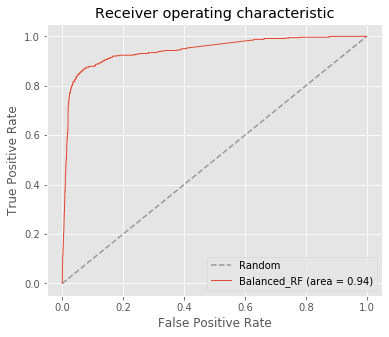

In [191]:
fig, ax = plt.subplots(1, figsize=(6, 5))
for label, clf in clfs.items():
    plot_roc_nofit(ax, Xcsd_test, y_test, clf, label)

### example PSAW pushshift code to get multiple comments at once

In [34]:
api = PushshiftAPI()

In [37]:
gen = api.search_comments(id='cax4ng0,cax1t9x')
next(gen).d_, next(gen).d_

({'all_awardings': [],
  'approved_at_utc': None,
  'associated_award': None,
  'author': 'YoMySlime',
  'author_flair_background_color': None,
  'author_flair_css_class': None,
  'author_flair_richtext': [],
  'author_flair_template_id': None,
  'author_flair_text': None,
  'author_flair_text_color': None,
  'author_flair_type': 'text',
  'author_fullname': 't2_50x4bh7d',
  'author_patreon_flair': False,
  'author_premium': False,
  'awarders': [],
  'banned_at_utc': None,
  'body': '"Oh no we have to stay inside, this is the worst thing ever"...It\'s certainly a walk in the park compared to kids being blown to bits in Syria all year round.',
  'can_mod_post': False,
  'collapsed': False,
  'collapsed_because_crowd_control': None,
  'collapsed_reason': None,
  'created_utc': 1591193808,
  'distinguished': None,
  'edited': False,
  'gildings': {},
  'id': 'fsqyy9c',
  'is_submitter': True,
  'link_id': 't3_gvucfg',
  'locked': False,
  'no_follow': True,
  'parent_id': 't1_fsqyg07',
 

### example PRAW code for getting multiple subreddits with the same search from reddit

In [41]:
gen = reddit.subreddits.search("t5_2r99w,t5_2r99w")
next(gen), next(gen)

(Subreddit(display_name='whisky'),
 Subreddit(display_name='BaseballbytheNumbers'))

### code to bring the subreddit id and the name of the subreddit together

In [ ]:
dict(zip(comms['subreddit_id'], comms['subreddit']))

In [ ]:
# np.unique(comms['subreddit_id'] + '_' + comms['subreddit'], return_counts=True)
comms['subreddit_id']

### explore comment ids for troll comments

In [31]:
troll_comments = comms[comms['troll?']==1]

In [32]:
len(troll_comments)

6704

In [33]:
# let's get the ids for all the troll_comments, then retrieve all the replies to it from Pushshift
troll_comments['id']

0       d4qvapg
1       d4quowa
2       d4queet
3       d4qu1y2
4       d45sina
         ...   
6699    cr9am58
6700    cqv2a2n
6701    cquhx8m
6702    cqt2nku
6703    cpe9ci5
Name: id, Length: 6704, dtype: object

### explore comments in /r/politics

In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    troll_comments = comms[comms['troll?']==1]
    print(troll_comments[troll_comments['subreddit']=='politics'])
# comms.tail().iloc[0, :]

                   author  author_created_utc author_flair_css_class  \
408           BlackToLive        1.467681e+09                   None   
409           BlackToLive        1.467681e+09                   None   
410           BlackToLive        1.467681e+09                   None   
436               deusXYX        1.470449e+09                   None   
439               deusXYX        1.470449e+09                   None   
448               deusXYX        1.470449e+09                   None   
452               deusXYX        1.470449e+09                   None   
479               deusXYX        1.470449e+09                   None   
480               deusXYX        1.470449e+09                   None   
481               deusXYX        1.470449e+09                   None   
488               deusXYX        1.470449e+09                   None   
496               deusXYX        1.470449e+09                   None   
499               deusXYX        1.470449e+09                   

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    not_troll_comments = comms[comms['troll?']!=1]
    print(not_troll_comments[not_troll_comments['subreddit_id']=='t5_2cneq'].head())

      author  author_created_utc author_flair_css_class author_flair_text  \
10176    NaN                 NaN              ohio-flag    :flag-oh: Ohio   
10177    NaN                 NaN                   None              None   
10178    NaN                 NaN                   None              None   
10179    NaN                 NaN                   None              None   
10180    NaN                 NaN                   None              None   

      author_fullname                                               body  \
10176        t2_49e5c  Here's the video in question: \nhttp://www.ksd...   
10177        t2_58xrc  Dismissing evidence based on an irrelevant ide...   
10178        t2_9f7me  http://www.stltoday.com/news/local/crime-and-c...   
10179        t2_38i2k  For the record, that is an elbow strike, not a...   
10180        t2_7sybj  "Silent Witness Rule"\n\n"When there is no eye...   

       controversiality   created_utc distinguished  gilded       id  \
10176   

### number of troll comments in reply to other trolls...

In [43]:
np.logical_and(comms['troll?']==1, comms['parent_of_troll?']==1).sum()

54

In [ ]:
    outcols = df.columns + ['comm_type']
    # allow for extra columns after depth, nest_level, and parent_id
    if list(df.columns)[:3] != ['depth', 'nest_level', 'parent_id']:
        raise
    outdf = pd.DataFrame(np.hstack([
        df.values, 
        np.array([
            x.split('_')[0] for x in df['parent_id'].values
        ])
        .reshape(-1, 1)
    ]), columns=outcols)
    outdf['depth'] = outdf['depth'].astype(float)
    outdf['nest_level'] = outdf['nest_level'].astype(float)
    if 'troll?' in outcols:
        outdf['troll?'] = outdf['troll?'].astype(int)
    return outdf